<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Outotec/Outotec_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "OTE1VFIEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 13:04:47,761 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 13:04:47,762 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for OTE1VFIEUR
2019-08-26 13:08:17,154 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 13:14:51,415 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 13:18:21,212 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 13:22:00,957 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 13:25:44,944 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-26 13:29:07,023 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-26 13:32:59,401 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-26 13:36:07,414 - findatapy.market.datavendorweb - INFO - Downloading... 2018-0

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.07067  0.07108  0.07017  0.07043  0.329197
2018-01-02 09:00:00  0.07042  0.07087  0.06968  0.07038  0.410050
2018-01-02 10:00:00  0.07038  0.07078  0.07027  0.07037  0.308920
2018-01-02 11:00:00  0.07037  0.07137  0.07032  0.07133  0.336719
2018-01-02 12:00:00  0.07133  0.07183  0.07107  0.07147  0.545770
...                      ...      ...      ...      ...       ...
2018-12-28 12:00:00  0.03034  0.03052  0.03011  0.03036  1.530000
2018-12-28 13:00:00  0.03036  0.03048  0.03020  0.03037  0.670000
2018-12-28 14:00:00  0.03047  0.03080  0.03037  0.03065  1.770000
2018-12-28 15:00:00  0.03077  0.03078  0.03015  0.03035  4.790000
2018-12-28 16:00:00  0.03045  0.03076  0.03034  0.03064  2.790000

[2239 rows x 5 columns]

Open         High          Low        Close       Volume
count  2239.000000  2239.000000  2239.000000  2239.000000  2239.000000
mean      0.063547     0.063950     0.063132     0.063545     3.494928
std       0.015607     0.015647     0.015591     0.015635     2.296905
min       0.028480     0.028760     0.028410     0.028480     0.270936
25%       0.055180     0.055530     0.054735     0.055170     1.910000
50%       0.069070     0.069540     0.068720     0.069110     2.790000
75%       0.075020     0.075400     0.074710     0.075085     4.540000
max       0.084440     0.085110     0.084190     0.084590    18.330000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-09 13:00:00  0.07528  0.07538  0.07509  0.07518  0.787910    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.075158  0.074112  0.074038  0.075247  0.075175  0.075014    0.075050    0.074700  0.074280  0.075154  0.075204  0.075145  0.075183  0.075154  0.075250  0.074988                0.075495                 0.075154                0.074812                0.075666                 0.075154                0.074642                0.075837                 0.075154                0.074471                0.076007                 0.075154                0.074300  0.075175  0.075209  0.075038                0.075516                 0.075175                0.074833                0.075687                 0.075175                0.074663                0.075858                 0.075175                0.074492                0.076029                 0.075175                0.074321   
2018-01-09 14:00:00  0.07520  0.07533  0.07498  0.07516  1.008474    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.075158  0.074138  0.074066  0.075225  0.075172  0.075016    0.075050    0.074700  0.074373  0.075140  0.075177  0.075180  0.075184  0.075140  0.075170  0.075017                0.075470                 0.075140                0.074810                0.075635                 0.075140                0.074645                0.075801                 0.075140                0.074479                0.075966                 0.075140                0.074314  0.075172  0.075174  0.075062                0.075502                 0.075172                0.074841                0.075667                 0.075172                0.074676                0.075832                 0.075172                0.074511                0.075997                 0.075172                0.074346   
2018-01-09 15:00:00  0.0

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000    2189.000000  2189.000000   2189.000000     2189.000000       2189.000000  2189.000000  2189.000000  2189.000000  2189.000000   2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000  2189.000000  2189.000000  2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000             2189.000000   
mean      0.063317     0.063719     0.062897     0.063311     3.554039    16.006396     2.010507   184.460484      30.420283    11.382366      0.032435        0.024212          0.004111     6.565098     2.527181    26.921425     2.010507      1.994975    26.921425     0.063384     0.063569    -0.004067     0.063311     0.063383     0.063423     0.063381     0.063352     0.063454     0.063383     0.063311     0.063383     0.063359     0.063383     0.063325     0.063528                0.064478                 0.063383                0.062288                0.065025                 0.063383                0.061740                0.065573                 0.063383                0.061193                0.066120                 0.063383                0.060645     0.063383     0.063326     0.063506                0.064478                 0.063383                0.062288                0.065025                 0.063383                0.061741                0.065573   
std       0.015707     0.015748     0.015688     0.015733     2.288297     8.575397     1.410129   101.502388       0.855496     2.620493      0.177193        0.153742          0.064003     3.340925     1.102936    14.499298     1.410129      1.408213    14.499298     0.015643     0.015449     0.065214     0.015741     0.015660     0.015585     0.015666     0.015644     0.015572     0.015669     0.015737     0.015672     0.015687     0.015669     0.015724     0.015537                0.015716                 0.015669                0.015677                0.015761                 0.015669                0.015703                0.015819                 0.015669                0.015742                0.015890                 0.015669                0.015795     0.015660     0.015718     0.015557                0.015705                 0.015660                0.015672                0.015747                 0.015660                0.015699                0.015804   
min       0.028480     0.028760     0.028410     0.028480     0.310000     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.836312  0.827329  0.836859  0.832294  0.026521    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.837533  0.827420  0.944802  0.838365  0.840785  0.845708    0.836411    0.830398  0.808990  0.840565  0.836990  0.839946  0.840572  0.840565  0.836975  0.842293                0.824537                 0.840565                0.852711                0.812173                 0.840565                0.868587                0.800154                 0.840565                0.882509                0.788467                 0.840565                0.894084  0.840785  0.837245  0.842398                0.822584                 0.840785                0.858010                0.810286                 0.840785                0.874133                0.797845                 0.840785                0.887333                0.785643                 0.840785   
2018-01-09 14:00:00  0.834882  0.826442  0.834887  0.831937  0.038761    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.837535  0.827901  0.944969  0.837971  0.840725  0.845745    0.836411    0.830398  0.810627  0.840316  0.836510  0.840580  0.840597  0.840316  0.835536  0.842825                0.824093                 0.840316                0.852666                0.811637                 0.840316                0.868634                0.799530                 0.840316                0.882630                0.787756                 0.840316                0.894268  0.840725  0.836622  0.842842                0.822327                 0.840725                0.858144                0.809935                 0.840725                0.874339                0.797402                 0.840725                0.887599                0.785112                 0.840725   
2018-01-09 15:00:00  0.834167  0.827684  0.831122  0.826947  0.050239    9          1          9         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0ajxi1jz
  JVM stdout: /tmp/tmp0ajxi1jz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0ajxi1jz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_cqyd7n
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.568542  0.763043              0.478168  0.520407  0.270823
1  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.566539  0.738063              0.464894  0.516498  0.266770
2  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.565620  0.698463              0.487310  0.502637  0.252644
3              DeepLearning_1_AutoML_20190826_135442  0.558190  2.799951              0.465478  0.714965  0.511176
4  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.500000  0.692854              0.500000  0.499853  0.249853
5  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.500000  0.693264              0.500000  0.500059  0.250059
6  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.500000  0.692819              0.500000  0.499836  0.249836
7  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.500000  0.694309              0.500000  0.500580  0.250581
8  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.491192  4.725266              0.500000  0.708313  0.501708
9  DeepLearning_grid_1_AutoML_20190826_135442_mod...  0.449157  1.846812              0.500000  0.671047  0.450304

variable  relative_importance  scaled_importance  percentage
0          CDLGAPSIDESIDEWHITE             1.000000           1.000000    0.003012
1                    CDL2CROWS             0.937959           0.937959    0.002825
2            CDLSTALLEDPATTERN             0.910678           0.910678    0.002743
3           CDLMORNINGDOJISTAR             0.899728           0.899728    0.002710
4              CDLSHOOTINGSTAR             0.897504           0.897504    0.002703
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_24_1_4             0.265838           0.265838    0.000801
1032                 MAVP_14_1             0.261704           0.261704    0.000788
1033                   MA_14_3             0.258857           0.258857    0.000780
1034  BBANDS_middleband_14_1_4             0.257475           0.257475    0.000775
1035       CDLRISEFALL3METHODS             0.242461           0.242461    0.000730

[1036 rows x 4 columns]

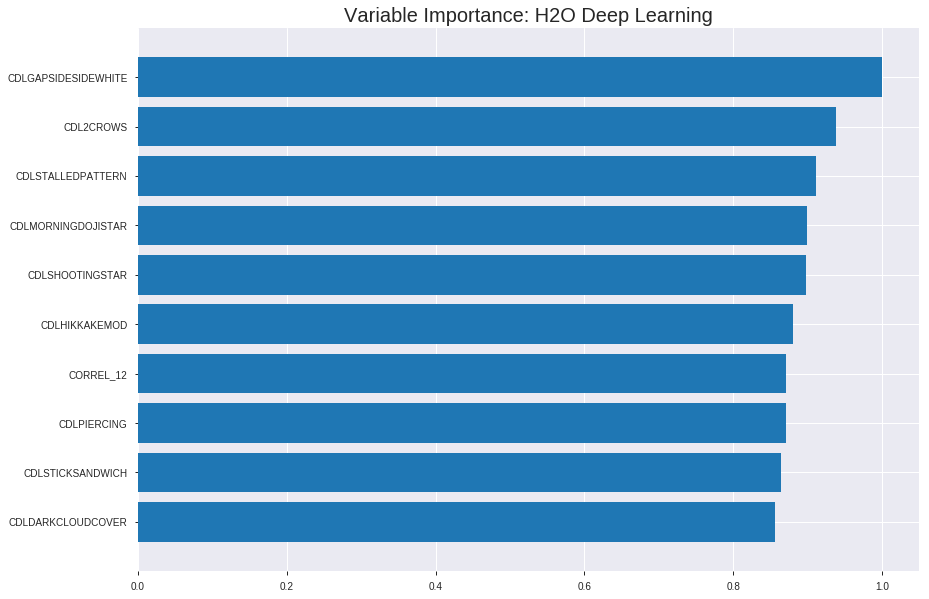

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_135442_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24021496291664246
RMSE: 0.4901172950597055
LogLoss: 0.6738289844433305
Mean Per-Class Error: 0.40670026849580854
AUC: 0.6305987866448955
pr_auc: 0.5995822089288685
Gini: 0.2611975732897911
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24666031059488555: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      99   689   0.8744   (689.0/788.0)
1      20   723   0.0269   (20.0/743.0)
Total  119  1412  0.4631   (709.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.24666      0.670998  343
max f2                       0.132974     0.82831   380
max f0point5                 0.479842     0.584492  216
max accuracy                 0.492297     0.591117  207
max precision                0.993319     1         0
max recall                   0.0923712    1         385
max specificity              0.993319     1         0
max absolute_mcc             0.395384     0.192537  268
max min_per_class_accuracy   0.515994     0.584118  193
max mean_per_class_accuracy  0.479842     0.5933    216

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.878443           1.41664   1.41664            0.6875           0.92362   0.6875                      0.92362             0.0148048       0.0148048                  41.6639   41.6639
    2        0.0202482                   0.858529           1.51108   1.46234            0.733333         0.867699  0.709677                    0.896562            0.0148048       0.0296097                  51.1081   46.2337
    3        0.0300457                   0.842111           1.23634   1.38864            0.6              0.848845  0.673913                    0.881002            0.0121131       0.0417227                  23.6339   38.8642
    4        0.0404964                   0.827044           1.28785   1.36263            0.625            0.836159  0.66129                     0.869429            0.013459        0.0551817                  28.7853   36.2632
    5        0.0502939                   0.81041            1.78582   1.44507            0.866667         0.818899  0.701299                    0.859586            0.0174966       0.0726783                  78.5823   44.5072
    6        0.100588                    0.753222           1.33803   1.39155            0.649351         0.782516  0.675325                    0.821051            0.0672948       0.139973                   33.8029   39.1551
    7        0.150229                    0.702675           1.38275   1.38864            0.671053         0.727203  0.673913                    0.79004             0.0686406       0.208614                   38.2748   38.8642
    8        0.200523                    0.66195            1.09718   1.31554            0.532468         0.682796  0.638436                    0.763142            0.0551817       0.263795                   9.71841   31.554
    9        0.300457                    0.609109           1.10436   1.2453             0.535948         0.635849  0.604348                    0.720803            0.110363        0.374159                   10.4355   24.5298
    10       0.400392                    0.558442           1.07742   1.2034             0.522876         0.583764  0.584013                    0.686599            0.107672        0.48183                    7.74198   20.3397
    11       0.500327                    0.512938           1.06395   1.17554            0.51634          0.535626  0.570496                    0.656444            0.106326        0.588156                   6.3952    17.5544
    12       0.600261                    0.460755           1.01008   1.148              0.490196         0.487999  0.557127                    0.6284              0.100942        0.689098                   1.0081    14.7997
    13       0.700196                    0.408799           0.969678  1.12255            0.470588         0.435768  0.544776                    0.600907            0.0969044       0.786003                   -3.03222  12.2547
    14       0.800131                    0.347167           0.915807  1.09673            0.444444         0.38134   0.532245                    0.573484            0.0915209       0.877524                   -8.41932  9.67254
    15       0.900065                    0.271599           0.754194  1.05869            0.366013         0.307373  0.513788                    0.543937            0.0753701       0.952894                   -24.5806  5.86939
    16       1                           0.0067142          0.471371  1                  0.228758         0.193761  0.485304                    0.508942          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30280978070046427
RMSE: 0.5502815467562621
LogLoss: 0.9023364155960655
Mean Per-Class Error: 0.4735524256651017
AUC: 0.5109128847157016
pr_auc: 0.5307107168445322
Gini: 0.02182576943140324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00861095938763405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    204  0.9577   (204.0/213.0)
1      4    221  0.0178   (4.0/225.0)
Total  13   425  0.4749   (208.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00861096   0.68      391
max f2                       0.000630894  0.841436  398
max f0point5                 0.00861096   0.574026  391
max accuracy                 0.303799     0.52968   249
max precision                0.916644     1         0
max recall                   0.000630894  1         398
max specificity              0.916644     1         0
max absolute_mcc             0.768988     0.104554  4
max min_per_class_accuracy   0.376582     0.507042  200
max mean_per_class_accuracy  0.303799     0.526448  249

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 36.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.761866           1.94667   1.94667            1                0.816155   1                           0.816155            0.0222222       0.0222222                  94.6667   94.6667
    2        0.0205479                   0.706116           0.973333  1.51407            0.5              0.741249   0.777778                    0.782864            0.00888889      0.0311111                  -2.66667  51.4074
    3        0.0319635                   0.692164           0.778667  1.25143            0.4              0.696632   0.642857                    0.752067            0.00888889      0.04                       -22.1333  25.1429
    4        0.0410959                   0.673804           0.973333  1.18963            0.5              0.682738   0.611111                    0.73666             0.00888889      0.0488889                  -2.66667  18.963
    5        0.0502283                   0.662969           1.46      1.23879            0.75             0.669911   0.636364                    0.724524            0.0133333       0.0622222                  46        23.8788
    6        0.100457                    0.622792           0.796364  1.01758            0.409091         0.64266    0.522727                    0.683592            0.04            0.102222                   -20.3636  1.75758
    7        0.150685                    0.568899           0.707879  0.914343           0.363636         0.595661   0.469697                    0.654282            0.0355556       0.137778                   -29.2121  -8.56566
    8        0.200913                    0.542702           1.41576   1.0397             0.727273         0.555137   0.534091                    0.629496            0.0711111       0.208889                   41.5758   3.9697
    9        0.30137                     0.480669           0.796364  0.958586           0.409091         0.51207    0.492424                    0.590354            0.08            0.288889                   -20.3636  -4.14141
    10       0.399543                    0.427171           1.04124   0.978895           0.534884         0.45223    0.502857                    0.556415            0.102222        0.391111                   4.12403   -2.11048
    11       0.5                         0.377048           1.1503    1.01333            0.590909         0.404806   0.520548                    0.525955            0.115556        0.506667                   15.0303   1.33333
    12       0.600457                    0.3165             1.1503    1.03625            0.590909         0.346615   0.532319                    0.495951            0.115556        0.622222                   15.0303   3.62484
    13       0.69863                     0.267476           0.950698  1.02423            0.488372         0.29006    0.526144                    0.467019            0.0933333       0.715556                   -4.93023  2.42266
    14       0.799087                    0.197305           0.929091  1.01227            0.477273         0.234849   0.52                        0.437832            0.0933333       0.808889                   -7.09091  1.22667
    15       0.899543                    0.102476           0.840606  0.993096           0.431818         0.160592   0.510152                    0.406871            0.0844444       0.893333                   -15.9394  -0.690355
    16       1                           0.000468933        1.06182   1                  0.545455         0.0275852  0.513699                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:58:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:58:31  3 min 41.880 sec  343 obs/sec       0.177008  1             271        0.640422         2.76575             -0.641982      0.560307        0.533731           1.41664          0.514696                         0.71521            12.6339               -1.04764         0.497141          0.531987             1.168              0.486301
    2019-08-26 13:58:45  3 min 55.875 sec  460 obs/sec       4.06205   21            6219       0.614003         1.80875             -0.509301      0.586719        0.513119           1.67421          0.489223                         0.697248           8.04086               -0.946077        0.511205          0.316882             1.168              0.486301
    2019-08-26 13:58:58  4 min  8.897 sec  452 obs/sec       7.43501   38            11383      0.621781         2.4562              -0.547784      0.566184        0.431561           1.15907          0.460483                         0.697353           14.7381               -0.946667        0.5               0                    1.01826            0.486301
    2019-08-26 13:59:12  4 min 22.813 sec  468 obs/sec       11.5532   59            17688      0.553146         1.06711             -0.22494       0.61754         0.566717           1.41664          0.466362                         0.689785           5.26604               -0.904645        0.507366          0.430416             1.94667            0.479452
    2019-08-26 13:59:25  4 min 35.921 sec  477 obs/sec       15.4448   79            23646      0.549313         1.06595             -0.208024      0.60143         0.532321           1.28785          0.449379                         0.694995           5.00553               -0.933521        0.493177          0.476735             0.778667           0.484018
    2019-08-26 13:59:39  4 min 50.004 sec  485 obs/sec       19.7636   101           30258      0.490117         0.673829            0.0383093      0.630599        0.599582           1.41664          0.463096                         0.550282           0.902336              -0.212149        0.510913          0.530711             1.94667            0.474886
    2019-08-26 13:59:52  5 min  3.091 sec  490 obs/sec       23.7315   121           36333      0.499587         0.698771            0.000787082    0.614561        0.587893           1.67421          0.480732                         0.631455           1.38671               -0.59614         0.493062          0.517681             0.778667           0.481735
    2019-08-26 14:00:05  5 min 15.927 sec  494 obs/sec       27.6839   141           42384      0.516627         0.756083            -0.0685363     0.596061        0.587531           1.54542          0.502939                         0.586702           1.03192               -0.377914        0.513938          0.532717             1.94667            0.481735
    2019-08-26 14:00:19

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGAPSIDESIDEWHITE       1.0                    1.0                  0.0030119277060260776
CDL2CROWS                 0.9379586577415466     0.9379586577415466   0.0028250636683587954
CDLSTALLEDPATTERN         0.9106781482696533     0.9106781482696533   0.002742896746045893
CDLMORNINGDOJISTAR        0.8997283577919006     0.8997283577919006   0.0027099167687307693
CDLSHOOTINGSTAR           0.8975037932395935     0.8975037932395935   0.002703216541121832
---                       ---                    ---                  ---
BBANDS_middleband_24_1_4  0.26583781838417053    0.26583781838417053  0.0008006842905008117
MAVP_14_1                 0.2617042064666748     0.2617042064666748   0.0007882341502405467
MA_14_3                   0.25885748863220215    0.25885748863220215  0.00077966004192366
BBANDS_middleband_14_1_4  0.25747478008270264    0.25747478008270264  0.0007754954237340633
CDLRISEFALL3METHODS       0.24246053397655487    0.24246053397655487  0.0007302735999018627


See the whole table with table.as_data_frame()


('accuracy', 0.6027397260273972)

('F1', 0.660377358490566)

('auc', 0.5685423276006011)

('logloss', 0.7630429757222723)

('mean_per_class_error', 0.3960594423109034)

('rmse', 0.5204066674683367)

('mse', 0.2708230995455)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


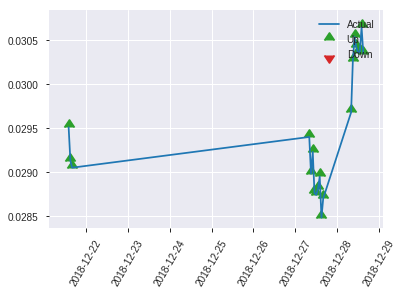


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2708230995455
RMSE: 0.5204066674683367
LogLoss: 0.7630429757222723
Mean Per-Class Error: 0.3960594423109034
AUC: 0.5685423276006011
pr_auc: 0.5319300313883761
Gini: 0.13708465520120217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10903362206518288: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    107  0.9469   (107.0/113.0)
1      1    105  0.0094   (1.0/106.0)
Total  7    212  0.4932   (108.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.109034     0.660377  211
max f2                       0.00477982   0.825545  217
max f0point5                 0.340625     0.592334  116
max accuracy                 0.34704      0.60274   114
max precision                0.765004     1         0
max recall                   0.00477982   1         217
max specificity              0.765004     1         0
max absolute_mcc             0.340625     0.208264  116
max min_per_class_accuracy   0.361092     0.584071  108
max mean_per_class_accuracy  0.340625     0.603941  116

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 36.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.727671           1.37736   1.37736            0.666667         0.752885  0.666667                    0.752885            0.0188679       0.0188679                  37.7358   37.7358
    2        0.0228311                   0.660914           0         0.826415           0                0.669066  0.4                         0.719357            0               0.0188679                  -100      -17.3585
    3        0.0319635                   0.648872           2.06604   1.18059            1                0.657914  0.571429                    0.701802            0.0188679       0.0377358                  106.604   18.0593
    4        0.0410959                   0.620706           1.03302   1.1478             0.5              0.641045  0.555556                    0.6883              0.00943396      0.0471698                  3.30189   14.7799
    5        0.0502283                   0.609642           1.03302   1.12693            0.5              0.612917  0.545455                    0.674594            0.00943396      0.0566038                  3.30189   12.693
    6        0.100457                    0.576294           1.12693   1.12693            0.545455         0.593642  0.545455                    0.634118            0.0566038       0.113208                   12.693    12.693
    7        0.150685                    0.526848           1.12693   1.12693            0.545455         0.555765  0.545455                    0.608               0.0566038       0.169811                   12.693    12.693
    8        0.200913                    0.496829           0.939108  1.07997            0.454545         0.508304  0.522727                    0.583076            0.0471698       0.216981                   -6.08919  7.99743
    9        0.30137                     0.456021           1.22084   1.12693            0.590909         0.475017  0.545455                    0.547057            0.122642        0.339623                   22.084    12.693
    10       0.401826                    0.40378            1.22084   1.15041            0.590909         0.42798   0.556818                    0.517288            0.122642        0.462264                   22.084    15.0407
    11       0.502283                    0.359408           1.31475   1.18328            0.636364         0.380567  0.572727                    0.489943            0.132075        0.59434                    31.4751   18.3276
    12       0.598174                    0.308588           0.688679  1.10399            0.333333         0.333666  0.534351                    0.464891            0.0660377       0.660377                   -31.1321  10.399
    13       0.69863                     0.256717           0.751286  1.05327            0.363636         0.287927  0.509804                    0.439446            0.0754717       0.735849                   -24.8714  5.32741
    14       0.799087                    0.20832            0.563465  0.991698           0.272727         0.233645  0.48                        0.413573            0.0566038       0.792453                   -43.6535  -0.830189
    15       0.899543                    0.160346           1.12693   1.0068             0.545455         0.188508  0.48731                     0.388439            0.113208        0.90566                    12.693    0.680011
    16       1                           0.00382467         0.939108  1                  0.454545         0.105315  0.484018                    0.359998          

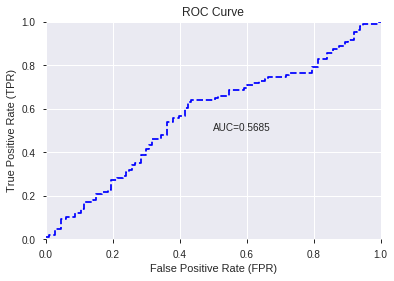

This function is available for GLM models only


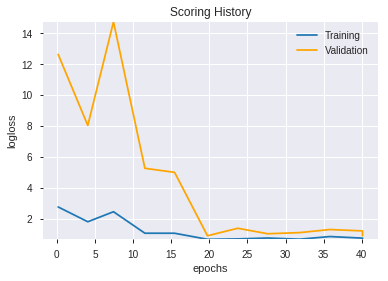

--2019-08-26 14:24:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  58.0MB/s    in 6.1s    

2019-08-26 14:25:02 (57.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_135442_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_135442_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_142511_model_1  0.592419  0.786922              0.448071  0.521678  0.272148
1  DeepLearning_grid_1_AutoML_20190826_142511_model_5  0.590666  0.705443              0.491150  0.502927  0.252935
2  DeepLearning_grid_1_AutoML_20190826_142511_model_3  0.582234  0.806573              0.495575  0.511890  0.262032
3  DeepLearning_grid_1_AutoML_20190826_142511_model_8  0.577058  0.692150              0.486726  0.499465  0.249465
4  DeepLearning_grid_1_AutoML_20190826_142511_model_4  0.574637  0.928278              0.500000  0.547683  0.299957
5  DeepLearning_grid_1_AutoML_20190826_142511_model_2  0.567374  0.847208              0.465771  0.527252  0.277995
6  DeepLearning_grid_1_AutoML_20190826_142511_model_6  0.554767  0.697467              0.500000  0.500928  0.250929
7               DeepLearning_1_AutoML_20190826_142511  0.500334  0.740019              0.474036  0.521063  0.271507
8  DeepLearning_grid_1_AutoML_20190826_142511_model_9  0.490733  0.692862              0.491150  0.499858  0.249858
9  DeepLearning_grid_1_AutoML_20190826_142511_model_7  0.483720  0.715452              0.482593  0.506623  0.256667

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             1.000000           1.000000    0.021756
1        CDLMORNINGSTAR             0.980220           0.980220    0.021326
2          aroondown_30             0.964012           0.964012    0.020973
3                SAREXT             0.956399           0.956399    0.020807
4          is_month_end             0.955679           0.955679    0.020792
5      CDLSTICKSANDWICH             0.955557           0.955557    0.020789
6             CORREL_20             0.953110           0.953110    0.020736
7           CDLPIERCING             0.949393           0.949393    0.020655
8                Volume             0.948582           0.948582    0.020637
9          CDLTASUKIGAP             0.944331           0.944331    0.020545
10         HT_TRENDMODE             0.943513           0.943513    0.020527
11                 hour             0.943415           0.943415    0.020525
12            CDL2CROWS             0.943161           0.943161    0.020519
13  CDLGAPSIDESIDEWHITE             0.941343           0.941343    0.020480
14              BETA_24             0.932646           0.932646    0.020291
15      CDLLADDERBOTTOM             0.932611           0.932611    0.020290
16            CORREL_24             0.929941           0.929941    0.020232
17       CDLRICKSHAWMAN             0.929468           0.929468    0.020221
18  CDLXSIDEGAP3METHODS             0.925959           0.925959    0.020145
19          aroondown_8             0.924851           0.924851    0.020121
20       is_month_start             0.923289           0.923289    0.020087
21           aroonup_12             0.922689           0.922689    0.020074
22      CDLUNIQUE3RIVER             0.921713           0.921713    0.020053
23               MFI_30             0.921157           0.921157    0.020041
24            dayofweek             0.920443           0.920443    0.020025
25                   AD             0.919499           0.919499    0.020005
26            CORREL_14             0.916350           0.916350    0.019936
27   CDLMORNINGDOJISTAR             0.915366           0.915366    0.019915
28       STOCHRSI_fastk             0.913521           0.913521    0.019874
29           aroonup_14             0.911470           0.911470    0.019830
30            CDLHAMMER             0.911017           0.911017    0.019820
31      CDLSHOOTINGSTAR             0.905334           0.905334    0.019696
32    CDLGRAVESTONEDOJI             0.904280           0.904280    0.019673
33   CDLEVENINGDOJISTAR             0.904206           0.904206    0.019672
34       CDLEVENINGSTAR             0.902381           0.902381    0.019632
35    CDLDARKCLOUDCOVER             0.901356           0.901356    0.019610
36         CDLTHRUSTING             0.900147           0.900147    0.019584
37       CDL3LINESTRIKE             0.896186           0.896186    0.019497
38     CDLDRAGONFLYDOJI             0.895878           0.895878    0.019491
39        CDLHIKKAKEMOD             0.895686           0.895686    0.019486
40            CORREL_12             0.895171           0.895171    0.019475
41      CDLHOMINGPIGEON             0.894060           0.894060    0.019451
42          HT_DCPERIOD             0.893669           0.893669    0.019443
43       CDLMATCHINGLOW             0.890704           0.890704    0.019378
44      CDLADVANCEBLOCK             0.888243           0.888243    0.019325
45              weekday             0.887551           0.887551    0.019309
46    CDLINVERTEDHAMMER             0.876116           0.876116    0.019061
47         weekday_name             0.868138           0.868138    0.018887
48            CDLTAKURI             0.857887           0.857887    0.018664
49        CDLHANGINGMAN             0.856849           0.856849    0.018642

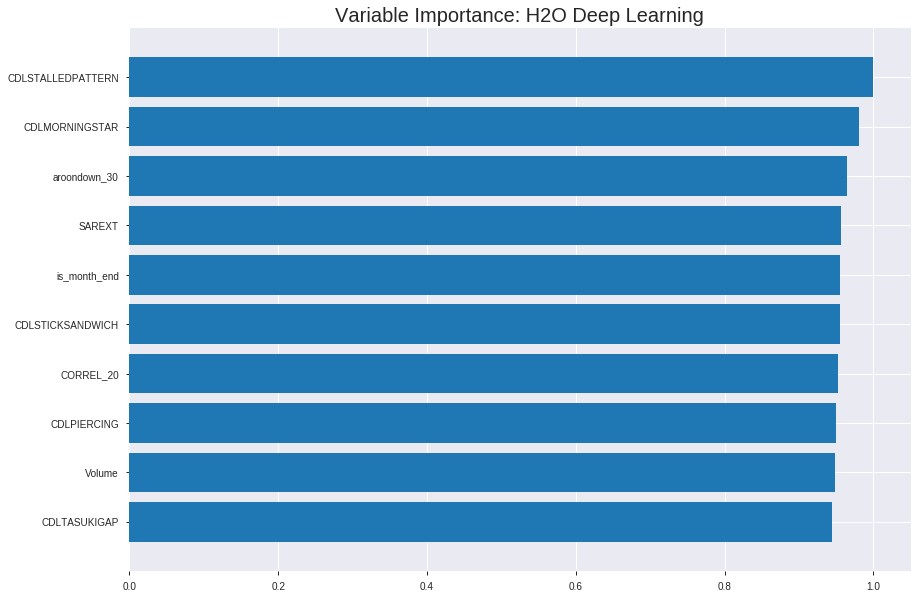

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_142511_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2803630169093117
RMSE: 0.5294931698419836
LogLoss: 1.0127527799981333
Mean Per-Class Error: 0.42627467189538915
AUC: 0.591071660369882
pr_auc: 0.553485506253693
Gini: 0.18214332073976403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23370976744225133: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      177  611   0.7754   (611.0/788.0)
1      83   660   0.1117   (83.0/743.0)
Total  260  1271  0.4533   (694.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.23371      0.655412  321
max f2                       6.98704e-06  0.825006  399
max f0point5                 0.308994     0.571049  285
max accuracy                 0.407096     0.570216  241
max precision                0.992053     0.704545  5
max recall                   6.98704e-06  1         399
max specificity              0.999803     0.991117  0
max absolute_mcc             0.248592     0.15781   314
max min_per_class_accuracy   0.490082     0.554569  203
max mean_per_class_accuracy  0.407096     0.573725  241

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.999492           1.28785   1.28785            0.625            0.999832   0.625                       0.999832            0.013459        0.013459                   28.7853   28.7853
    2        0.0202482                   0.996414           1.37371   1.3294             0.666667         0.998441   0.645161                    0.999159            0.013459        0.0269179                  37.371    32.9397
    3        0.0300457                   0.989125           1.51108   1.38864            0.733333         0.993402   0.673913                    0.997282            0.0148048       0.0417227                  51.1081   38.8642
    4        0.0404964                   0.982378           1.15907   1.3294             0.5625           0.9864     0.645161                    0.994473            0.0121131       0.0538358                  15.9068   32.9397
    5        0.0502939                   0.973618           1.78582   1.41831            0.866667         0.978806   0.688312                    0.991421            0.0174966       0.0713324                  78.5823   41.8311
    6        0.100588                    0.911721           1.15071   1.28451            0.558442         0.944641   0.623377                    0.968031            0.0578735       0.129206                   15.0705   28.4508
    7        0.150229                    0.829764           1.19296   1.25426            0.578947         0.87065    0.608696                    0.935853            0.0592194       0.188425                   19.2959   25.4257
    8        0.200523                    0.773803           1.17747   1.235              0.571429         0.799455   0.599349                    0.901642            0.0592194       0.247645                   17.7466   23.4997
    9        0.300457                    0.66635            0.983146  1.15123            0.477124         0.718618   0.558696                    0.840767            0.0982503       0.345895                   -1.68545  15.1229
    10       0.400392                    0.570376           1.10436   1.13953            0.535948         0.616579   0.553018                    0.784811            0.110363        0.456258                   10.4355   13.953
    11       0.500327                    0.488673           1.02355   1.11636            0.496732         0.527379   0.541775                    0.733392            0.102288        0.558546                   2.35488   11.6364
    12       0.600261                    0.417158           1.13129   1.11885            0.54902          0.453025   0.542982                    0.686715            0.113055        0.671602                   13.1291   11.8849
    13       0.700196                    0.341181           0.942742  1.09371            0.457516         0.379371   0.530784                    0.64285             0.0942127       0.765814                   -5.72577  9.37142
    14       0.800131                    0.258688           0.969678  1.07822            0.470588         0.299906   0.523265                    0.600017            0.0969044       0.862719                   -3.03222  7.82223
    15       0.900065                    0.162879           0.686855  1.03477            0.333333         0.214756   0.502177                    0.557241            0.0686406       0.931359                   -31.3145  3.47686
    16       1                           1.57916e-22        0.686855  1                  0.333333         0.0734106  0.485304                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3227290795878012
RMSE: 0.5680924921065241
LogLoss: 1.1938801383242288
Mean Per-Class Error: 0.4774647887323944
AUC: 0.5136880542514345
pr_auc: 0.5149066447403363
Gini: 0.02737610850286898
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.94465329121818e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.94465e-06  0.678733   399
max f2                       2.94465e-06  0.840807   399
max f0point5                 0.00701266   0.573382   397
max accuracy                 0.132401     0.531963   351
max precision                0.744723     0.5625     46
max recall                   2.94465e-06  1          399
max specificity              0.999977     0.995305   0
max absolute_mcc             0.132401     0.0622039  351
max min_per_class_accuracy   0.357202     0.511737   212
max mean_per_class_accuracy  0.132401     0.522535   351

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 39.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.983266           0.778667  0.778667           0.4              0.995595  0.4                         0.995595            0.00888889      0.00888889                 -22.1333   -22.1333
    2        0.0205479                   0.944942           0.973333  0.865185           0.5              0.965512  0.444444                    0.982225            0.00888889      0.0177778                  -2.66667   -13.4815
    3        0.0319635                   0.935986           0.389333  0.695238           0.2              0.940802  0.357143                    0.967431            0.00444444      0.0222222                  -61.0667   -30.4762
    4        0.0410959                   0.898272           1.94667   0.973333           1                0.918934  0.5                         0.956654            0.0177778       0.04                       94.6667    -2.66667
    5        0.0502283                   0.848549           0.486667  0.884848           0.25             0.868092  0.454545                    0.940552            0.00444444      0.0444444                  -51.3333   -11.5152
    6        0.100457                    0.749885           1.1503    1.01758            0.590909         0.79656   0.522727                    0.868556            0.0577778       0.102222                   15.0303    1.75758
    7        0.150685                    0.694825           1.1503    1.06182            0.590909         0.720799  0.545455                    0.819304            0.0577778       0.16                       15.0303    6.18182
    8        0.200913                    0.629574           1.06182   1.06182            0.545455         0.656525  0.545455                    0.778609            0.0533333       0.213333                   6.18182    6.18182
    9        0.30137                     0.510401           0.840606  0.988081           0.431818         0.568397  0.507576                    0.708538            0.0844444       0.297778                   -15.9394   -1.19192
    10       0.399543                    0.431208           1.13178   1.02339            0.581395         0.473117  0.525714                    0.650692            0.111111        0.408889                   13.1783    2.33905
    11       0.5                         0.357368           1.01758   1.02222            0.522727         0.395519  0.525114                    0.599424            0.102222        0.511111                   1.75758    2.22222
    12       0.600457                    0.277334           1.01758   1.02144            0.522727         0.318452  0.524715                    0.552418            0.102222        0.613333                   1.75758    2.14449
    13       0.69863                     0.218653           0.995969  1.01786            0.511628         0.245487  0.522876                    0.509287            0.0977778       0.711111                   -0.403101  1.78649
    14       0.799087                    0.158382           0.973333  1.01227            0.5              0.190767  0.52                        0.469244            0.0977778       0.808889                   -2.66667   1.22667
    15       0.899543                    0.0970714          1.06182   1.0178             0.545455         0.128643  0.522843                    0.431208            0.106667        0.915556                   6.18182    1.78003
    16       1                           2.73187e-11        0.840606  1                  0.431818         0.03877   0.513699              


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:25:12  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:25:19  6.490 sec   2417 obs/sec      10        1             15310      0.529493         1.01275             -0.122422      0.591072        0.553486           1.28785          0.453298                         0.568092           1.19388               -0.291886        0.513688          0.514907             0.778667           0.486301
    2019-08-26 14:25:24  11.963 sec  2618 obs/sec      20        2             30620      0.523896         0.891438            -0.0988179     0.637182        0.59761            1.80299          0.462443                         0.60525            1.39154               -0.466413        0.539186          0.555929             1.168              0.486301
    2019-08-26 14:25:30  17.348 sec  2703 obs/sec      30        3             45930      0.510502         0.855059            -0.0433517     0.659838        0.61104            1.67421          0.427172                         0.606741           1.4173                -0.473643        0.500543          0.497397             0.778667           0.486301
    2019-08-26 14:25:39  26.902 sec  2896 obs/sec      50        5             76550      0.500159         0.863703            -0.00149956    0.67472         0.644043           1.67421          0.390594                         0.602199           1.45628               -0.451663        0.510496          0.519354             1.168              0.486301
    2019-08-26 14:25:48  35.907 sec  3032 obs/sec      70        7             107170     0.469824         0.703735            0.116297       0.732501        0.689556           1.54542          0.3403                           0.596644           1.42118               -0.425004        0.507053          0.503099             1.168              0.481735
    2019-08-26 14:25:57  44.642 sec  3133 obs/sec      90        9             137790     0.457706         0.698294            0.161296       0.761177        0.728549           1.80299          0.325278                         0.590633           1.38574               -0.396437        0.507741          0.507957             1.168              0.486301
    2019-08-26 14:25:57  44.756 sec  3132 obs/sec      90        9             137790     0.529493         1.01275             -0.122422      0.591072        0.553486           1.28785          0.453298                         0.568092           1.19388               -0.291886        0.513688          0.514907             0.778667           0.486301

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN  1.0                    1.0                  0.021755898263260166
CDLMORNINGSTAR     0.9802195429801941     0.9802195429801941   0.02132555665273648
aroondown_30       0.9640121459960938     0.9640121459960938   0.020972950172838123
SAREXT             0.956399142742157      0.956399142742157    0.020807322448567606
is_month_end       0.9556792974472046     0.9556792974472046   0.020791661567565334
---                ---                    ---                  ---
weekday            0.8875508904457092     0.8875508904457092   0.01930946687600282
CDLINVERTEDHAMMER  0.8761157393455505     0.8761157393455505   0.01906068489204276
weekday_name       0.8681378960609436     0.8681378960609436   0.018887119745182618
CDLTAKURI          0.8578871488571167     0.8578871488571167   0.018664105531893762
CDLHANGINGMAN      0.856849193572998      0.856849193572998    0.018641523882330664


See the whole table with table.as_data_frame()


('accuracy', 0.5981735159817352)

('F1', 0.6688524590163935)

('auc', 0.592419435631992)

('logloss', 0.7869224094227237)

('mean_per_class_error', 0.40223743529804645)

('rmse', 0.5216783667153826)

('mse', 0.27214831829882924)

deeplearning prediction progress: |███████████████████████████████████████| 100%


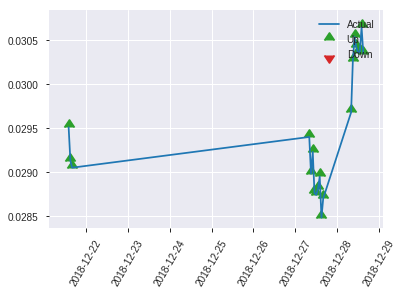


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27214831829882924
RMSE: 0.5216783667153826
LogLoss: 0.7869224094227237
Mean Per-Class Error: 0.40223743529804645
AUC: 0.592419435631992
pr_auc: 0.5744512737323471
Gini: 0.1848388712639839
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1773126594616521: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   97   0.8584   (97.0/113.0)
1      4    102  0.0377   (4.0/106.0)
Total  20   199  0.4612   (101.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.177313     0.668852  198
max f2                       0.0962983    0.829421  214
max f0point5                 0.522561     0.584906  105
max accuracy                 0.533361     0.598174  103
max precision                1            1         0
max recall                   0.0962983    1         214
max specificity              1            1         0
max absolute_mcc             0.522561     0.195525  105
max min_per_class_accuracy   0.522561     0.584906  105
max mean_per_class_accuracy  0.522561     0.597763  105

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 52.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.999382           2.06604   2.06604            1                0.999872  1                           0.999872            0.0283019       0.0283019                  106.604   106.604
    2        0.0228311                   0.996852           1.03302   1.65283            0.5              0.998014  0.8                         0.999129            0.00943396      0.0377358                  3.30189   65.283
    3        0.0319635                   0.981443           1.03302   1.47574            0.5              0.991477  0.714286                    0.996943            0.00943396      0.0471698                  3.30189   47.5741
    4        0.0410959                   0.969119           1.03302   1.37736            0.5              0.975576  0.666667                    0.992194            0.00943396      0.0566038                  3.30189   37.7358
    5        0.0502283                   0.952369           2.06604   1.50257            1                0.960098  0.727273                    0.986359            0.0188679       0.0754717                  106.604   50.2573
    6        0.100457                    0.868444           1.12693   1.31475            0.545455         0.911794  0.636364                    0.949076            0.0566038       0.132075                   12.693    31.4751
    7        0.150685                    0.810079           1.50257   1.37736            0.727273         0.843196  0.666667                    0.913783            0.0754717       0.207547                   50.2573   37.7358
    8        0.200913                    0.756175           0.751286  1.22084            0.363636         0.783211  0.590909                    0.88114             0.0377358       0.245283                   -24.8714  22.084
    9        0.30137                     0.672028           1.12693   1.18954            0.545455         0.707395  0.575758                    0.823225            0.113208        0.358491                   12.693    18.9537
    10       0.401826                    0.581096           1.22084   1.19736            0.590909         0.621821  0.579545                    0.772874            0.122642        0.481132                   22.084    19.7363
    11       0.502283                    0.511902           1.03302   1.16449            0.5              0.545467  0.563636                    0.727392            0.103774        0.584906                   3.30189   16.4494
    12       0.598174                    0.465464           0.787062  1.10399            0.380952         0.486435  0.534351                    0.688766            0.0754717       0.660377                   -21.2938  10.399
    13       0.69863                     0.371318           0.751286  1.05327            0.363636         0.411585  0.509804                    0.64891             0.0754717       0.735849                   -24.8714  5.32741
    14       0.799087                    0.286072           0.751286  1.01531            0.363636         0.332612  0.491429                    0.609147            0.0754717       0.811321                   -24.8714  1.531
    15       0.899543                    0.18485            1.40866   1.05924            0.681818         0.231615  0.51269                     0.566986            0.141509        0.95283                    40.8662   5.92376
    16       1                           2.28743e-14        0.469554  1                  0.227273         0.117855  0.484018                    0.521868            0.

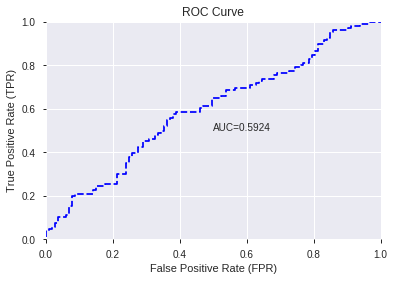

This function is available for GLM models only


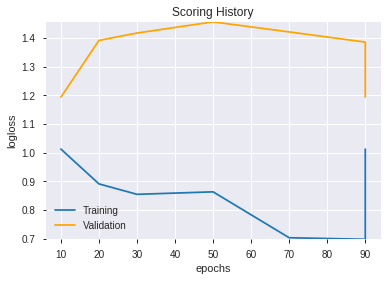

--2019-08-26 14:34:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_142511_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_142511_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'aroondown_30',
 'SAREXT',
 'is_month_end',
 'CDLSTICKSANDWICH',
 'CORREL_20',
 'CDLPIERCING',
 'Volume',
 'CDLTASUKIGAP',
 'HT_TRENDMODE',
 'hour',
 'CDL2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'BETA_24',
 'CDLLADDERBOTTOM',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'CDLXSIDEGAP3METHODS',
 'aroondown_8',
 'is_month_start',
 'aroonup_12',
 'CDLUNIQUE3RIVER',
 'MFI_30',
 'dayofweek',
 'AD',
 'CORREL_14',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastk',
 'aroonup_14',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'CDL3LINESTRIKE',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKEMOD',
 'CORREL_12',
 'CDLHOMINGPIGEON',
 'HT_DCPERIOD',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'weekday',
 'CDLINVERTEDHAMMER',
 'weekday_name',
 'CDLTAKURI',
 'CDLHANGINGMAN']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_143429_model_1  0.561112  0.692564              0.466063  0.499708  0.249708

variable  relative_importance  scaled_importance  percentage
0                    AD             0.009235           1.000000    0.059582
1        CDLMORNINGSTAR             0.008386           0.908069    0.054105
2   CDLGAPSIDESIDEWHITE             0.006403           0.693264    0.041306
3    CDLMORNINGDOJISTAR             0.006108           0.661401    0.039408
4          is_month_end             0.005655           0.612261    0.036480
5               BETA_24             0.005470           0.592309    0.035291
6                Volume             0.004973           0.538472    0.032083
7        CDL3LINESTRIKE             0.004938           0.534690    0.031858
8             CDL2CROWS             0.004928           0.533613    0.031794
9        CDLEVENINGSTAR             0.004820           0.521871    0.031094
10      CDLSHOOTINGSTAR             0.004635           0.501917    0.029905
11    CDLINVERTEDHAMMER             0.004607           0.498853    0.029723
12            CORREL_20             0.004595           0.497512    0.029643
13      CDLHOMINGPIGEON             0.003845           0.416331    0.024806
14       STOCHRSI_fastk             0.003749           0.405905    0.024185
15      CDLLADDERBOTTOM             0.003694           0.399987    0.023832
16      CDLUNIQUE3RIVER             0.003691           0.399678    0.023814
17           aroonup_12             0.003574           0.386983    0.023057
18               SAREXT             0.003519           0.381054    0.022704
19          CDLPIERCING             0.003505           0.379508    0.022612
20         CDLTHRUSTING             0.003499           0.378855    0.022573
21     CDLSTICKSANDWICH             0.003430           0.371379    0.022128
22            CORREL_14             0.003361           0.363934    0.021684
23    CDLDARKCLOUDCOVER             0.003274           0.354494    0.021122
24        CDLHIKKAKEMOD             0.003076           0.333032    0.019843
25       is_month_start             0.003059           0.331210    0.019734
26          HT_DCPERIOD             0.002893           0.313202    0.018661
27        CDLHANGINGMAN             0.002803           0.303488    0.018082
28                 hour             0.002776           0.300625    0.017912
29       CDLMATCHINGLOW             0.002574           0.278749    0.016608
30           aroonup_14             0.002498           0.270466    0.016115
31  CDLXSIDEGAP3METHODS             0.002175           0.235530    0.014033
32         aroondown_30             0.001853           0.200661    0.011956
33            CDLTAKURI             0.001851           0.200442    0.011943
34     CDLDRAGONFLYDOJI             0.001846           0.199895    0.011910
35            CORREL_12             0.001680           0.181950    0.010841
36   CDLEVENINGDOJISTAR             0.001628           0.176239    0.010501
37            CORREL_24             0.001567           0.169619    0.010106
38      CDLADVANCEBLOCK             0.001495           0.161911    0.009647
39          aroondown_8             0.001287           0.139336    0.008302
40         weekday_name             0.001153           0.124874    0.007440
41         CDLTASUKIGAP             0.001135           0.122848    0.007320
42       CDLRICKSHAWMAN             0.000670           0.072512    0.004320
43            dayofweek             0.000579           0.062644    0.003732
44              weekday             0.000574           0.062169    0.003704
45    CDLGRAVESTONEDOJI             0.000512           0.055446    0.003304
46            CDLHAMMER             0.000459           0.049738    0.002964
47         HT_TRENDMODE             0.000447           0.048408    0.002884
48               MFI_30             0.000387           0.041950    0.002499
49    CDLSTALLEDPATTERN             0.000132           0.014253    0.000849

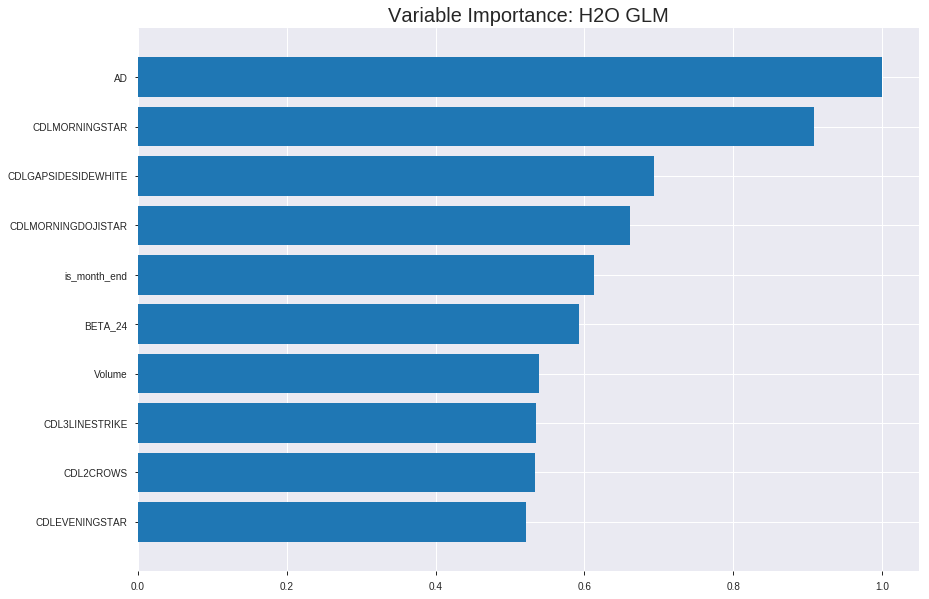

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_143429_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24860519954225208
RMSE: 0.4986032486278565
LogLoss: 0.6903532001425795
Null degrees of freedom: 1530
Residual degrees of freedom: 1480
Null deviance: 2121.0938114372193
Residual deviance: 2113.8614988365784
AIC: 2215.8614988365784
AUC: 0.5821943895990326
pr_auc: 0.5696174186992568
Gini: 0.16438877919806516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47441020001267864: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   759   0.9632   (759.0/788.0)
1      3    740   0.004    (3.0/743.0)
Total  32   1499  0.4977   (762.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47441      0.660125  368
max f2                       0.473045     0.827748  373
max f0point5                 0.482157     0.561003  272
max accuracy                 0.487215     0.557805  164
max precision                0.527067     1         0
max recall                   0.440868     1         395
max specificity              0.527067     1         0
max absolute_mcc             0.483341     0.128414  248
max min_per_class_accuracy   0.485111     0.546433  210
max mean_per_class_accuracy  0.483341     0.561092  248

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.507993           1.80299   1.80299            0.875            0.514619  0.875                       0.514619            0.0188425       0.0188425                  80.2995   80.2995
    2        0.0202482                   0.501772           1.64845   1.72822            0.8              0.505138  0.83871                     0.510031            0.0161507       0.0349933                  64.8452   72.8216
    3        0.0300457                   0.499977           1.23634   1.56782            0.6              0.500751  0.76087                     0.507005            0.0121131       0.0471063                  23.6339   56.7821
    4        0.0404964                   0.497407           1.03028   1.4291             0.5              0.498903  0.693548                    0.504914            0.0107672       0.0578735                  3.02826   42.9102
    5        0.0502939                   0.49569            1.51108   1.44507            0.733333         0.496329  0.701299                    0.503242            0.0148048       0.0726783                  51.1081   44.5072
    6        0.100588                    0.491889           1.25775   1.35141            0.61039          0.493502  0.655844                    0.498372            0.0632571       0.135935                   25.7748   35.141
    7        0.150229                    0.490161           1.0574    1.25426            0.513158         0.49097   0.608696                    0.495926            0.0524899       0.188425                   5.73953   25.4257
    8        0.200523                    0.48879            1.17747   1.235              0.571429         0.489514  0.599349                    0.494318            0.0592194       0.247645                   17.7466   23.4997
    9        0.300457                    0.487223           1.05048   1.17363            0.509804         0.487972  0.569565                    0.492207            0.10498         0.352624                   5.04843   17.3626
    10       0.400392                    0.486089           0.902339  1.10592            0.437908         0.486654  0.536705                    0.490821            0.090175        0.442799                   -9.7661   10.5915
    11       0.500327                    0.485042           1.06395   1.09753            0.51634          0.48559   0.532637                    0.489776            0.106326        0.549125                   6.3952    9.75335
    12       0.600261                    0.483977           1.13129   1.10315            0.54902          0.48453   0.535365                    0.488903            0.113055        0.66218                    13.1291   10.3154
    13       0.700196                    0.482739           0.888871  1.07257            0.431373         0.483363  0.520522                    0.488112            0.0888291       0.751009                   -11.1129  7.25704
    14       0.800131                    0.48126            0.969678  1.05972            0.470588         0.482034  0.514286                    0.487353            0.0969044       0.847914                   -3.03222  5.97193
    15       0.900065                    0.479317           0.821533  1.03327            0.398693         0.480317  0.501451                    0.486572            0.0820996       0.930013                   -17.8467  3.32733
    16       1                           0.435414           0.700323  1                  0.339869         0.473882  0.485304                    0.485304          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25110965834562105
RMSE: 0.5011084297291566
LogLoss: 0.6953691374424982
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 608.2811161936828
Residual deviance: 609.1433643996284
AIC: 711.1433643996284
AUC: 0.5087532603025561
pr_auc: 0.5053909824791106
Gini: 0.017506520605112152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433470793696719: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433471     0.678733  399
max f2                       0.433471     0.840807  399
max f0point5                 0.433471     0.569044  399
max accuracy                 0.483024     0.531963  144
max precision                0.483024     0.564935  144
max recall                   0.433471     1         399
max specificity              0.518384     0.995305  0
max absolute_mcc             0.477115     0.106096  358
max min_per_class_accuracy   0.481898     0.515556  199
max mean_per_class_accuracy  0.483024     0.536056  144

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.500145           0.389333  0.389333           0.2              0.508407  0.2                         0.508407            0.00444444      0.00444444                 -61.0667  -61.0667
    2        0.0205479                   0.496272           0.486667  0.432593           0.25             0.497841  0.222222                    0.503711            0.00444444      0.00888889                 -51.3333  -56.7407
    3        0.0319635                   0.495224           0.778667  0.55619            0.4              0.495684  0.285714                    0.500844            0.00888889      0.0177778                  -22.1333  -44.381
    4        0.0410959                   0.493744           1.46      0.757037           0.75             0.494594  0.388889                    0.499455            0.0133333       0.0311111                  46        -24.2963
    5        0.0502283                   0.491812           1.46      0.884848           0.75             0.493036  0.454545                    0.498288            0.0133333       0.0444444                  46        -11.5152
    6        0.100457                    0.487966           0.884848  0.884848           0.454545         0.489792  0.454545                    0.49404             0.0444444       0.0888889                  -11.5152  -11.5152
    7        0.150685                    0.485593           0.973333  0.914343           0.5              0.486483  0.469697                    0.491521            0.0488889       0.137778                   -2.66667  -8.56566
    8        0.200913                    0.484708           1.1503    0.973333           0.590909         0.485109  0.5                         0.489918            0.0577778       0.195556                   15.0303   -2.66667
    9        0.30137                     0.483484           1.1503    1.03232            0.590909         0.483982  0.530303                    0.487939            0.115556        0.311111                   15.0303   3.23232
    10       0.399543                    0.482665           1.08651   1.04564            0.55814          0.483015  0.537143                    0.486729            0.106667        0.417778                   8.65116   4.56381
    11       0.5                         0.481896           0.973333  1.03111            0.5              0.482301  0.52968                     0.48584             0.0977778       0.515556                   -2.66667  3.11111
    12       0.600457                    0.481022           1.10606   1.04365            0.568182         0.481453  0.536122                    0.485106            0.111111        0.626667                   10.6061   4.36502
    13       0.69863                     0.480268           0.860155  1.01786            0.44186          0.480652  0.522876                    0.48448             0.0844444       0.711111                   -13.9845  1.78649
    14       0.799087                    0.478945           0.929091  1.0067             0.477273         0.479657  0.517143                    0.483874            0.0933333       0.804444                   -7.09091  0.670476
    15       0.899543                    0.477158           0.663636  0.968393           0.340909         0.478124  0.497462                    0.483232            0.0666667       0.871111                   -33.6364  -3.16074
    16       1                           0.433471           1.28303   1                  0.659091         0.472435  0.513699                    0.482147


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:34:29  0.000 sec   2            3.3       51            1.38071           1.39074
    2019-08-26 14:34:29  0.024 sec   4            2.1       51            1.37835           1.39195
    2019-08-26 14:34:29  0.044 sec   6            1.3       51            1.37516           1.39389
    2019-08-26 14:34:29  0.064 sec   8            0.79      51            1.37114           1.39691
    2019-08-26 14:34:29  0.082 sec   10           0.49      51            1.36652           1.40137

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5616438356164384)

('F1', 0.6579804560260587)

('auc', 0.5611120387376858)

('logloss', 0.6925642424142455)

('mean_per_class_error', 0.4373434630155284)

('rmse', 0.499707558880175)

('mse', 0.24970764440198354)

glm prediction progress: |████████████████████████████████████████████████| 100%


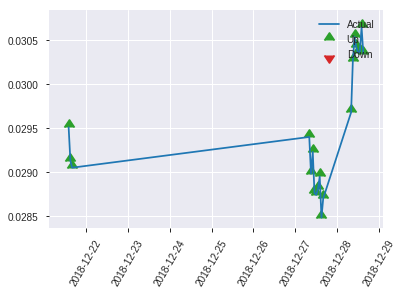


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24970764440198354
RMSE: 0.499707558880175
LogLoss: 0.6925642424142455
Null degrees of freedom: 218
Residual degrees of freedom: 168
Null deviance: 303.37613151001983
Residual deviance: 303.3431381774395
AIC: 405.3431381774395
AUC: 0.5611120387376858
pr_auc: 0.5110811460964971
Gini: 0.12222407747537156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47773898215484945: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   100  0.885    (100.0/113.0)
1      5    101  0.0472   (5.0/106.0)
Total  18   201  0.4795   (105.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477739     0.65798   200
max f2                       0.438594     0.824261  218
max f0point5                 0.480193     0.565693  178
max accuracy                 0.483578     0.561644  109
max precision                0.486923     0.594595  36
max recall                   0.438594     1         218
max specificity              0.520316     0.99115   0
max absolute_mcc             0.480193     0.150419  178
max min_per_class_accuracy   0.483578     0.557522  109
max mean_per_class_accuracy  0.483376     0.562657  115

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.498783           0.688679  0.688679           0.333333         0.50607   0.333333                    0.50607             0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.492145           1.03302   0.826415           0.5              0.495607  0.4                         0.501885            0.00943396      0.0188679                  3.30189   -17.3585
    3        0.0319635                   0.491306           0         0.590296           0                0.491442  0.285714                    0.498901            0               0.0188679                  -100      -40.9704
    4        0.0410959                   0.490215           0         0.459119           0                0.490799  0.222222                    0.4971              0               0.0188679                  -100      -54.0881
    5        0.0502283                   0.489828           2.06604   0.751286           1                0.490064  0.363636                    0.495821            0.0188679       0.0377358                  106.604   -24.8714
    6        0.100457                    0.487924           1.50257   1.12693            0.727273         0.488635  0.545455                    0.492228            0.0754717       0.113208                   50.2573   12.693
    7        0.150685                    0.487106           1.12693   1.12693            0.545455         0.487541  0.545455                    0.490666            0.0566038       0.169811                   12.693    12.693
    8        0.200913                    0.486607           1.12693   1.12693            0.545455         0.486834  0.545455                    0.489708            0.0566038       0.226415                   12.693    12.693
    9        0.30137                     0.485537           0.939108  1.06432            0.454545         0.486047  0.515152                    0.488487            0.0943396       0.320755                   -6.08919  6.43225
    10       0.401826                    0.484365           1.31475   1.12693            0.636364         0.485006  0.545455                    0.487617            0.132075        0.45283                    31.4751   12.693
    11       0.502283                    0.483578           1.12693   1.12693            0.545455         0.483998  0.545455                    0.486893            0.113208        0.566038                   12.693    12.693
    12       0.598174                    0.482546           0.885445  1.08822            0.428571         0.483078  0.526718                    0.486281            0.0849057       0.650943                   -11.4555  8.82183
    13       0.69863                     0.481532           0.751286  1.03977            0.363636         0.482177  0.503268                    0.485691            0.0754717       0.726415                   -24.8714  3.97706
    14       0.799087                    0.480352           1.31475   1.07434            0.636364         0.481012  0.52                        0.485103            0.132075        0.858491                   31.4751   7.43396
    15       0.899543                    0.478144           0.751286  1.03826            0.363636         0.479465  0.502538                    0.484473            0.0754717       0.933962                   -24.8714  3.82626
    16       1                           0.438594           0.657376  1                  0.318182         0.471973  0.484018                    0.483218         

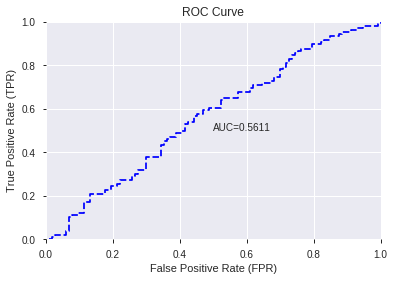

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


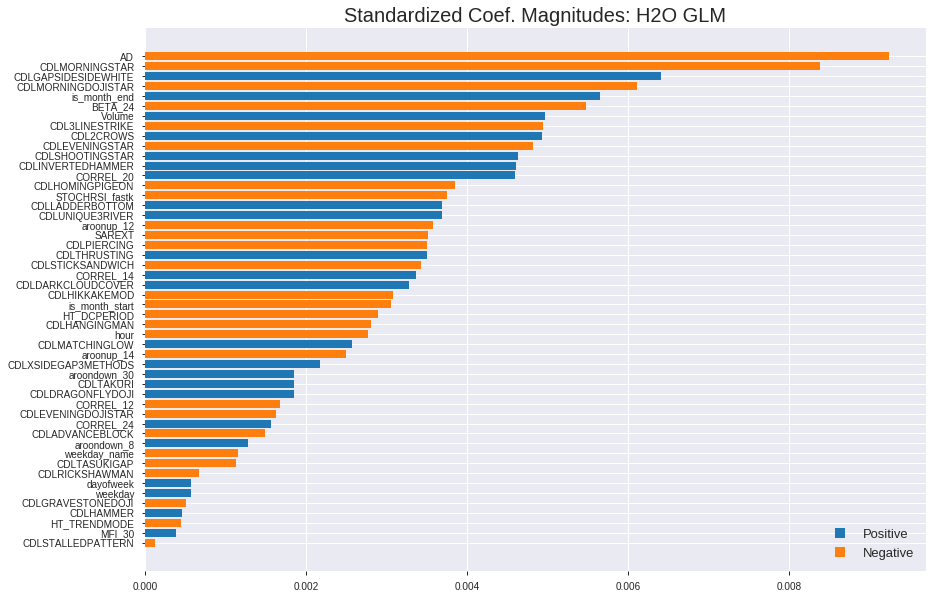

'log_likelihood'
--2019-08-26 14:34:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_143429_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_143429_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['AD',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'BETA_24',
 'Volume',
 'CDL3LINESTRIKE',
 'CDL2CROWS',
 'CDLEVENINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'STOCHRSI_fastk',
 'CDLLADDERBOTTOM',
 'CDLUNIQUE3RIVER',
 'aroonup_12',
 'SAREXT',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'CDLSTICKSANDWICH',
 'CORREL_14',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'is_month_start',
 'HT_DCPERIOD',
 'CDLHANGINGMAN',
 'hour',
 'CDLMATCHINGLOW',
 'aroonup_14',
 'CDLXSIDEGAP3METHODS',
 'aroondown_30',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CORREL_12',
 'CDLEVENINGDOJISTAR',
 'CORREL_24',
 'CDLADVANCEBLOCK',
 'aroondown_8',
 'weekday_name',
 'CDLTASUKIGAP',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'weekday',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'MFI_30',
 'CDLSTALLEDPATTERN']

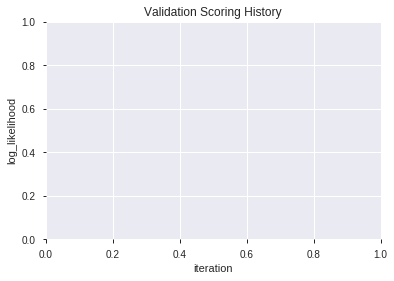

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_143440_model_5  0.501419  0.719437              0.495575  0.511972  0.262115
1               XGBoost_1_AutoML_20190826_143440  0.490900  0.708254              0.464894  0.507288  0.257341
2  XGBoost_grid_1_AutoML_20190826_143440_model_7  0.489982  0.713233              0.495575  0.509544  0.259635
3               XGBoost_2_AutoML_20190826_143440  0.484221  0.706740              0.474328  0.506638  0.256682
4               XGBoost_3_AutoML_20190826_143440  0.481967  0.702361              0.495575  0.504488  0.254508
5  XGBoost_grid_1_AutoML_20190826_143440_model_2  0.478294  0.701755              0.500000  0.504232  0.254249
6  XGBoost_grid_1_AutoML_20190826_143440_model_6  0.458507  0.707131              0.495575  0.506834  0.256881
7  XGBoost_grid_1_AutoML_20190826_143440_model_4  0.450493  0.704123              0.495575  0.505389  0.255418
8  XGBoost_grid_1_AutoML_20190826_143440_model_3  0.441309  0.708054              0.482301  0.507371  0.257425
9  XGBoost_grid_1_AutoML_20190826_143440_model_1  0.438596  0.709982              0.500000  0.508164  0.258230

variable  relative_importance  scaled_importance  percentage
0                Volume          2446.901855           1.000000    0.114082
1                MFI_30          2401.343750           0.981381    0.111958
2               BETA_24          2123.069824           0.867656    0.098984
3                SAREXT          1951.684937           0.797615    0.090994
4                    AD          1854.366821           0.757843    0.086456
5           HT_DCPERIOD          1781.171753           0.727929    0.083044
6                  hour          1360.660278           0.556075    0.063438
7          aroondown_30          1229.524902           0.502482    0.057324
8        STOCHRSI_fastk          1121.869629           0.458486    0.052305
9            aroonup_12          1091.801025           0.446197    0.050903
10          aroondown_8           998.248840           0.407964    0.046541
11           aroonup_14           902.887146           0.368992    0.042095
12            dayofweek           503.675293           0.205842    0.023483
13              weekday           340.180511           0.139025    0.015860
14         weekday_name           289.581329           0.118346    0.013501
15         HT_TRENDMODE           228.550140           0.093404    0.010656
16       CDLRICKSHAWMAN           192.100327           0.078508    0.008956
17         is_month_end            75.340820           0.030790    0.003513
18       CDLMATCHINGLOW            56.051857           0.022907    0.002613
19            CORREL_24            55.668900           0.022751    0.002595
20    CDLINVERTEDHAMMER            45.122864           0.018441    0.002104
21            CORREL_20            44.471188           0.018174    0.002073
22            CDLHAMMER            42.754398           0.017473    0.001993
23       is_month_start            35.191395           0.014382    0.001641
24  CDLXSIDEGAP3METHODS            30.260691           0.012367    0.001411
25    CDLGRAVESTONEDOJI            27.902721           0.011403    0.001301
26       CDLMORNINGSTAR            22.343386           0.009131    0.001042
27      CDLADVANCEBLOCK            21.621496           0.008836    0.001008
28     CDLDRAGONFLYDOJI            18.838688           0.007699    0.000878
29         CDLTASUKIGAP            17.876087           0.007306    0.000833
30      CDLHOMINGPIGEON            17.672815           0.007223    0.000824
31        CDLHANGINGMAN            17.070654           0.006976    0.000796
32   CDLMORNINGDOJISTAR            16.772520           0.006855    0.000782
33            CDLTAKURI            16.196756           0.006619    0.000755
34            CORREL_14            16.103373           0.006581    0.000751
35    CDLDARKCLOUDCOVER            13.791774           0.005636    0.000643
36       CDLEVENINGSTAR             8.220024           0.003359    0.000383
37       CDL3LINESTRIKE             4.779936           0.001953    0.000223
38      CDLLADDERBOTTOM             4.060997           0.001660    0.000189
39        CDLHIKKAKEMOD             3.791193           0.001549    0.000177
40   CDLEVENINGDOJISTAR             2.985973           0.001220    0.000139
41      CDLSHOOTINGSTAR             2.868168           0.001172    0.000134
42            CDL2CROWS             2.797191           0.001143    0.000130
43          CDLPIERCING             2.379679           0.000973    0.000111
44    CDLSTALLEDPATTERN             2.152022           0.000879    0.000100
45         CDLTHRUSTING             2.010800           0.000822    0.000094
46  CDLGAPSIDESIDEWHITE             1.957102           0.000800    0.000091
47            CORREL_12             1.832414           0.000749    0.000085
48     CDLSTICKSANDWICH             0.094371           0.000039    0.000004

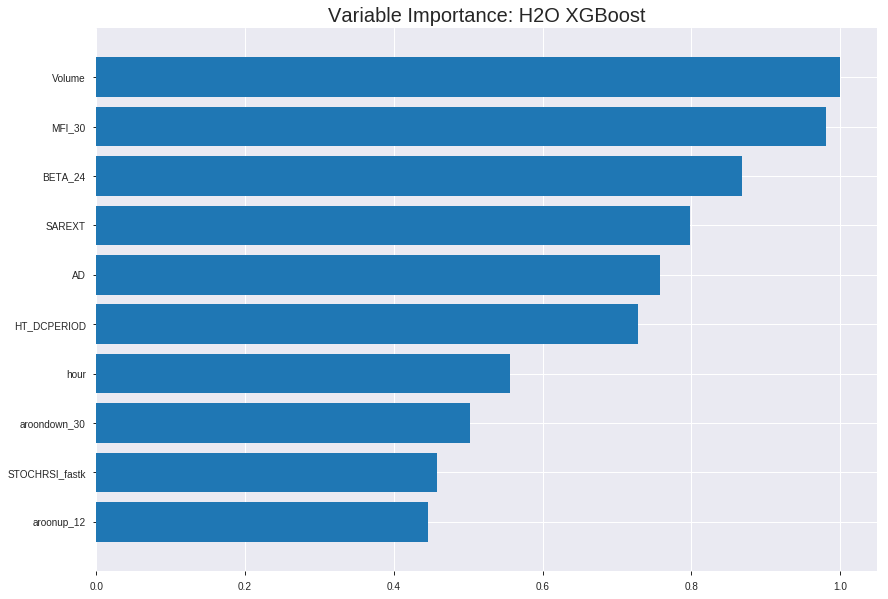

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_143440_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05498432179004146
RMSE: 0.23448735955279434
LogLoss: 0.25829911564658614
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9986541049798116
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49655449390411377: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      788  0    0        (0.0/788.0)
1      0    743  0        (0.0/743.0)
Total  788  743  0        (0.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.496554     1        200
max f2                       0.496554     1        200
max f0point5                 0.496554     1        200
max accuracy                 0.496554     1        200
max precision                0.90813      1        0
max recall                   0.496554     1        200
max specificity              0.90813      1        0
max absolute_mcc             0.496554     1        200
max min_per_class_accuracy   0.496554     1        200
max mean_per_class_accuracy  0.496554     1        200

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0104507                   0.884693           2.06057  2.06057            1                0.892151  1                           0.892151            0.0215343       0.0215343                  106.057  106.057
    2        0.0202482                   0.877897           2.06057  2.06057            1                0.88061   1                           0.886566            0.0201884       0.0417227                  106.057  106.057
    3        0.0300457                   0.866971           2.06057  2.06057            1                0.873229  1                           0.882217            0.0201884       0.0619112                  106.057  106.057
    4        0.0404964                   0.858965           2.06057  2.06057            1                0.863555  1                           0.877401            0.0215343       0.0834455                  106.057  106.057
    5        0.0502939                   0.852655           2.06057  2.06057            1                0.855395  1                           0.873114            0.0201884       0.103634                   106.057  106.057
    6        0.100588                    0.82955            2.06057  2.06057            1                0.838933  1                           0.856023            0.103634        0.207268                   106.057  106.057
    7        0.150229                    0.809162           2.06057  2.06057            1                0.81893   1                           0.843766            0.102288        0.309556                   106.057  106.057
    8        0.200523                    0.791874           2.06057  2.06057            1                0.799966  1                           0.83278             0.103634        0.41319                    106.057  106.057
    9        0.300457                    0.756147           2.06057  2.06057            1                0.774284  1                           0.813324            0.205922        0.619112                   106.057  106.057
    10       0.400392                    0.705707           2.06057  2.06057            1                0.733306  1                           0.793352            0.205922        0.825034                   106.057  106.057
    11       0.500327                    0.365787           1.75081  1.99869            0.849673         0.621849  0.969974                    0.759096            0.174966        1                          75.0807  99.8695
    12       0.600261                    0.265404           0        1.66594            0                0.3022    0.808487                    0.68303             0               1                          -100     66.5941
    13       0.700196                    0.22974            0        1.42817            0                0.246197  0.693097                    0.620683            0               1                          -100     42.8172
    14       0.800131                    0.193869           0        1.2498             0                0.210962  0.606531                    0.56951             0               1                          -100     24.9796
    15       0.900065                    0.159251           0        1.11103            0                0.177732  0.539187                    0.526011            0               1                          -100     11.103
    16       1                           0.0780322          0        1                  0                0.134362  0.485304                    0.486871            0               1                



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25260368585843945
RMSE: 0.5025969417519763
LogLoss: 0.6986614349791298
Mean Per-Class Error: 0.4852895148669797
AUC: 0.48767866458007303
pr_auc: 0.44296179043383405
Gini: -0.024642670839853942
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33297809958457947: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   203  0.9531   (203.0/213.0)
1      4    221  0.0178   (4.0/225.0)
Total  14   424  0.4726   (207.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.332978     0.681048   37
max f2                       0.216222     0.841436   50
max f0point5                 0.332978     0.575221   37
max accuracy                 0.363077     0.527397   35
max precision                0.363077     0.521327   35
max recall                   0.216222     1          50
max specificity              0.692498     0.995305   0
max absolute_mcc             0.332978     0.0828856  37
max min_per_class_accuracy   0.5          0.084507   11
max mean_per_class_accuracy  0.363077     0.51471    35

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.571259           0.778667  0.778667           0.4              0.619131  0.4                         0.619131            0.00888889      0.00888889                 -22.1333   -22.1333
    2        0.0205479                   0.510935           0.486667  0.648889           0.25             0.537562  0.333333                    0.582878            0.00444444      0.0133333                  -51.3333   -35.1111
    3        0.908676                    0.5                1.00086   0.992898           0.514139         0.500017  0.51005                     0.501891            0.888889        0.902222                   0.0856898  -0.710218
    4        1                           0.146525           1.07067   1                  0.55             0.365291  0.513699                    0.489416            0.0977778       1                          7.06667    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:34:56  3.543 sec   0                  0.5              0.693147            0.5             0                  1                0.514696                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-26 14:34:56  3.876 sec   5                  0.453558         0.60398             0.969168        0.968258           2.06057          0.0947093                        0.500054           0.693258              0.527564          0.535453             1.55733            0.486301
    2019-08-26 14:34:57  4.174 sec   10                 0.416415         0.537366            0.992883        0.991171           2.06057          0.0398432                        0.501792           0.696758              0.519249          0.531199             1.55733            0.474886
    2019-08-26 14:34:57  4.461 sec   15                 0.384534         0.483001            0.998201        0.996741           2.06057          0.0215545                        0.506606           0.706679              0.4935            0.496119             0.778667           0.472603
    2019-08-26 14:34:57  4.738 sec   20                 0.352962         0.431781            0.999403        0.996678           2.06057          0.0104507                        0.509626           0.71304               0.486948          0.504534             1.168              0.477169
    2019-08-26 14:34:58  5.030 sec   25                 0.324515         0.387536            0.999912        0.998561           2.06057          0.00457218                       0.513195           0.720594              0.476703          0.499064             1.168              0.477169
    2019-08-26 14:34:58  5.333 sec   30                 0.304244         0.356875            0.999956        0.998608           2.06057          0.00326584                       0.513126           0.720513              0.487491          0.502223             1.55733            0.479452
    2019-08-26 14:34:58  5.651 sec   35                 0.285825         0.329834            0.999982        0.997289           2.06057          0.00130634                       0.514192           0.723067              0.495962          0.499669             0.778667           0.479452
    2019-08-26 14:34:59  5.999 sec   40                 0.265692         0.30121             0.999996        0.99865            2.06057          0.00130634                       0.516736           0.728982              0.492217          0.492905             1.168              0.479452
    2019-08-26 14:34:59  6.350 sec   45                 0.247271         0.27544             0.999997        0.99865            2.06057          0.000653168                      0.517859           0.73165               0.501648          0.496925             0.778667           0.479452
    2019-08-26 14:34:59  6.666 sec   50                 0.234487         0.258299            1               0.998654           2.06057          0                                0.502597           0.698661              0.487679          0.442962             0.778667           0.472603

Variable Importances: 


variable             relative_importance    scaled_importance      percentage
-------------------  ---------------------  ---------------------  ---------------------
Volume               2446.90185546875       1.0                    0.11408212121631005
MFI_30               2401.34375             0.9813813106696826     0.11195806164323995
BETA_24              2123.06982421875       0.8676563056559684     0.09898407183593995
SAREXT               1951.6849365234375     0.7976147192669302     0.09099357908732303
AD                   1854.3668212890625     0.7578427459788017     0.08645630800965493
---                  ---                    ---                    ---
CDLSTALLEDPATTERN    2.152022361755371      0.0008794886304678169  0.000100333928549396
CDLTHRUSTING         2.010800361633301      0.0008217740148176455  9.37497227708404e-05
CDLGAPSIDESIDEWHITE  1.957101583480835      0.0007998283948768821  9.124611989659116e-05
CORREL_12            1.832413673400879      0.0007488709321567152  8.543278445767348e-05
CDLSTICKSANDWICH     0.09437103569507599    3.856756064169866e-05  4.399869128143655e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.54337899543379)

('F1', 0.654320987654321)

('auc', 0.5014192686592085)

('logloss', 0.7194368923671205)

('mean_per_class_error', 0.46915177826014354)

('rmse', 0.5119721256311507)

('mse', 0.2621154574232788)

xgboost prediction progress: |████████████████████████████████████████████| 100%


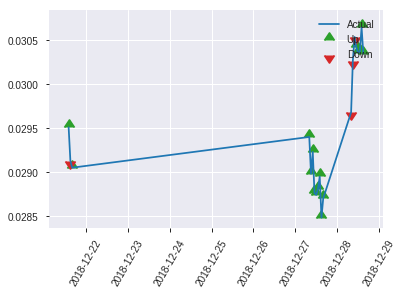


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2621154574232788
RMSE: 0.5119721256311507
LogLoss: 0.7194368923671205
Mean Per-Class Error: 0.46915177826014354
AUC: 0.5014192686592085
pr_auc: 0.49442739972203215
Gini: 0.0028385373184169893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2327072024345398: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    106  0        (0.0/106.0)
Total  1    218  0.5114   (112.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232707     0.654321  217
max f2                       0.232707     0.825545  217
max f0point5                 0.244666     0.543478  214
max accuracy                 0.662771     0.543379  11
max precision                0.662771     0.75      11
max recall                   0.232707     1         217
max specificity              0.800732     0.99115   0
max absolute_mcc             0.662771     0.128147  11
max min_per_class_accuracy   0.501097     0.490566  105
max mean_per_class_accuracy  0.519842     0.530848  85

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.717719           0.688679  0.688679           0.333333         0.74938   0.333333                    0.74938             0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.706688           1.03302   0.826415           0.5              0.710076  0.4                         0.733659            0.00943396      0.0188679                  3.30189   -17.3585
    3        0.0319635                   0.69309            2.06604   1.18059            1                0.700505  0.571429                    0.724186            0.0188679       0.0377358                  106.604   18.0593
    4        0.0410959                   0.682465           2.06604   1.37736            1                0.689546  0.666667                    0.716488            0.0188679       0.0566038                  106.604   37.7358
    5        0.0502283                   0.663426           2.06604   1.50257            1                0.67462   0.727273                    0.708876            0.0188679       0.0754717                  106.604   50.2573
    6        0.100457                    0.624902           0.563465  1.03302            0.272727         0.644991  0.5                         0.676933            0.0283019       0.103774                   -43.6535  3.30189
    7        0.150685                    0.592493           1.12693   1.06432            0.545455         0.606457  0.515152                    0.653441            0.0566038       0.160377                   12.693    6.43225
    8        0.200913                    0.573974           0.751286  0.986063           0.363636         0.585281  0.477273                    0.636401            0.0377358       0.198113                   -24.8714  -1.39365
    9        0.30137                     0.553815           0.939108  0.970412           0.454545         0.562415  0.469697                    0.611739            0.0943396       0.292453                   -6.08919  -2.95883
    10       0.401826                    0.516974           1.31475   1.0565             0.636364         0.533199  0.511364                    0.592104            0.132075        0.424528                   31.4751   5.64966
    11       0.502283                    0.495655           0.657376  0.976672           0.318182         0.506392  0.472727                    0.574962            0.0660377       0.490566                   -34.2624  -2.33276
    12       0.598174                    0.468846           0.983827  0.977819           0.47619          0.485102  0.473282                    0.560557            0.0943396       0.584906                   -1.61725  -2.21806
    13       0.69863                     0.426054           1.22084   1.01276            0.590909         0.450622  0.490196                    0.544749            0.122642        0.707547                   22.084    1.27636
    14       0.799087                    0.374298           1.12693   1.02712            0.545455         0.394368  0.497143                    0.525844            0.113208        0.820755                   12.693    2.71159
    15       0.899543                    0.327242           0.751286  0.996313           0.363636         0.35335   0.482234                    0.506581            0.0754717       0.896226                   -24.8714  -0.368739
    16       1                           0.207358           1.03302   1                  0.5              0.281288  0.484018                    0.483949 

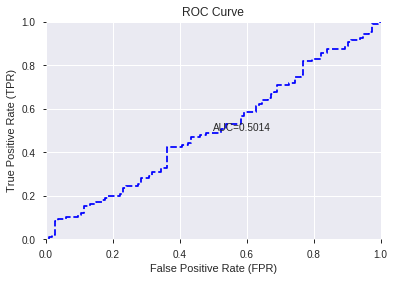

This function is available for GLM models only


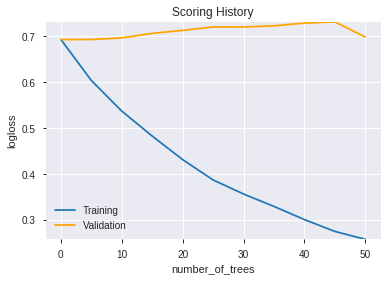

--2019-08-26 14:35:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_143440_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_143440_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'MFI_30',
 'BETA_24',
 'SAREXT',
 'AD',
 'HT_DCPERIOD',
 'hour',
 'aroondown_30',
 'STOCHRSI_fastk',
 'aroonup_12',
 'aroondown_8',
 'aroonup_14',
 'dayofweek',
 'weekday',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'is_month_end',
 'CDLMATCHINGLOW',
 'CORREL_24',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLHAMMER',
 'is_month_start',
 'CDLXSIDEGAP3METHODS',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLHANGINGMAN',
 'CDLMORNINGDOJISTAR',
 'CDLTAKURI',
 'CORREL_14',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM',
 'CDLHIKKAKEMOD',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDL2CROWS',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_12',
 'CDLSTICKSANDWICH']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_143512_model_1  0.544415  0.691557              0.433002  0.499204  0.249204

variable  relative_importance  scaled_importance    percentage
0               CDLMORNINGSTAR         7.733173e-03           1.000000  1.229907e-02
1                         DX_8         6.982275e-03           0.902899  1.110482e-02
2               CDLSPINNINGTOP         6.817615e-03           0.881606  1.084294e-02
3                           AD         6.791099e-03           0.878178  1.080076e-02
4                  CDL3OUTSIDE         6.438814e-03           0.832623  1.024048e-02
...                        ...                  ...                ...           ...
1031                    TRANGE         1.430673e-06           0.000185  2.275385e-06
1032   BBANDS_lowerband_30_0_2         1.192655e-06           0.000154  1.896833e-06
1033   BBANDS_lowerband_24_3_2         8.077570e-07           0.000104  1.284680e-06
1034  BBANDS_middleband_12_5_2         5.219642e-07           0.000067  8.301472e-07
1035    BBANDS_upperband_8_4_5         3.939189e-07           0.000051  6.265002e-07

[1036 rows x 4 columns]

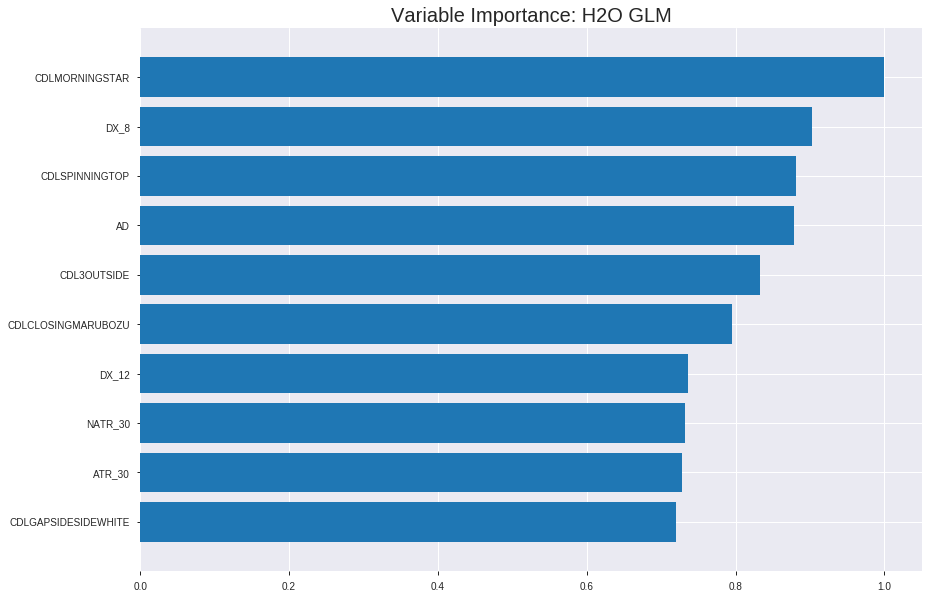

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_143512_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24589404065166098
RMSE: 0.49587704186790194
LogLoss: 0.6849084067405206
Null degrees of freedom: 1530
Residual degrees of freedom: 494
Null deviance: 2121.0938114372193
Residual deviance: 2097.189541439474
AIC: 4171.189541439474
AUC: 0.5975483531573877
pr_auc: 0.5774312614373639
Gini: 0.1950967063147755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43920226372179877: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   759   0.9632   (759.0/788.0)
1      8    735   0.0108   (8.0/743.0)
Total  37   1494  0.501    (767.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439202     0.65713   376
max f2                       0.42988      0.825739  395
max f0point5                 0.476384     0.569204  248
max accuracy                 0.483699     0.570869  214
max precision                0.618125     1         0
max recall                   0.42988      1         395
max specificity              0.618125     1         0
max absolute_mcc             0.476384     0.151078  248
max min_per_class_accuracy   0.483699     0.569314  214
max mean_per_class_accuracy  0.476384     0.573245  248

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104507                   0.562014           1.54542   1.54542            0.75             0.582612  0.75                        0.582612            0.0161507       0.0161507                  54.5424    54.5424
    2        0.0202482                   0.549959           1.37371   1.46234            0.666667         0.555628  0.709677                    0.569555            0.013459        0.0296097                  37.371     46.2337
    3        0.0300457                   0.54043            1.64845   1.52303            0.8              0.545061  0.73913                     0.561568            0.0161507       0.0457604                  64.8452    52.3027
    4        0.0404964                   0.533861           1.80299   1.59528            0.875            0.53754   0.774194                    0.555367            0.0188425       0.064603                   80.2995    59.5276
    5        0.0502939                   0.528672           1.23634   1.52535            0.6              0.530934  0.74026                     0.550607            0.0121131       0.076716                   23.6339    52.5354
    6        0.100588                    0.516292           1.23099   1.37817            0.597403         0.522132  0.668831                    0.53637             0.0619112       0.138627                   23.0987    37.817
    7        0.150229                    0.509285           1.11162   1.29009            0.539474         0.512502  0.626087                    0.528483            0.0551817       0.193809                   11.1621    29.0093
    8        0.200523                    0.504245           1.07042   1.235              0.519481         0.50653   0.599349                    0.522977            0.0538358       0.247645                   7.04235    23.4997
    9        0.300457                    0.495913           1.14476   1.20498            0.555556         0.500012  0.584783                    0.515339            0.114401        0.362046                   14.4758    20.4983
    10       0.400392                    0.488815           1.05048   1.16642            0.509804         0.492295  0.566069                    0.509587            0.10498         0.467026                   5.04843    16.6421
    11       0.500327                    0.483402           1.05048   1.14326            0.509804         0.486069  0.55483                     0.50489             0.10498         0.572005                   5.04843    14.3264
    12       0.600261                    0.477722           0.996613  1.11885            0.48366          0.480559  0.542982                    0.500839            0.0995962       0.671602                   -0.338673  11.8849
    13       0.700196                    0.471371           0.875404  1.0841             0.424837         0.474557  0.526119                    0.497088            0.0874832       0.759085                   -12.4596   8.41034
    14       0.800131                    0.464711           0.969678  1.06981            0.470588         0.467808  0.519184                    0.493431            0.0969044       0.855989                   -3.03222   6.98118
    15       0.900065                    0.454964           0.754194  1.03477            0.366013         0.460152  0.502177                    0.489736            0.0753701       0.931359                   -24.5806   3.47686
    16       1                           0.419632           0.686855  1                  0.333333         0.445384  0.485304                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2518120562398155
RMSE: 0.5018087845383095
LogLoss: 0.6968016400163507
Null degrees of freedom: 437
Residual degrees of freedom: -599
Null deviance: 608.2811161936828
Residual deviance: 610.3982366543233
AIC: 2684.3982366543232
AUC: 0.48881585811163275
pr_auc: 0.5106048899293845
Gini: -0.0223682837767345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43922876366510516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    225  0        (0.0/225.0)
Total  1    437  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.439229     0.679758   398
max f2                       0.439229     0.841436   398
max f0point5                 0.445051     0.570917   393
max accuracy                 0.473341     0.520548   299
max precision                0.673206     1          0
max recall                   0.439229     1          398
max specificity              0.673206     1          0
max absolute_mcc             0.65422      0.0808006  2
max min_per_class_accuracy   0.492191     0.483568   200
max mean_per_class_accuracy  0.535032     0.515524   43

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.641405           1.168     1.168              0.6              0.657781  0.6                         0.657781            0.0133333       0.0133333                  16.8       16.8
    2        0.0205479                   0.609925           0.486667  0.865185           0.25             0.632101  0.444444                    0.646368            0.00444444      0.0177778                  -51.3333   -13.4815
    3        0.0319635                   0.562341           1.168     0.973333           0.6              0.58884   0.5                         0.625822            0.0133333       0.0311111                  16.8       -2.66667
    4        0.0410959                   0.55456            0.486667  0.865185           0.25             0.556796  0.444444                    0.610483            0.00444444      0.0355556                  -51.3333   -13.4815
    5        0.0502283                   0.54922            1.46      0.973333           0.75             0.551482  0.5                         0.599756            0.0133333       0.0488889                  46         -2.66667
    6        0.100457                    0.5348             1.32727   1.1503             0.681818         0.541081  0.590909                    0.570418            0.0666667       0.115556                   32.7273    15.0303
    7        0.150685                    0.526255           0.796364  1.03232            0.409091         0.530717  0.530303                    0.557184            0.04            0.155556                   -20.3636   3.23232
    8        0.200913                    0.521443           1.06182   1.0397             0.545455         0.524092  0.534091                    0.548911            0.0533333       0.208889                   6.18182    3.9697
    9        0.30137                     0.511356           0.796364  0.958586           0.409091         0.515941  0.492424                    0.537921            0.08            0.288889                   -20.3636   -4.14141
    10       0.399543                    0.499355           0.995969  0.967771           0.511628         0.504487  0.497143                    0.529706            0.0977778       0.386667                   -0.403101  -3.22286
    11       0.5                         0.492138           0.973333  0.968889           0.5              0.495402  0.497717                    0.522814            0.0977778       0.484444                   -2.66667   -3.11111
    12       0.600457                    0.483059           0.929091  0.962231           0.477273         0.488091  0.494297                    0.517005            0.0933333       0.577778                   -7.09091   -3.77693
    13       0.69863                     0.476593           1.22233   0.99878            0.627907         0.479066  0.513072                    0.511673            0.12            0.697778                   22.2326    -0.122004
    14       0.799087                    0.469781           0.973333  0.995581           0.5              0.473375  0.511429                    0.506859            0.0977778       0.795556                   -2.66667   -0.441905
    15       0.899543                    0.459538           0.973333  0.993096           0.5              0.465463  0.510152                    0.502236            0.0977778       0.893333                   -2.66667   -0.690355
    16       1                           0.435478           1.06182   1                  0.545455         0.451327  0.513699          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:35:15  0.000 sec   2            3.7       1037          1.36982           1.3936
    2019-08-26 14:35:17  1.727 sec   4            2.7       1037          1.36635           1.39468
    2019-08-26 14:35:19  3.488 sec   6            2         1037          1.36235           1.39669
    2019-08-26 14:35:20  5.250 sec   8            1.4       1037          1.35784           1.39926
    2019-08-26 14:35:22  7.004 sec   10           1         1037          1.35277           1.40274

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5570776255707762)

('F1', 0.6572438162544171)

('auc', 0.5444147603940558)

('logloss', 0.6915571228249207)

('mean_per_class_error', 0.4330021706461846)

('rmse', 0.4992035665387303)

('mse', 0.24920420084498854)

glm prediction progress: |████████████████████████████████████████████████| 100%


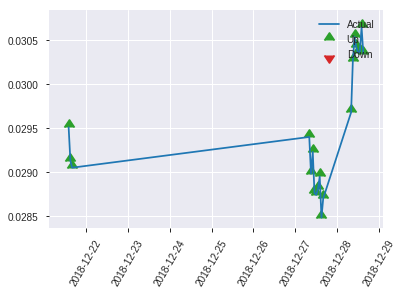


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24920420084498854
RMSE: 0.4992035665387303
LogLoss: 0.6915571228249207
Null degrees of freedom: 218
Residual degrees of freedom: -818
Null deviance: 303.37613151001983
Residual deviance: 302.90201979731523
AIC: 2376.902019797315
AUC: 0.5444147603940558
pr_auc: 0.5152079416389065
Gini: 0.08882952078811157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4887182315392386: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   84   0.7434   (84.0/113.0)
1      13   93   0.1226   (13.0/106.0)
Total  42   177  0.4429   (97.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488718     0.657244  176
max f2                       0.451977     0.824261  218
max f0point5                 0.488718     0.571253  176
max accuracy                 0.488718     0.557078  176
max precision                0.540048     0.666667  2
max recall                   0.451977     1         218
max specificity              0.55434      0.99115   0
max absolute_mcc             0.488718     0.170087  176
max min_per_class_accuracy   0.50477      0.513274  109
max mean_per_class_accuracy  0.488718     0.566998  176

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.539519           1.37736   1.37736            0.666667         0.544985  0.666667                    0.544985            0.0188679       0.0188679                  37.7358   37.7358
    2        0.0228311                   0.537004           0         0.826415           0                0.537091  0.4                         0.541828            0               0.0188679                  -100      -17.3585
    3        0.0319635                   0.533655           0         0.590296           0                0.535927  0.285714                    0.540142            0               0.0188679                  -100      -40.9704
    4        0.0410959                   0.530834           2.06604   0.918239           1                0.532167  0.444444                    0.53837             0.0188679       0.0377358                  106.604   -8.1761
    5        0.0502283                   0.529855           2.06604   1.12693            1                0.530383  0.545455                    0.536918            0.0188679       0.0566038                  106.604   12.693
    6        0.100457                    0.523235           1.50257   1.31475            0.727273         0.52604   0.636364                    0.531479            0.0754717       0.132075                   50.2573   31.4751
    7        0.150685                    0.521167           0.751286  1.12693            0.363636         0.522159  0.545455                    0.528372            0.0377358       0.169811                   -24.8714  12.693
    8        0.200913                    0.518659           1.31475   1.17389            0.636364         0.519866  0.568182                    0.526246            0.0660377       0.235849                   31.4751   17.3885
    9        0.30137                     0.51387            1.03302   1.12693            0.5              0.516054  0.545455                    0.522849            0.103774        0.339623                   3.30189   12.693
    10       0.401826                    0.508855           0.751286  1.03302            0.363636         0.510943  0.5                         0.519872            0.0754717       0.415094                   -24.8714  3.30189
    11       0.502283                    0.50477            1.03302   1.03302            0.5              0.506662  0.5                         0.51723             0.103774        0.518868                   3.30189   3.30189
    12       0.598174                    0.501019           1.08221   1.0409             0.52381          0.503083  0.503817                    0.514962            0.103774        0.622642                   8.22102   4.09045
    13       0.69863                     0.494818           1.12693   1.05327            0.545455         0.498237  0.509804                    0.512557            0.113208        0.735849                   12.693    5.32741
    14       0.799087                    0.489351           1.22084   1.07434            0.590909         0.49188   0.52                        0.509958            0.122642        0.858491                   22.084    7.43396
    15       0.899543                    0.480987           0.469554  1.0068             0.227273         0.485256  0.48731                     0.507199            0.0471698       0.90566                    -53.0446  0.680011
    16       1                           0.451977           0.939108  1                  0.454545         0.472955  0.484018                    0.503759         

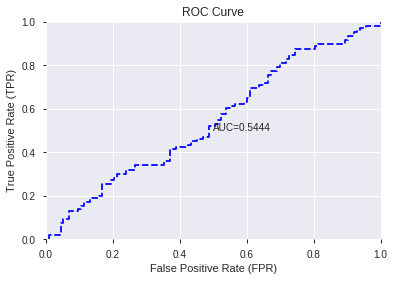

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


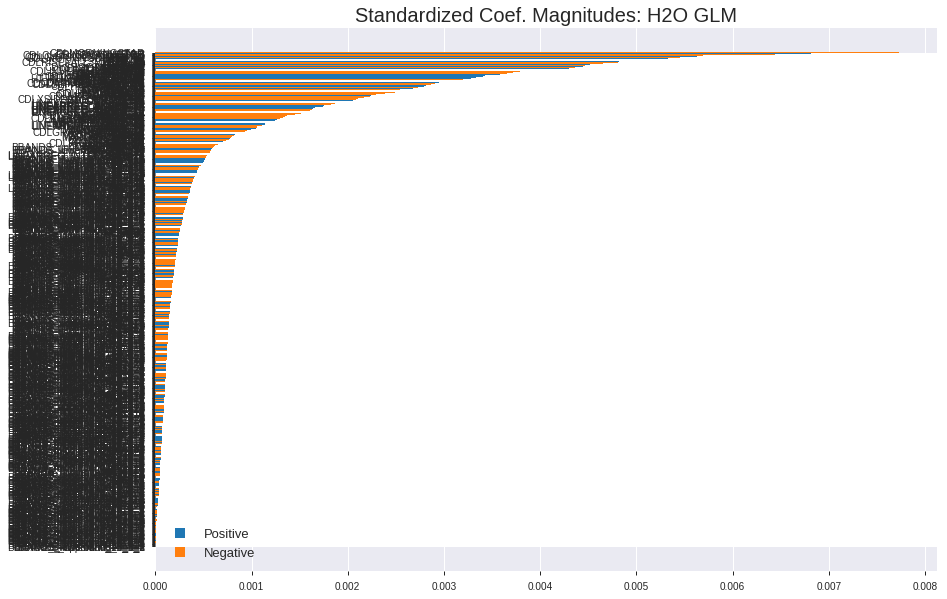

'log_likelihood'
--2019-08-26 14:35:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.192
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.192|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_143512_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_143512_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

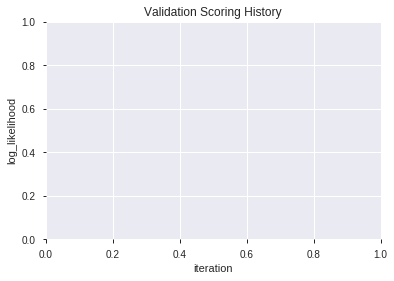

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_143549  0.533729  0.694340              0.500000  0.500481  0.250482
1  XGBoost_grid_1_AutoML_20190826_143549_model_7  0.523961  0.702455              0.436258  0.504325  0.254344
2  XGBoost_grid_1_AutoML_20190826_143549_model_1  0.520538  0.696723              0.495575  0.501614  0.251617
3  XGBoost_grid_1_AutoML_20190826_143549_model_6  0.516864  0.698388              0.500000  0.502445  0.252451
4  XGBoost_grid_1_AutoML_20190826_143549_model_5  0.515111  0.713182              0.500000  0.509315  0.259401
5               XGBoost_1_AutoML_20190826_143549  0.498915  0.706709              0.486726  0.506599  0.256642
6  XGBoost_grid_1_AutoML_20190826_143549_model_3  0.496327  0.702952              0.500000  0.504692  0.254714
7  XGBoost_grid_1_AutoML_20190826_143549_model_4  0.493238  0.698905              0.500000  0.502752  0.252759
8               XGBoost_2_AutoML_20190826_143549  0.484555  0.708279              0.491150  0.507179  0.257230
9  XGBoost_grid_1_AutoML_20190826_143549_model_2  0.471281  0.703511              0.491443  0.505019  0.255044

variable  relative_importance  scaled_importance  percentage
0                      DX_14           144.949783           1.000000    0.026203
1                    BETA_30           135.301590           0.933438    0.024459
2                        BOP           127.532219           0.879837    0.023054
3                     CCI_20           113.672874           0.784222    0.020549
4                     ULTOSC           109.007294           0.752035    0.019705
..                       ...                  ...                ...         ...
296                      Low             0.867115           0.005982    0.000157
297                   ROCP_8             0.499344           0.003445    0.000090
298                   ROCR_8             0.108827           0.000751    0.000020
299             HT_TRENDMODE             0.056166           0.000387    0.000010
300  BBANDS_upperband_24_1_2             0.050107           0.000346    0.000009

[301 rows x 4 columns]

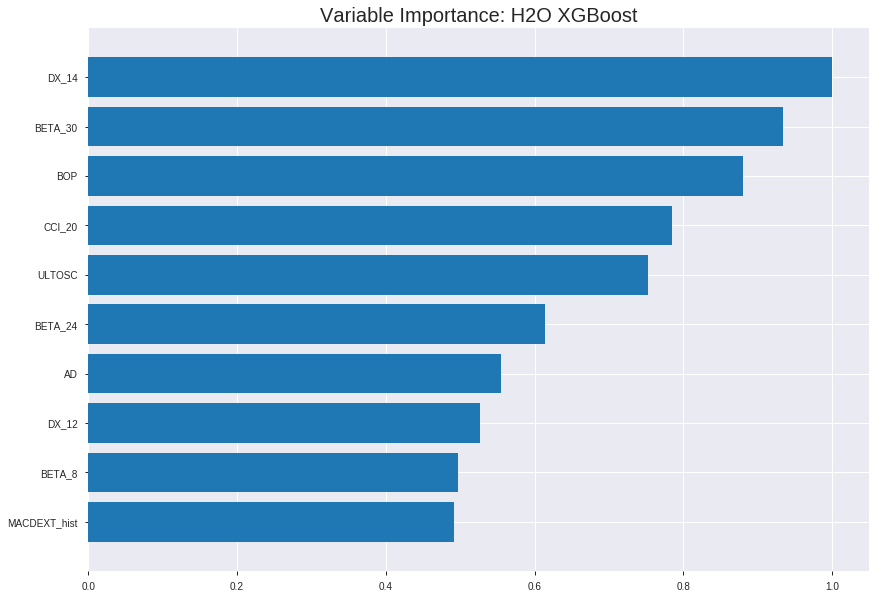

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_143549


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16827355952133752
RMSE: 0.4102116033480008
LogLoss: 0.5236439298097123
Mean Per-Class Error: 0.12311352658655061
AUC: 0.9504316087203066
pr_auc: 0.9492551651997417
Gini: 0.9008632174406133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47179600099722546: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      658  130  0.165    (130.0/788.0)
1      63   680  0.0848   (63.0/743.0)
Total  721  810  0.1261   (193.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471796     0.875724  214
max f2                       0.443755     0.916217  240
max f0point5                 0.522374     0.88647   170
max accuracy                 0.4855       0.876551  203
max precision                0.793877     1         0
max recall                   0.337209     1         331
max specificity              0.793877     1         0
max absolute_mcc             0.4855       0.753447  203
max min_per_class_accuracy   0.49003      0.871827  199
max mean_per_class_accuracy  0.4855       0.876886  203

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.743513           2.06057    2.06057            1                0.762347  1                           0.762347            0.0215343       0.0215343                  106.057   106.057
    2        0.0202482                   0.726175           2.06057    2.06057            1                0.733588  1                           0.748431            0.0201884       0.0417227                  106.057   106.057
    3        0.0300457                   0.717735           2.06057    2.06057            1                0.721939  1                           0.739792            0.0201884       0.0619112                  106.057   106.057
    4        0.0404964                   0.705557           2.06057    2.06057            1                0.710829  1                           0.732318            0.0215343       0.0834455                  106.057   106.057
    5        0.0502939                   0.698957           2.06057    2.06057            1                0.70259   1                           0.726527            0.0201884       0.103634                   106.057   106.057
    6        0.100588                    0.656872           2.06057    2.06057            1                0.675825  1                           0.701176            0.103634        0.207268                   106.057   106.057
    7        0.150229                    0.633091           2.06057    2.06057            1                0.644359  1                           0.682402            0.102288        0.309556                   106.057   106.057
    8        0.200523                    0.609976           2.06057    2.06057            1                0.621493  1                           0.667125            0.103634        0.41319                    106.057   106.057
    9        0.300457                    0.564311           1.88548    2.00233            0.915033         0.587354  0.971739                    0.640593            0.188425        0.601615                   88.5485   100.233
    10       0.400392                    0.523086           1.58919    1.89922            0.771242         0.543955  0.921697                    0.616473            0.158816        0.760431                   58.9194   89.9216
    11       0.500327                    0.485342           1.27944    1.77542            0.620915         0.505348  0.861619                    0.594277            0.12786         0.888291                   27.9436   77.5422
    12       0.600261                    0.443569           0.713791   1.59868            0.346405         0.462433  0.775843                    0.572327            0.0713324       0.959623                   -28.6209  59.8676
    13       0.700196                    0.402458           0.228952   1.40318            0.111111         0.423055  0.68097                     0.551022            0.0228802       0.982503                   -77.1048  40.3183
    14       0.800131                    0.368465           0.134677   1.24475            0.0653595        0.386474  0.604082                    0.53047             0.013459        0.995962                   -86.5323  24.475
    15       0.900065                    0.318623           0.0404032  1.11103            0.0196078        0.343476  0.539187                    0.509708            0.00403769      1                          -95.9597  11.103
    16       1                           0.203607           0          1                  0                0.274216  0.485304                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2586105243150556
RMSE: 0.5085376331354993
LogLoss: 0.7111305952755178
Mean Per-Class Error: 0.48184663536776207
AUC: 0.4959207094418362
pr_auc: 0.5162475520550737
Gini: -0.008158581116327612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27272963523864746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    225  0        (0.0/225.0)
Total  1    437  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.27273      0.679758   398
max f2                       0.27273      0.841436   398
max f0point5                 0.27273      0.570198   398
max accuracy                 0.349053     0.515982   368
max precision                0.688936     0.75       3
max recall                   0.27273      1          398
max specificity              0.722229     0.995305   0
max absolute_mcc             0.657284     0.0644867  7
max min_per_class_accuracy   0.484446     0.507042   195
max mean_per_class_accuracy  0.514613     0.518153   133

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.671292           1.168     1.168              0.6              0.695255  0.6                         0.695255            0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   0.649429           1.46      1.29778            0.75             0.657431  0.666667                    0.678444            0.0133333       0.0266667                  46        29.7778
    3        0.0319635                   0.633242           0.778667  1.11238            0.4              0.640287  0.571429                    0.664817            0.00888889      0.0355556                  -22.1333  11.2381
    4        0.0410959                   0.62272            0.973333  1.08148            0.5              0.629572  0.555556                    0.656984            0.00888889      0.0444444                  -2.66667  8.14815
    5        0.0502283                   0.611392           0.486667  0.973333           0.25             0.614803  0.5                         0.649315            0.00444444      0.0488889                  -51.3333  -2.66667
    6        0.100457                    0.585624           0.973333  0.973333           0.5              0.596572  0.5                         0.622944            0.0488889       0.0977778                  -2.66667  -2.66667
    7        0.150685                    0.564856           0.973333  0.973333           0.5              0.575735  0.5                         0.607207            0.0488889       0.146667                   -2.66667  -2.66667
    8        0.200913                    0.546559           0.884848  0.951212           0.454545         0.556112  0.488636                    0.594433            0.0444444       0.191111                   -11.5152  -4.87879
    9        0.30137                     0.519762           1.10606   1.00283            0.568182         0.534644  0.515152                    0.574504            0.111111        0.302222                   10.6061   0.282828
    10       0.399543                    0.504855           1.13178   1.03451            0.581395         0.512171  0.531429                    0.559188            0.111111        0.413333                   13.1783   3.45143
    11       0.5                         0.485016           0.929091  1.01333            0.477273         0.494164  0.520548                    0.546123            0.0933333       0.506667                   -7.09091  1.33333
    12       0.600457                    0.462764           0.884848  0.991838           0.454545         0.473691  0.509506                    0.534005            0.0888889       0.595556                   -11.5152  -0.816223
    13       0.69863                     0.443751           0.860155  0.973333           0.44186          0.453562  0.5                         0.522701            0.0844444       0.68                       -13.9845  -2.66667
    14       0.799087                    0.41317            1.01758   0.978895           0.522727         0.43148   0.502857                    0.511234            0.102222        0.782222                   1.75758   -2.11048
    15       0.899543                    0.365403           1.10606   0.993096           0.568182         0.393778  0.510152                    0.498117            0.111111        0.893333                   10.6061   -0.690355
    16       1                           0.233894           1.06182   1                  0.545455         0.326305  0.513699                    0.480857 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:35:59  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.514696                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-26 14:36:00  0.642 sec   5                  0.487537         0.668473            0.78685         0.767489           2.06057          0.322012                         0.500123           0.693401              0.516234          0.55563              1.94667            0.486301
    2019-08-26 14:36:00  0.838 sec   10                 0.475514         0.645101            0.843402        0.831646           2.06057          0.242978                         0.501876           0.69696               0.504778          0.518671             1.168              0.484018
    2019-08-26 14:36:00  1.028 sec   15                 0.466016         0.626846            0.867293        0.858174           2.06057          0.22469                          0.503742           0.700808              0.495764          0.505381             1.168              0.484018
    2019-08-26 14:36:01  1.230 sec   20                 0.455613         0.607073            0.884537        0.878429           2.06057          0.200523                         0.505517           0.70456               0.503495          0.50886              0.389333           0.484018
    2019-08-26 14:36:01  1.430 sec   25                 0.44576          0.588655            0.905581        0.902008           2.06057          0.181581                         0.50747            0.70878               0.498508          0.510529             0.778667           0.484018
    2019-08-26 14:36:01  1.633 sec   30                 0.437528         0.573368            0.917287        0.913792           2.06057          0.158067                         0.507165           0.708197              0.500939          0.514105             0.778667           0.484018
    2019-08-26 14:36:01  1.821 sec   35                 0.430007         0.559482            0.927712        0.925592           2.06057          0.151535                         0.507585           0.709261              0.505832          0.522727             1.168              0.484018
    2019-08-26 14:36:01  2.009 sec   40                 0.423707         0.547975            0.934923        0.93321            2.06057          0.137165                         0.508549           0.711311              0.498519          0.515941             1.168              0.484018
    2019-08-26 14:36:02  2.215 sec   45                 0.416196         0.534499            0.94609         0.944227           2.06057          0.12998                          0.5089             0.711952              0.49373           0.511474             1.168              0.484018
    2019-08-26 14:36:02  2.415 sec   50                 0.410212         0.523644            0.950432        0.949255           2.06057          0.126061                         0.508538           0.711131              0.495921          0.516248             1.168              0.484018

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
DX_14                    144.9497833251953      1.0                     0.026202699813876514
BETA_30                  135.3015899658203      0.9334376834649746      0.024458587414793013
BOP                      127.53221893310547     0.8798372512705763      0.023054111380109155
CCI_20                   113.6728744506836      0.7842224516863067      0.02054874548883857
ULTOSC                   109.00729370117188     0.7520348854652211      0.019705344353408195
---                      ---                    ---                     ---
Low                      0.8671150207519531     0.005982175349697335    0.000156749144922091
ROCP_8                   0.4993438720703125     0.003444943901365019    9.026683092311221e-05
ROCR_8                   0.10882711410522461    0.0007507918370672595   1.9672773129382286e-05
HT_TRENDMODE             0.05616569519042969    0.00038748381613252754  1.0153122116855942e-05
BBANDS_upperband_24_1_2  0.050107479095458984   0.00034568854085861373  9.057973065215242e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5570776255707762)

('F1', 0.6523076923076924)

('auc', 0.5337285022541326)

('logloss', 0.6943402006939793)

('mean_per_class_error', 0.4514109200200367)

('rmse', 0.5004813760883773)

('mse', 0.2504816078113158)

xgboost prediction progress: |████████████████████████████████████████████| 100%


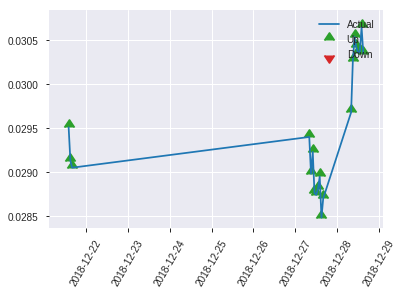


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2504816078113158
RMSE: 0.5004813760883773
LogLoss: 0.6943402006939793
Mean Per-Class Error: 0.4514109200200367
AUC: 0.5337285022541326
pr_auc: 0.5266887557802747
Gini: 0.0674570045082652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30119988322257996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    106  0        (0.0/106.0)
Total  0    219  0.516    (113.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3012       0.652308  218
max f2                       0.3012       0.824261  218
max f0point5                 0.436715     0.549872  168
max accuracy                 0.573292     0.557078  18
max precision                0.660213     1         0
max recall                   0.3012       1         218
max specificity              0.660213     1         0
max absolute_mcc             0.573292     0.155931  18
max min_per_class_accuracy   0.480509     0.537736  108
max mean_per_class_accuracy  0.530248     0.548589  50

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.635224           0.688679  0.688679           0.333333         0.651048  0.333333                    0.651048            0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.624149           2.06604   1.23962            1                0.629894  0.6                         0.642586            0.0188679       0.0283019                  106.604   23.9623
    3        0.0319635                   0.613757           2.06604   1.47574            1                0.61894   0.714286                    0.63583             0.0188679       0.0471698                  106.604   47.5741
    4        0.0410959                   0.600823           2.06604   1.60692            1                0.608567  0.777778                    0.629772            0.0188679       0.0660377                  106.604   60.6918
    5        0.0502283                   0.588816           1.03302   1.50257            0.5              0.594605  0.727273                    0.623378            0.00943396      0.0754717                  3.30189   50.2573
    6        0.100457                    0.565183           1.12693   1.31475            0.545455         0.576652  0.636364                    0.600015            0.0566038       0.132075                   12.693    31.4751
    7        0.150685                    0.545463           1.12693   1.25214            0.545455         0.556656  0.606061                    0.585562            0.0566038       0.188679                   12.693    25.2144
    8        0.200913                    0.535232           1.12693   1.22084            0.545455         0.540374  0.590909                    0.574265            0.0566038       0.245283                   12.693    22.084
    9        0.30137                     0.521113           0.563465  1.00172            0.272727         0.528249  0.484848                    0.558926            0.0566038       0.301887                   -43.6535  0.171527
    10       0.401826                    0.497001           0.939108  0.986063           0.454545         0.509496  0.477273                    0.546569            0.0943396       0.396226                   -6.08919  -1.39365
    11       0.502283                    0.48038            1.40866   1.07058            0.681818         0.487609  0.518182                    0.534777            0.141509        0.537736                   40.8662   7.05832
    12       0.598174                    0.470479           0.885445  1.0409             0.428571         0.475126  0.503817                    0.525215            0.0849057       0.622642                   -11.4555  4.09045
    13       0.69863                     0.449894           1.12693   1.05327            0.545455         0.458521  0.509804                    0.515625            0.113208        0.735849                   12.693    5.32741
    14       0.799087                    0.428702           0.845197  1.02712            0.409091         0.441255  0.497143                    0.506275            0.0849057       0.820755                   -15.4803  2.71159
    15       0.899543                    0.383535           0.751286  0.996313           0.363636         0.40998   0.482234                    0.495522            0.0754717       0.896226                   -24.8714  -0.368739
    16       1                           0.3012             1.03302   1                  0.5              0.358123  0.484018                    0.481719     

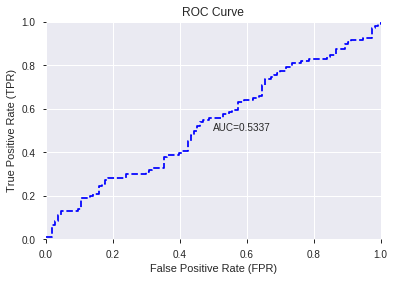

This function is available for GLM models only


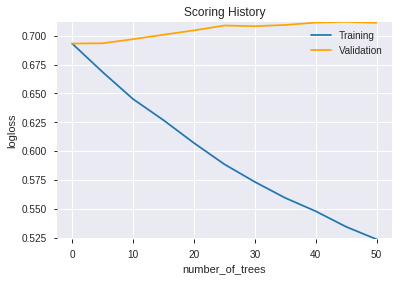

--2019-08-26 14:36:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_143549',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_143549',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_9efa',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_143641_model_3  0.598347  0.771139              0.491150  0.502669  0.252676
1  DeepLearning_grid_1_AutoML_20190826_143641_model_2  0.595842  0.776946              0.435966  0.515699  0.265946
2  DeepLearning_grid_1_AutoML_20190826_143641_model_1  0.593588  0.844191              0.486726  0.524385  0.274979
3  DeepLearning_grid_1_AutoML_20190826_143641_model_7  0.591668  0.703555              0.474620  0.501777  0.251780
4  DeepLearning_grid_1_AutoML_20190826_143641_model_6  0.586325  0.692981              0.483177  0.498782  0.248783
5  DeepLearning_grid_1_AutoML_20190826_143641_model_5  0.574553  0.698875              0.483177  0.500495  0.250496
6  DeepLearning_grid_1_AutoML_20190826_143641_model_4  0.571214  0.799591              0.448948  0.526468  0.277168
7  DeepLearning_grid_1_AutoML_20190826_143641_model_9  0.570087  0.692445              0.478168  0.499649  0.249649
8  DeepLearning_grid_1_AutoML_20190826_143641_model_8  0.545250  0.692722              0.500000  0.499778  0.249778
9               DeepLearning_1_AutoML_20190826_143641  0.524128  0.727344              0.491150  0.514246  0.264449

variable  relative_importance  scaled_importance  percentage
0             CORREL_14             1.000000           1.000000    0.035302
1             CDL2CROWS             0.948237           0.948237    0.033475
2    CDLMORNINGDOJISTAR             0.941236           0.941236    0.033227
3   CDLGAPSIDESIDEWHITE             0.931087           0.931087    0.032869
4             CORREL_12             0.899500           0.899500    0.031754
5         CDLHIKKAKEMOD             0.855539           0.855539    0.030202
6       CDLSHOOTINGSTAR             0.846246           0.846246    0.029874
7    CDLEVENINGDOJISTAR             0.843705           0.843705    0.029784
8      CDLSTICKSANDWICH             0.808147           0.808147    0.028529
9           CDLPIERCING             0.797998           0.797998    0.028171
10       CDLEVENINGSTAR             0.796552           0.796552    0.028120
11    CDLSTALLEDPATTERN             0.790770           0.790770    0.027916
12         CDLTHRUSTING             0.787775           0.787775    0.027810
13       CDLMORNINGSTAR             0.765087           0.765087    0.027009
14      CDLUNIQUE3RIVER             0.763864           0.763864    0.026966
15      CDLLADDERBOTTOM             0.748425           0.748425    0.026421
16            CORREL_20             0.713699           0.713699    0.025195
17    CDLDARKCLOUDCOVER             0.676437           0.676437    0.023879
18      CDLHOMINGPIGEON             0.628623           0.628623    0.022192
19    CDLINVERTEDHAMMER             0.579994           0.579994    0.020475
20               SAREXT             0.556822           0.556822    0.019657
21         HT_TRENDMODE             0.551129           0.551129    0.019456
22       is_month_start             0.542458           0.542458    0.019150
23      CDLADVANCEBLOCK             0.538006           0.538006    0.018993
24            CORREL_24             0.503500           0.503500    0.017774
25    CDLGRAVESTONEDOJI             0.493887           0.493887    0.017435
26       STOCHRSI_fastk             0.458050           0.458050    0.016170
27            CDLTAKURI             0.438727           0.438727    0.015488
28     CDLDRAGONFLYDOJI             0.436569           0.436569    0.015412
29                   AD             0.424902           0.424902    0.015000
30            CDLHAMMER             0.423238           0.423238    0.014941
31          HT_DCPERIOD             0.408968           0.408968    0.014437
32         aroondown_30             0.408129           0.408129    0.014408
33          aroondown_8             0.407104           0.407104    0.014372
34  CDLXSIDEGAP3METHODS             0.400135           0.400135    0.014126
35         weekday_name             0.398521           0.398521    0.014069
36                 hour             0.394913           0.394913    0.013941
37       CDL3LINESTRIKE             0.388373           0.388373    0.013710
38        CDLHANGINGMAN             0.368807           0.368807    0.013020
39              BETA_24             0.358817           0.358817    0.012667
40               MFI_30             0.356390           0.356390    0.012581
41           aroonup_14             0.349965           0.349965    0.012354
42         is_month_end             0.349832           0.349832    0.012350
43               Volume             0.346255           0.346255    0.012223
44           aroonup_12             0.339147           0.339147    0.011973
45       CDLMATCHINGLOW             0.337294           0.337294    0.011907
46       CDLRICKSHAWMAN             0.318133           0.318133    0.011231
47              weekday             0.309207           0.309207    0.010916
48            dayofweek             0.300528           0.300528    0.010609
49         CDLTASUKIGAP             0.296363           0.296363    0.010462

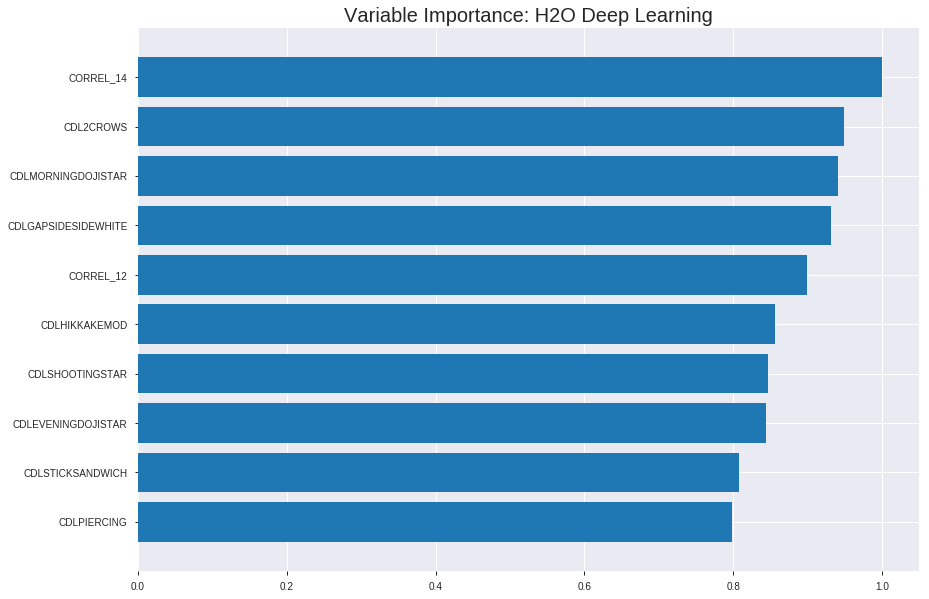

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_143641_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23618222675979056
RMSE: 0.48598582979320554
LogLoss: 0.6940116396770255
Mean Per-Class Error: 0.3781853987470196
AUC: 0.652034897623163
pr_auc: 0.6188161341730765
Gini: 0.30406979524632605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27555789787668905: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      146  642   0.8147   (642.0/788.0)
1      53   690   0.0713   (53.0/743.0)
Total  199  1332  0.454    (695.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275558     0.66506   318
max f2                       0.0287977    0.827     390
max f0point5                 0.428198     0.610358  221
max accuracy                 0.428198     0.620509  221
max precision                0.999972     0.777778  0
max recall                   0.00227174   1         398
max specificity              0.999972     0.997462  0
max absolute_mcc             0.428198     0.24434   221
max min_per_class_accuracy   0.447251     0.611675  208
max mean_per_class_accuracy  0.428198     0.621815  221

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 46.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.990362           1.41664   1.41664            0.6875           0.997664  0.6875                      0.997664            0.0148048       0.0148048                  41.6639   41.6639
    2        0.0202482                   0.957016           1.64845   1.52881            0.8              0.976351  0.741935                    0.987351            0.0161507       0.0309556                  64.8452   52.8806
    3        0.0300457                   0.916013           1.64845   1.56782            0.8              0.935259  0.76087                     0.970365            0.0161507       0.0471063                  64.8452   56.7821
    4        0.0404964                   0.875373           1.41664   1.52881            0.6875           0.893742  0.741935                    0.950591            0.0148048       0.0619112                  41.6639   52.8806
    5        0.0502939                   0.846555           1.37371   1.49859            0.666667         0.861037  0.727273                    0.933146            0.013459        0.0753701                  37.371    49.8593
    6        0.100588                    0.703553           1.55211   1.52535            0.753247         0.759672  0.74026                     0.846409            0.0780619       0.153432                   55.2114   52.5354
    7        0.150229                    0.639211           1.38275   1.47823            0.671053         0.667133  0.717391                    0.78717             0.0686406       0.222073                   38.2748   47.8232
    8        0.200523                    0.602168           1.09718   1.38266            0.532468         0.618628  0.67101                     0.744897            0.0551817       0.277254                   9.71841   38.2659
    9        0.300457                    0.540322           1.27944   1.34833            0.620915         0.570062  0.654348                    0.686745            0.12786         0.405114                   27.9436   34.8326
    10       0.400392                    0.486135           1.07742   1.28071            0.522876         0.511274  0.621533                    0.642949            0.107672        0.512786                   7.74198   28.071
    11       0.500327                    0.445823           1.03702   1.23204            0.503268         0.466027  0.597911                    0.607611            0.103634        0.61642                    3.70165   23.2035
    12       0.600261                    0.399731           0.915807  1.17939            0.444444         0.423322  0.572361                    0.576929            0.0915209       0.707941                   -8.41932  17.9388
    13       0.700196                    0.3624             0.767662  1.12062            0.372549         0.381076  0.543843                    0.548977            0.076716        0.784657                   -23.2338  12.0625
    14       0.800131                    0.316697           0.902339  1.09336            0.437908         0.341039  0.530612                    0.523006            0.090175        0.874832                   -9.7661   9.33612
    15       0.900065                    0.247999           0.740726  1.05421            0.359477         0.283919  0.511611                    0.49646             0.0740242       0.948856                   -25.9274  5.42079
    16       1                           3.96465e-06        0.511774  1                  0.248366         0.148726  0.485304                    0.461709          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3149335144755393
RMSE: 0.5611893748776248
LogLoss: 0.9666980050933675
Mean Per-Class Error: 0.4903286384976526
AUC: 0.47383411580594675
pr_auc: 0.4812390057096744
Gini: -0.05233176838810649
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1920992950184363e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.1921e-05   0.678733  399
max f2                       1.1921e-05   0.840807  399
max f0point5                 1.1921e-05   0.569044  399
max accuracy                 0.0212039    0.513699  396
max precision                0.800991     0.555556  8
max recall                   1.1921e-05   1         399
max specificity              0.999999     0.995305  0
max absolute_mcc             0.603027     0.141253  34
max min_per_class_accuracy   0.351339     0.488889  200
max mean_per_class_accuracy  0.329653     0.509671  228

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 35.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.955971           0.778667  0.778667           0.4              0.988042   0.4                         0.988042            0.00888889      0.00888889                 -22.1333  -22.1333
    2        0.0205479                   0.794297           1.46      1.08148            0.75             0.876048   0.555556                    0.938267            0.0133333       0.0222222                  46        8.14815
    3        0.0319635                   0.691558           0         0.695238           0                0.742633   0.357143                    0.868398            0               0.0222222                  -100      -30.4762
    4        0.0410959                   0.672494           0.973333  0.757037           0.5              0.682102   0.388889                    0.826999            0.00888889      0.0311111                  -2.66667  -24.2963
    5        0.0502283                   0.638422           0.486667  0.707879           0.25             0.65304    0.363636                    0.79537             0.00444444      0.0355556                  -51.3333  -29.2121
    6        0.100457                    0.56394            0.619394  0.663636           0.318182         0.606618   0.340909                    0.700994            0.0311111       0.0666667                  -38.0606  -33.6364
    7        0.150685                    0.511769           1.23879   0.855354           0.636364         0.537239   0.439394                    0.646409            0.0622222       0.128889                   23.8788   -14.4646
    8        0.200913                    0.474072           0.884848  0.862727           0.454545         0.497896   0.443182                    0.609281            0.0444444       0.173333                   -11.5152  -13.7273
    9        0.30137                     0.418436           1.10606   0.943838           0.568182         0.443936   0.484848                    0.554166            0.111111        0.284444                   10.6061   -5.61616
    10       0.399543                    0.377655           1.08651   0.978895           0.55814          0.399229   0.502857                    0.516096            0.106667        0.391111                   8.65116   -2.11048
    11       0.5                         0.347916           0.973333  0.977778           0.5              0.361205   0.502283                    0.484976            0.0977778       0.488889                   -2.66667  -2.22222
    12       0.600457                    0.31816            1.10606   0.99924            0.568182         0.334958   0.513308                    0.459878            0.111111        0.6                        10.6061   -0.0760456
    13       0.69863                     0.285496           0.860155  0.979695           0.44186          0.301758   0.503268                    0.437659            0.0844444       0.684444                   -13.9845  -2.0305
    14       0.799087                    0.231612           0.929091  0.973333           0.477273         0.258329   0.5                         0.415114            0.0933333       0.777778                   -7.09091  -2.66667
    15       0.899543                    0.14642            1.06182   0.983215           0.545455         0.194612   0.505076                    0.39049             0.106667        0.884444                   6.18182   -1.67851
    16       1                           5.30357e-07        1.1503    1                  0.590909         0.0754518  0.513699    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:37:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:37:59  1 min 16.729 sec  5966 obs/sec      10        1             15310      0.527103         0.870128            -0.112312      0.576606        0.554725           1.67421          0.505552                         0.56925            1.18945               -0.297158        0.524215          0.538396             1.55733            0.486301
    2019-08-26 14:38:05  1 min 22.617 sec  7323 obs/sec      40        4             61240      0.50333          0.798767            -0.0142419     0.619668        0.576801           1.41664          0.483344                         0.573398           1.27634               -0.316129        0.478571          0.482972             1.168              0.481735
    2019-08-26 14:38:11  1 min 29.044 sec  8329 obs/sec      80        8             122480     0.485986         0.694012            0.0544542      0.652035        0.618816           1.41664          0.453952                         0.561189           0.966698              -0.26068         0.473834          0.481239             0.778667           0.486301
    2019-08-26 14:38:17  1 min 34.832 sec  9006 obs/sec      120       12            183720     0.487968         0.699186            0.046725       0.660515        0.629514           1.54542          0.425865                         0.55978            0.98681               -0.254357        0.484444          0.507206             1.55733            0.486301
    2019-08-26 14:38:22  1 min 40.178 sec  9546 obs/sec      160       16            244960     0.484359         0.73924             0.060773       0.664473        0.609287           1.28785          0.421293                         0.555023           1.10358               -0.233129        0.481377          0.485368             1.55733            0.486301
    2019-08-26 14:38:28  1 min 45.681 sec  9856 obs/sec      200       20            306200     0.477841         0.698292            0.0858818      0.692107        0.640822           1.41664          0.400392                         0.563325           1.03566               -0.270294        0.459228          0.476112             1.168              0.484018
    2019-08-26 14:38:34  1 min 51.865 sec  10299 obs/sec     250       25            382750     0.471891         0.691325            0.108504       0.707073        0.648142           1.41664          0.401045                         0.548767           1.05071               -0.205486        0.488138          0.490938             1.168              0.484018
    2019-08-26 14:38:40  1 min 57.998 sec  10629 obs/sec     300       30            459300     0.471635         0.717406            0.109471       0.709433        0.641995           1.41664          0.378184                         0.549574           1.15938               -0.209035        0.492175          0.489082             1.55733            0.484018
    2019-08-26 14:38:40

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CORREL_14            1.0                    1.0                  0.0353018927415194
CDL2CROWS            0.9482374787330627     0.9482374787330627   0.03347457776772337
CDLMORNINGDOJISTAR   0.9412360191345215     0.9412360191345215   0.03322741299194158
CDLGAPSIDESIDEWHITE  0.9310874938964844     0.9310874938964844   0.032869150842503796
CORREL_12            0.8995002508163452     0.8995002508163452   0.03175406137528842
---                  ---                    ---                  ---
CDLMATCHINGLOW       0.3372938930988312     0.3372938930988312   0.011907112836544451
CDLRICKSHAWMAN       0.3181329071521759     0.3181329071521759   0.011230693765833865
weekday              0.30920735001564026    0.30920735001564026  0.010915604705141581
dayofweek            0.3005284070968628     0.3005284070968628   0.01060922159311313
CDLTASUKIGAP         0.29636329412460327    0.29636329412460327  0.010462185221710113


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5981735159817352)

('F1', 0.6563467492260062)

('auc', 0.5983469694439806)

('logloss', 0.7711388823435705)

('mean_per_class_error', 0.403698447153114)

('rmse', 0.5026688877585422)

('mse', 0.2526760107204099)

deeplearning prediction progress: |███████████████████████████████████████| 100%


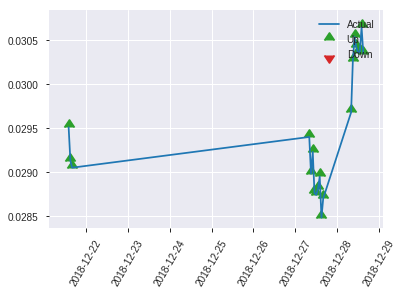


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2526760107204099
RMSE: 0.5026688877585422
LogLoss: 0.7711388823435705
Mean Per-Class Error: 0.403698447153114
AUC: 0.5983469694439806
pr_auc: 0.5701021183489046
Gini: 0.19669393888796116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.000248231749734671: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    106  0        (0.0/106.0)
Total  2    217  0.5068   (111.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000248232  0.656347  216
max f2                       0.000248232  0.826833  216
max f0point5                 0.446423     0.581633  95
max accuracy                 0.453672     0.598174  93
max precision                0.737664     0.75      7
max recall                   0.000248232  1         216
max specificity              0.999975     0.99115   0
max absolute_mcc             0.532922     0.194479  58
max min_per_class_accuracy   0.418032     0.575221  108
max mean_per_class_accuracy  0.446423     0.596302  95

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 43.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.931935           0.688679  0.688679           0.333333         0.978778  0.333333                    0.978778            0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.769525           2.06604   1.23962            1                0.782227  0.6                         0.900158            0.0188679       0.0283019                  106.604   23.9623
    3        0.0319635                   0.740495           2.06604   1.47574            1                0.746641  0.714286                    0.856296            0.0188679       0.0471698                  106.604   47.5741
    4        0.0410959                   0.733804           1.03302   1.37736            0.5              0.737024  0.666667                    0.829791            0.00943396      0.0566038                  3.30189   37.7358
    5        0.0502283                   0.714033           2.06604   1.50257            1                0.726275  0.727273                    0.81097             0.0188679       0.0754717                  106.604   50.2573
    6        0.100457                    0.630603           1.31475   1.40866            0.636364         0.671111  0.681818                    0.74104             0.0660377       0.141509                   31.4751   40.8662
    7        0.150685                    0.599789           1.12693   1.31475            0.545455         0.61209   0.636364                    0.698057            0.0566038       0.198113                   12.693    31.4751
    8        0.200913                    0.566805           1.12693   1.2678             0.545455         0.578959  0.613636                    0.668282            0.0566038       0.254717                   12.693    26.7796
    9        0.30137                     0.508018           1.12693   1.22084            0.545455         0.540078  0.590909                    0.625547            0.113208        0.367925                   12.693    22.084
    10       0.401826                    0.461728           1.22084   1.22084            0.590909         0.483444  0.590909                    0.590022            0.122642        0.490566                   22.084    22.084
    11       0.502283                    0.418014           0.939108  1.16449            0.454545         0.43955   0.563636                    0.559927            0.0943396       0.584906                   -6.08919  16.4494
    12       0.598174                    0.377262           0.590296  1.07245            0.285714         0.398826  0.519084                    0.534102            0.0566038       0.641509                   -40.9704  7.24471
    13       0.69863                     0.338958           0.939108  1.05327            0.454545         0.361329  0.509804                    0.509259            0.0943396       0.735849                   -6.08919  5.32741
    14       0.799087                    0.298056           1.03302   1.05073            0.5              0.318327  0.508571                    0.485256            0.103774        0.839623                   3.30189   5.07278
    15       0.899543                    0.250977           0.845197  1.02778            0.409091         0.275693  0.497462                    0.461853            0.0849057       0.924528                   -15.4803  2.77751
    16       1                           1.5238e-05         0.751286  1                  0.363636         0.17455   0.484018                    0.432992          

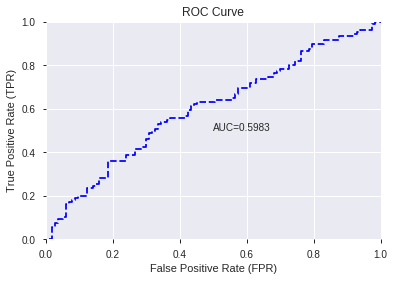

This function is available for GLM models only


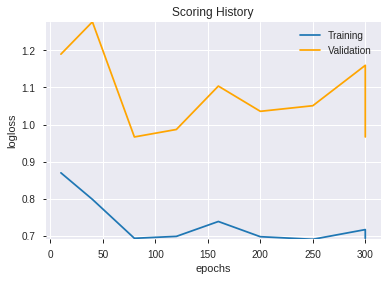

--2019-08-26 14:45:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_143641_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_143641_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_14',
 'CDL2CROWS',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_12',
 'CDLHIKKAKEMOD',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLMORNINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CORREL_20',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'CDLINVERTEDHAMMER',
 'SAREXT',
 'HT_TRENDMODE',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CORREL_24',
 'CDLGRAVESTONEDOJI',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'AD',
 'CDLHAMMER',
 'HT_DCPERIOD',
 'aroondown_30',
 'aroondown_8',
 'CDLXSIDEGAP3METHODS',
 'weekday_name',
 'hour',
 'CDL3LINESTRIKE',
 'CDLHANGINGMAN',
 'BETA_24',
 'MFI_30',
 'aroonup_14',
 'is_month_end',
 'Volume',
 'aroonup_12',
 'CDLMATCHINGLOW',
 'CDLRICKSHAWMAN',
 'weekday',
 'dayofweek',
 'CDLTASUKIGAP']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_144545_model_1  0.561112  0.692564              0.466063  0.499708  0.249708

variable  relative_importance  scaled_importance  percentage
0                    AD             0.009235           1.000000    0.059582
1        CDLMORNINGSTAR             0.008386           0.908069    0.054105
2   CDLGAPSIDESIDEWHITE             0.006403           0.693264    0.041306
3    CDLMORNINGDOJISTAR             0.006108           0.661401    0.039408
4          is_month_end             0.005655           0.612261    0.036480
5               BETA_24             0.005470           0.592309    0.035291
6                Volume             0.004973           0.538472    0.032083
7        CDL3LINESTRIKE             0.004938           0.534690    0.031858
8             CDL2CROWS             0.004928           0.533613    0.031794
9        CDLEVENINGSTAR             0.004820           0.521871    0.031094
10      CDLSHOOTINGSTAR             0.004635           0.501917    0.029905
11    CDLINVERTEDHAMMER             0.004607           0.498853    0.029723
12            CORREL_20             0.004595           0.497512    0.029643
13      CDLHOMINGPIGEON             0.003845           0.416331    0.024806
14       STOCHRSI_fastk             0.003749           0.405905    0.024185
15      CDLLADDERBOTTOM             0.003694           0.399987    0.023832
16      CDLUNIQUE3RIVER             0.003691           0.399678    0.023814
17           aroonup_12             0.003574           0.386983    0.023057
18               SAREXT             0.003519           0.381054    0.022704
19          CDLPIERCING             0.003505           0.379508    0.022612
20         CDLTHRUSTING             0.003499           0.378855    0.022573
21     CDLSTICKSANDWICH             0.003430           0.371379    0.022128
22            CORREL_14             0.003361           0.363934    0.021684
23    CDLDARKCLOUDCOVER             0.003274           0.354494    0.021122
24        CDLHIKKAKEMOD             0.003076           0.333032    0.019843
25       is_month_start             0.003059           0.331210    0.019734
26          HT_DCPERIOD             0.002893           0.313202    0.018661
27        CDLHANGINGMAN             0.002803           0.303488    0.018082
28                 hour             0.002776           0.300625    0.017912
29       CDLMATCHINGLOW             0.002574           0.278749    0.016608
30           aroonup_14             0.002498           0.270466    0.016115
31  CDLXSIDEGAP3METHODS             0.002175           0.235530    0.014033
32         aroondown_30             0.001853           0.200661    0.011956
33            CDLTAKURI             0.001851           0.200442    0.011943
34     CDLDRAGONFLYDOJI             0.001846           0.199895    0.011910
35            CORREL_12             0.001680           0.181950    0.010841
36   CDLEVENINGDOJISTAR             0.001628           0.176239    0.010501
37            CORREL_24             0.001567           0.169619    0.010106
38      CDLADVANCEBLOCK             0.001495           0.161911    0.009647
39          aroondown_8             0.001287           0.139336    0.008302
40         weekday_name             0.001153           0.124874    0.007440
41         CDLTASUKIGAP             0.001135           0.122848    0.007320
42       CDLRICKSHAWMAN             0.000670           0.072512    0.004320
43            dayofweek             0.000579           0.062644    0.003732
44              weekday             0.000574           0.062169    0.003704
45    CDLGRAVESTONEDOJI             0.000512           0.055446    0.003304
46            CDLHAMMER             0.000459           0.049738    0.002964
47         HT_TRENDMODE             0.000447           0.048408    0.002884
48               MFI_30             0.000387           0.041950    0.002499
49    CDLSTALLEDPATTERN             0.000132           0.014253    0.000849

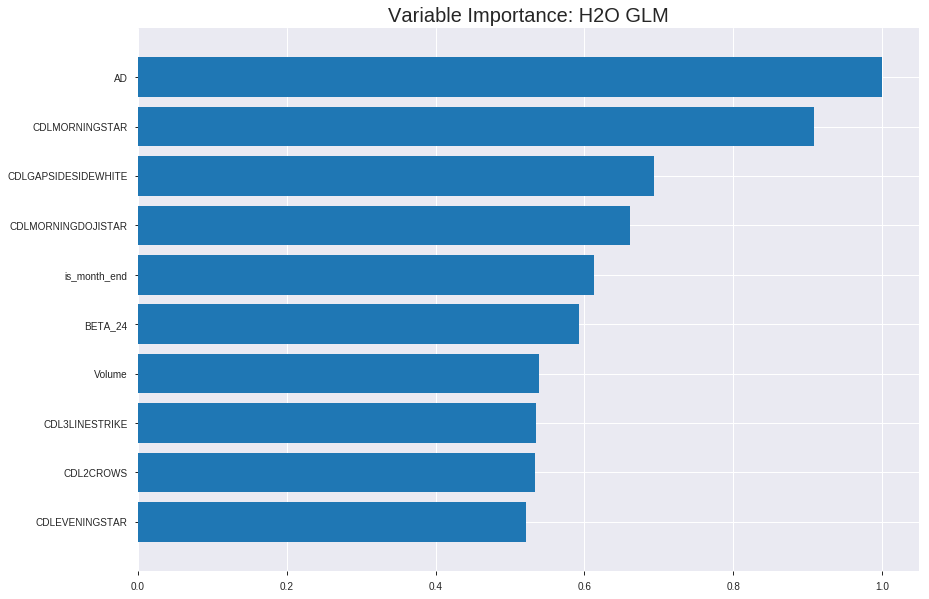

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_144545_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24860519954225208
RMSE: 0.4986032486278565
LogLoss: 0.6903532001425795
Null degrees of freedom: 1530
Residual degrees of freedom: 1480
Null deviance: 2121.0938114372193
Residual deviance: 2113.8614988365784
AIC: 2215.8614988365784
AUC: 0.5821943895990326
pr_auc: 0.5696174186992568
Gini: 0.16438877919806516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47441020001267864: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   759   0.9632   (759.0/788.0)
1      3    740   0.004    (3.0/743.0)
Total  32   1499  0.4977   (762.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47441      0.660125  368
max f2                       0.473045     0.827748  373
max f0point5                 0.482157     0.561003  272
max accuracy                 0.487215     0.557805  164
max precision                0.527067     1         0
max recall                   0.440868     1         395
max specificity              0.527067     1         0
max absolute_mcc             0.483341     0.128414  248
max min_per_class_accuracy   0.485111     0.546433  210
max mean_per_class_accuracy  0.483341     0.561092  248

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.507993           1.80299   1.80299            0.875            0.514619  0.875                       0.514619            0.0188425       0.0188425                  80.2995   80.2995
    2        0.0202482                   0.501772           1.64845   1.72822            0.8              0.505138  0.83871                     0.510031            0.0161507       0.0349933                  64.8452   72.8216
    3        0.0300457                   0.499977           1.23634   1.56782            0.6              0.500751  0.76087                     0.507005            0.0121131       0.0471063                  23.6339   56.7821
    4        0.0404964                   0.497407           1.03028   1.4291             0.5              0.498903  0.693548                    0.504914            0.0107672       0.0578735                  3.02826   42.9102
    5        0.0502939                   0.49569            1.51108   1.44507            0.733333         0.496329  0.701299                    0.503242            0.0148048       0.0726783                  51.1081   44.5072
    6        0.100588                    0.491889           1.25775   1.35141            0.61039          0.493502  0.655844                    0.498372            0.0632571       0.135935                   25.7748   35.141
    7        0.150229                    0.490161           1.0574    1.25426            0.513158         0.49097   0.608696                    0.495926            0.0524899       0.188425                   5.73953   25.4257
    8        0.200523                    0.48879            1.17747   1.235              0.571429         0.489514  0.599349                    0.494318            0.0592194       0.247645                   17.7466   23.4997
    9        0.300457                    0.487223           1.05048   1.17363            0.509804         0.487972  0.569565                    0.492207            0.10498         0.352624                   5.04843   17.3626
    10       0.400392                    0.486089           0.902339  1.10592            0.437908         0.486654  0.536705                    0.490821            0.090175        0.442799                   -9.7661   10.5915
    11       0.500327                    0.485042           1.06395   1.09753            0.51634          0.48559   0.532637                    0.489776            0.106326        0.549125                   6.3952    9.75335
    12       0.600261                    0.483977           1.13129   1.10315            0.54902          0.48453   0.535365                    0.488903            0.113055        0.66218                    13.1291   10.3154
    13       0.700196                    0.482739           0.888871  1.07257            0.431373         0.483363  0.520522                    0.488112            0.0888291       0.751009                   -11.1129  7.25704
    14       0.800131                    0.48126            0.969678  1.05972            0.470588         0.482034  0.514286                    0.487353            0.0969044       0.847914                   -3.03222  5.97193
    15       0.900065                    0.479317           0.821533  1.03327            0.398693         0.480317  0.501451                    0.486572            0.0820996       0.930013                   -17.8467  3.32733
    16       1                           0.435414           0.700323  1                  0.339869         0.473882  0.485304                    0.485304          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25110965834562105
RMSE: 0.5011084297291566
LogLoss: 0.6953691374424982
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 608.2811161936828
Residual deviance: 609.1433643996284
AIC: 711.1433643996284
AUC: 0.5087532603025561
pr_auc: 0.5053909824791106
Gini: 0.017506520605112152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433470793696719: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433471     0.678733  399
max f2                       0.433471     0.840807  399
max f0point5                 0.433471     0.569044  399
max accuracy                 0.483024     0.531963  144
max precision                0.483024     0.564935  144
max recall                   0.433471     1         399
max specificity              0.518384     0.995305  0
max absolute_mcc             0.477115     0.106096  358
max min_per_class_accuracy   0.481898     0.515556  199
max mean_per_class_accuracy  0.483024     0.536056  144

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.500145           0.389333  0.389333           0.2              0.508407  0.2                         0.508407            0.00444444      0.00444444                 -61.0667  -61.0667
    2        0.0205479                   0.496272           0.486667  0.432593           0.25             0.497841  0.222222                    0.503711            0.00444444      0.00888889                 -51.3333  -56.7407
    3        0.0319635                   0.495224           0.778667  0.55619            0.4              0.495684  0.285714                    0.500844            0.00888889      0.0177778                  -22.1333  -44.381
    4        0.0410959                   0.493744           1.46      0.757037           0.75             0.494594  0.388889                    0.499455            0.0133333       0.0311111                  46        -24.2963
    5        0.0502283                   0.491812           1.46      0.884848           0.75             0.493036  0.454545                    0.498288            0.0133333       0.0444444                  46        -11.5152
    6        0.100457                    0.487966           0.884848  0.884848           0.454545         0.489792  0.454545                    0.49404             0.0444444       0.0888889                  -11.5152  -11.5152
    7        0.150685                    0.485593           0.973333  0.914343           0.5              0.486483  0.469697                    0.491521            0.0488889       0.137778                   -2.66667  -8.56566
    8        0.200913                    0.484708           1.1503    0.973333           0.590909         0.485109  0.5                         0.489918            0.0577778       0.195556                   15.0303   -2.66667
    9        0.30137                     0.483484           1.1503    1.03232            0.590909         0.483982  0.530303                    0.487939            0.115556        0.311111                   15.0303   3.23232
    10       0.399543                    0.482665           1.08651   1.04564            0.55814          0.483015  0.537143                    0.486729            0.106667        0.417778                   8.65116   4.56381
    11       0.5                         0.481896           0.973333  1.03111            0.5              0.482301  0.52968                     0.48584             0.0977778       0.515556                   -2.66667  3.11111
    12       0.600457                    0.481022           1.10606   1.04365            0.568182         0.481453  0.536122                    0.485106            0.111111        0.626667                   10.6061   4.36502
    13       0.69863                     0.480268           0.860155  1.01786            0.44186          0.480652  0.522876                    0.48448             0.0844444       0.711111                   -13.9845  1.78649
    14       0.799087                    0.478945           0.929091  1.0067             0.477273         0.479657  0.517143                    0.483874            0.0933333       0.804444                   -7.09091  0.670476
    15       0.899543                    0.477158           0.663636  0.968393           0.340909         0.478124  0.497462                    0.483232            0.0666667       0.871111                   -33.6364  -3.16074
    16       1                           0.433471           1.28303   1                  0.659091         0.472435  0.513699                    0.482147


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:45:45  0.000 sec   2            3.3       51            1.38071           1.39074
    2019-08-26 14:45:45  0.020 sec   4            2.1       51            1.37835           1.39195
    2019-08-26 14:45:45  0.032 sec   6            1.3       51            1.37516           1.39389
    2019-08-26 14:45:45  0.043 sec   8            0.79      51            1.37114           1.39691
    2019-08-26 14:45:45  0.053 sec   10           0.49      51            1.36652           1.40137

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5616438356164384)

('F1', 0.6579804560260587)

('auc', 0.5611120387376858)

('logloss', 0.6925642424142455)

('mean_per_class_error', 0.4373434630155284)

('rmse', 0.499707558880175)

('mse', 0.24970764440198354)

glm prediction progress: |████████████████████████████████████████████████| 100%


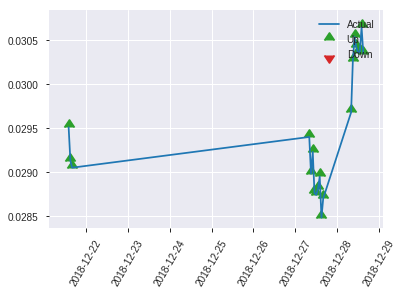


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24970764440198354
RMSE: 0.499707558880175
LogLoss: 0.6925642424142455
Null degrees of freedom: 218
Residual degrees of freedom: 168
Null deviance: 303.37613151001983
Residual deviance: 303.3431381774395
AIC: 405.3431381774395
AUC: 0.5611120387376858
pr_auc: 0.5110811460964971
Gini: 0.12222407747537156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47773898215484945: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   100  0.885    (100.0/113.0)
1      5    101  0.0472   (5.0/106.0)
Total  18   201  0.4795   (105.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477739     0.65798   200
max f2                       0.438594     0.824261  218
max f0point5                 0.480193     0.565693  178
max accuracy                 0.483578     0.561644  109
max precision                0.486923     0.594595  36
max recall                   0.438594     1         218
max specificity              0.520316     0.99115   0
max absolute_mcc             0.480193     0.150419  178
max min_per_class_accuracy   0.483578     0.557522  109
max mean_per_class_accuracy  0.483376     0.562657  115

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.498783           0.688679  0.688679           0.333333         0.50607   0.333333                    0.50607             0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.492145           1.03302   0.826415           0.5              0.495607  0.4                         0.501885            0.00943396      0.0188679                  3.30189   -17.3585
    3        0.0319635                   0.491306           0         0.590296           0                0.491442  0.285714                    0.498901            0               0.0188679                  -100      -40.9704
    4        0.0410959                   0.490215           0         0.459119           0                0.490799  0.222222                    0.4971              0               0.0188679                  -100      -54.0881
    5        0.0502283                   0.489828           2.06604   0.751286           1                0.490064  0.363636                    0.495821            0.0188679       0.0377358                  106.604   -24.8714
    6        0.100457                    0.487924           1.50257   1.12693            0.727273         0.488635  0.545455                    0.492228            0.0754717       0.113208                   50.2573   12.693
    7        0.150685                    0.487106           1.12693   1.12693            0.545455         0.487541  0.545455                    0.490666            0.0566038       0.169811                   12.693    12.693
    8        0.200913                    0.486607           1.12693   1.12693            0.545455         0.486834  0.545455                    0.489708            0.0566038       0.226415                   12.693    12.693
    9        0.30137                     0.485537           0.939108  1.06432            0.454545         0.486047  0.515152                    0.488487            0.0943396       0.320755                   -6.08919  6.43225
    10       0.401826                    0.484365           1.31475   1.12693            0.636364         0.485006  0.545455                    0.487617            0.132075        0.45283                    31.4751   12.693
    11       0.502283                    0.483578           1.12693   1.12693            0.545455         0.483998  0.545455                    0.486893            0.113208        0.566038                   12.693    12.693
    12       0.598174                    0.482546           0.885445  1.08822            0.428571         0.483078  0.526718                    0.486281            0.0849057       0.650943                   -11.4555  8.82183
    13       0.69863                     0.481532           0.751286  1.03977            0.363636         0.482177  0.503268                    0.485691            0.0754717       0.726415                   -24.8714  3.97706
    14       0.799087                    0.480352           1.31475   1.07434            0.636364         0.481012  0.52                        0.485103            0.132075        0.858491                   31.4751   7.43396
    15       0.899543                    0.478144           0.751286  1.03826            0.363636         0.479465  0.502538                    0.484473            0.0754717       0.933962                   -24.8714  3.82626
    16       1                           0.438594           0.657376  1                  0.318182         0.471973  0.484018                    0.483218         

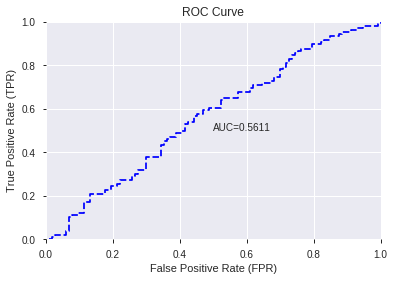

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


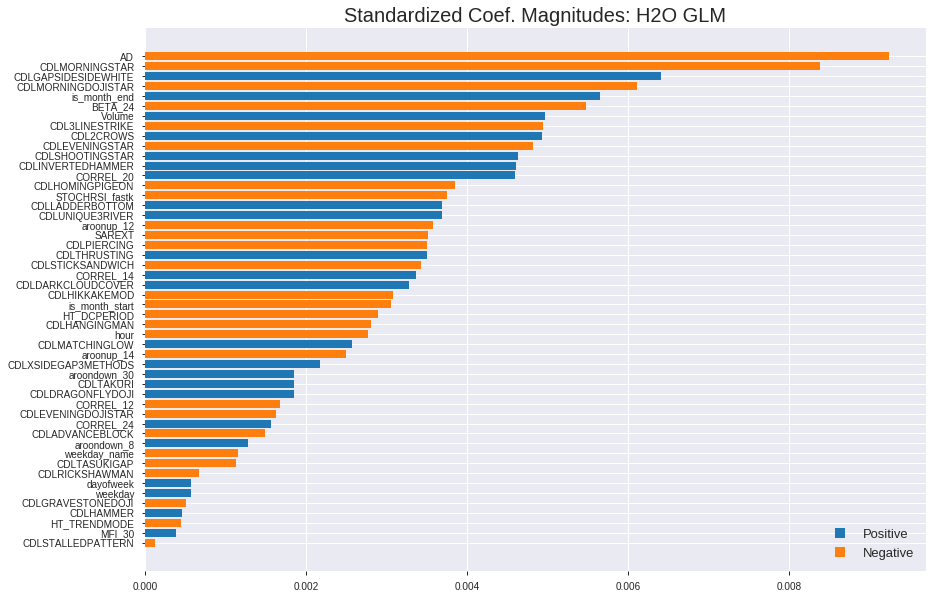

'log_likelihood'
--2019-08-26 14:45:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_144545_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_144545_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['AD',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'BETA_24',
 'Volume',
 'CDL3LINESTRIKE',
 'CDL2CROWS',
 'CDLEVENINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'STOCHRSI_fastk',
 'CDLLADDERBOTTOM',
 'CDLUNIQUE3RIVER',
 'aroonup_12',
 'SAREXT',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'CDLSTICKSANDWICH',
 'CORREL_14',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'is_month_start',
 'HT_DCPERIOD',
 'CDLHANGINGMAN',
 'hour',
 'CDLMATCHINGLOW',
 'aroonup_14',
 'CDLXSIDEGAP3METHODS',
 'aroondown_30',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CORREL_12',
 'CDLEVENINGDOJISTAR',
 'CORREL_24',
 'CDLADVANCEBLOCK',
 'aroondown_8',
 'weekday_name',
 'CDLTASUKIGAP',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'weekday',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'MFI_30',
 'CDLSTALLEDPATTERN']

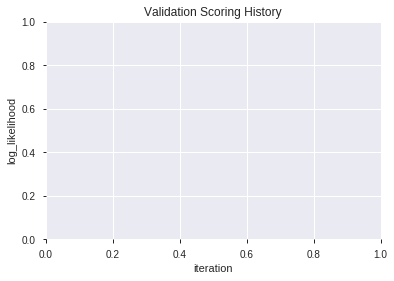

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_144556_model_5  0.501419  0.719437              0.495575  0.511972  0.262115
1               XGBoost_1_AutoML_20190826_144556  0.490900  0.708254              0.464894  0.507288  0.257341
2  XGBoost_grid_1_AutoML_20190826_144556_model_7  0.489982  0.713233              0.495575  0.509544  0.259635
3               XGBoost_2_AutoML_20190826_144556  0.484221  0.706740              0.474328  0.506638  0.256682
4               XGBoost_3_AutoML_20190826_144556  0.481967  0.702361              0.495575  0.504488  0.254508
5  XGBoost_grid_1_AutoML_20190826_144556_model_2  0.478294  0.701755              0.500000  0.504232  0.254249
6  XGBoost_grid_1_AutoML_20190826_144556_model_6  0.458507  0.707131              0.495575  0.506834  0.256881
7  XGBoost_grid_1_AutoML_20190826_144556_model_4  0.450493  0.704123              0.495575  0.505389  0.255418
8  XGBoost_grid_1_AutoML_20190826_144556_model_3  0.441309  0.708054              0.482301  0.507371  0.257425
9  XGBoost_grid_1_AutoML_20190826_144556_model_1  0.438596  0.709982              0.500000  0.508164  0.258230

variable  relative_importance  scaled_importance  percentage
0                Volume          2446.901855           1.000000    0.114082
1                MFI_30          2401.343750           0.981381    0.111958
2               BETA_24          2123.069824           0.867656    0.098984
3                SAREXT          1951.684937           0.797615    0.090994
4                    AD          1854.366821           0.757843    0.086456
5           HT_DCPERIOD          1781.171753           0.727929    0.083044
6                  hour          1360.660278           0.556075    0.063438
7          aroondown_30          1229.524902           0.502482    0.057324
8        STOCHRSI_fastk          1121.869629           0.458486    0.052305
9            aroonup_12          1091.801025           0.446197    0.050903
10          aroondown_8           998.248840           0.407964    0.046541
11           aroonup_14           902.887146           0.368992    0.042095
12            dayofweek           503.675293           0.205842    0.023483
13              weekday           340.180511           0.139025    0.015860
14         weekday_name           289.581329           0.118346    0.013501
15         HT_TRENDMODE           228.550140           0.093404    0.010656
16       CDLRICKSHAWMAN           192.100327           0.078508    0.008956
17         is_month_end            75.340820           0.030790    0.003513
18       CDLMATCHINGLOW            56.051857           0.022907    0.002613
19            CORREL_24            55.668900           0.022751    0.002595
20    CDLINVERTEDHAMMER            45.122864           0.018441    0.002104
21            CORREL_20            44.471188           0.018174    0.002073
22            CDLHAMMER            42.754398           0.017473    0.001993
23       is_month_start            35.191395           0.014382    0.001641
24  CDLXSIDEGAP3METHODS            30.260691           0.012367    0.001411
25    CDLGRAVESTONEDOJI            27.902721           0.011403    0.001301
26       CDLMORNINGSTAR            22.343386           0.009131    0.001042
27      CDLADVANCEBLOCK            21.621496           0.008836    0.001008
28     CDLDRAGONFLYDOJI            18.838688           0.007699    0.000878
29         CDLTASUKIGAP            17.876087           0.007306    0.000833
30      CDLHOMINGPIGEON            17.672815           0.007223    0.000824
31        CDLHANGINGMAN            17.070654           0.006976    0.000796
32   CDLMORNINGDOJISTAR            16.772520           0.006855    0.000782
33            CDLTAKURI            16.196756           0.006619    0.000755
34            CORREL_14            16.103373           0.006581    0.000751
35    CDLDARKCLOUDCOVER            13.791774           0.005636    0.000643
36       CDLEVENINGSTAR             8.220024           0.003359    0.000383
37       CDL3LINESTRIKE             4.779936           0.001953    0.000223
38      CDLLADDERBOTTOM             4.060997           0.001660    0.000189
39        CDLHIKKAKEMOD             3.791193           0.001549    0.000177
40   CDLEVENINGDOJISTAR             2.985973           0.001220    0.000139
41      CDLSHOOTINGSTAR             2.868168           0.001172    0.000134
42            CDL2CROWS             2.797191           0.001143    0.000130
43          CDLPIERCING             2.379679           0.000973    0.000111
44    CDLSTALLEDPATTERN             2.152022           0.000879    0.000100
45         CDLTHRUSTING             2.010800           0.000822    0.000094
46  CDLGAPSIDESIDEWHITE             1.957102           0.000800    0.000091
47            CORREL_12             1.832414           0.000749    0.000085
48     CDLSTICKSANDWICH             0.094371           0.000039    0.000004

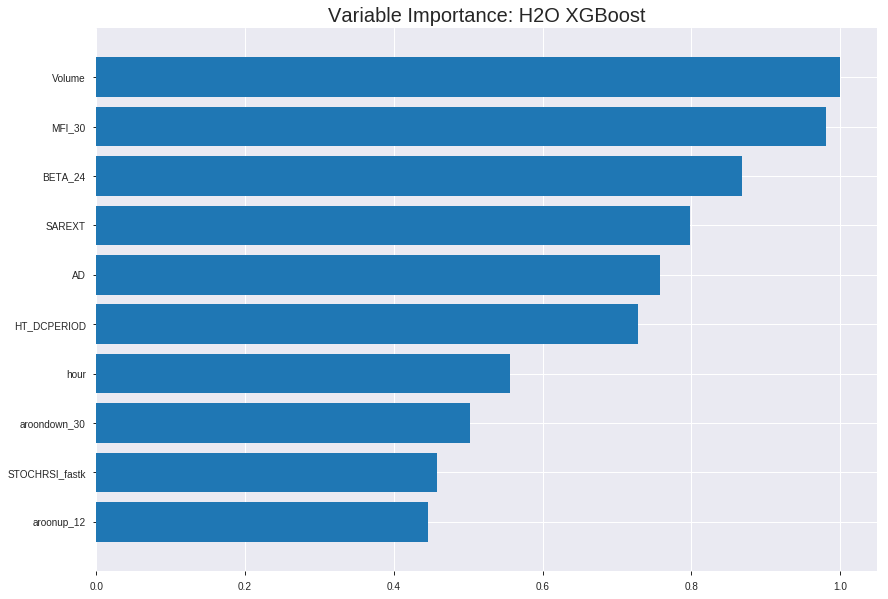

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_144556_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.054096991214257456
RMSE: 0.23258759901219467
LogLoss: 0.25578987828587585
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9986541049798116
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5052608251571655: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      788  0    0        (0.0/788.0)
1      0    743  0        (0.0/743.0)
Total  788  743  0        (0.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.505261     1        198
max f2                       0.505261     1        198
max f0point5                 0.505261     1        198
max accuracy                 0.505261     1        198
max precision                0.90813      1        0
max recall                   0.505261     1        198
max specificity              0.90813      1        0
max absolute_mcc             0.505261     1        198
max min_per_class_accuracy   0.505261     1        198
max mean_per_class_accuracy  0.505261     1        198

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.71 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0104507                   0.885104           2.06057  2.06057            1                0.892428  1                           0.892428            0.0215343       0.0215343                  106.057  106.057
    2        0.0202482                   0.87839            2.06057  2.06057            1                0.882524  1                           0.887636            0.0201884       0.0417227                  106.057  106.057
    3        0.0300457                   0.870312           2.06057  2.06057            1                0.874697  1                           0.883416            0.0201884       0.0619112                  106.057  106.057
    4        0.0404964                   0.861804           2.06057  2.06057            1                0.866482  1                           0.879046            0.0215343       0.0834455                  106.057  106.057
    5        0.0502939                   0.853366           2.06057  2.06057            1                0.856833  1                           0.874719            0.0201884       0.103634                   106.057  106.057
    6        0.100588                    0.831335           2.06057  2.06057            1                0.840482  1                           0.857601            0.103634        0.207268                   106.057  106.057
    7        0.150229                    0.81162            2.06057  2.06057            1                0.821283  1                           0.8456              0.102288        0.309556                   106.057  106.057
    8        0.200523                    0.79478            2.06057  2.06057            1                0.802036  1                           0.834674            0.103634        0.41319                    106.057  106.057
    9        0.300457                    0.759366           2.06057  2.06057            1                0.777461  1                           0.815644            0.205922        0.619112                   106.057  106.057
    10       0.400392                    0.70707            2.06057  2.06057            1                0.735629  1                           0.795673            0.205922        0.825034                   106.057  106.057
    11       0.500327                    0.364166           1.75081  1.99869            0.849673         0.622703  0.969974                    0.761124            0.174966        1                          75.0807  99.8695
    12       0.600261                    0.266735           0        1.66594            0                0.30005   0.808487                    0.684362            0               1                          -100     66.5941
    13       0.700196                    0.226668           0        1.42817            0                0.245284  0.693097                    0.621695            0               1                          -100     42.8172
    14       0.800131                    0.192317           0        1.2498             0                0.208638  0.606531                    0.570105            0               1                          -100     24.9796
    15       0.900065                    0.157795           0        1.11103            0                0.175938  0.539187                    0.526341            0               1                          -100     11.103
    16       1                           0.0756816          0        1                  0                0.133487  0.485304                    0.487081            0               1                



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2685153754476613
RMSE: 0.5181846924096285
LogLoss: 0.7326082474805756
Mean Per-Class Error: 0.4462910798122066
AUC: 0.5095774647887324
pr_auc: 0.5009828406471534
Gini: 0.019154929577464896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19092567265033722: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    208  0.9765   (208.0/213.0)
1      1    224  0.0044   (1.0/225.0)
Total  6    432  0.4772   (209.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.190926     0.681887  393
max f2                       0.171665     0.842697  396
max f0point5                 0.333152     0.589666  321
max accuracy                 0.333152     0.561644  321
max precision                0.81461      1         0
max recall                   0.171665     1         396
max specificity              0.81461      1         0
max absolute_mcc             0.333152     0.135638  321
max min_per_class_accuracy   0.436404     0.488889  202
max mean_per_class_accuracy  0.364238     0.553709  280

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 44.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.717263           0.778667  0.778667           0.4              0.766722  0.4                         0.766722            0.00888889      0.00888889                 -22.1333   -22.1333
    2        0.0205479                   0.691657           0.486667  0.648889           0.25             0.701674  0.333333                    0.737812            0.00444444      0.0133333                  -51.3333   -35.1111
    3        0.0319635                   0.659529           0.389333  0.55619            0.2              0.673981  0.285714                    0.715015            0.00444444      0.0177778                  -61.0667   -44.381
    4        0.0410959                   0.645867           0.973333  0.648889           0.5              0.651497  0.333333                    0.7009              0.00888889      0.0266667                  -2.66667   -35.1111
    5        0.0502283                   0.640097           1.46      0.796364           0.75             0.642605  0.409091                    0.690301            0.0133333       0.04                       46         -20.3636
    6        0.100457                    0.597673           1.1503    0.973333           0.590909         0.617585  0.5                         0.653943            0.0577778       0.0977778                  15.0303    -2.66667
    7        0.150685                    0.578369           0.973333  0.973333           0.5              0.587372  0.5                         0.631752            0.0488889       0.146667                   -2.66667   -2.66667
    8        0.200913                    0.558549           1.06182   0.995455           0.545455         0.568113  0.511364                    0.615843            0.0533333       0.2                        6.18182    -0.454545
    9        0.30137                     0.506983           0.663636  0.884848           0.340909         0.534715  0.454545                    0.5888              0.0666667       0.266667                   -33.6364   -11.5152
    10       0.399543                    0.46779            0.995969  0.912152           0.511628         0.488261  0.468571                    0.564096            0.0977778       0.364444                   -0.403101  -8.78476
    11       0.5                         0.434123           1.23879   0.977778           0.636364         0.450505  0.502283                    0.541274            0.124444        0.488889                   23.8788    -2.22222
    12       0.600457                    0.39788            1.41576   1.05105            0.727273         0.416656  0.539924                    0.520425            0.142222        0.631111                   41.5758    5.1052
    13       0.69863                     0.368392           1.13178   1.0624             0.581395         0.381892  0.545752                    0.500958            0.111111        0.742222                   13.1783    6.23965
    14       0.799087                    0.335399           0.973333  1.0512             0.5              0.351468  0.54                        0.482165            0.0977778       0.84                       -2.66667   5.12
    15       0.899543                    0.292538           0.796364  1.02274            0.409091         0.318478  0.525381                    0.463885            0.08            0.92                       -20.3636   2.27411
    16       1                           0.130951           0.796364  1                  0.409091         0.239657  0.513699             


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:46:02  2.539 sec   0                  0.5              0.693147            0.5             0                  1                0.514696                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-26 14:46:02  2.837 sec   5                  0.453558         0.60398             0.969168        0.968258           2.06057          0.0947093                        0.500054           0.693258              0.527564          0.535453             1.55733            0.486301
    2019-08-26 14:46:02  3.082 sec   10                 0.416267         0.537121            0.992793        0.991166           2.06057          0.0378837                        0.501456           0.696062              0.517746          0.528948             1.55733            0.465753
    2019-08-26 14:46:03  3.343 sec   15                 0.384853         0.483514            0.99823         0.996751           2.06057          0.0176355                        0.507071           0.707598              0.485143          0.496687             0.778667           0.47032
    2019-08-26 14:46:03  3.626 sec   20                 0.353654         0.43293             0.999374        0.996641           2.06057          0.0104507                        0.509626           0.71304               0.486948          0.504534             1.168              0.477169
    2019-08-26 14:46:03  3.899 sec   25                 0.324515         0.387536            0.999912        0.998561           2.06057          0.00457218                       0.513195           0.720594              0.476703          0.499064             1.168              0.477169
    2019-08-26 14:46:03  4.223 sec   30                 0.301775         0.353249            0.99997         0.998623           2.06057          0.00130634                       0.514416           0.723324              0.482483          0.49682              1.168              0.479452
    2019-08-26 14:46:04  4.511 sec   35                 0.280542         0.322145            0.999983        0.99729            2.06057          0.00130634                       0.515327           0.725545              0.490809          0.494006             0.778667           0.479452
    2019-08-26 14:46:04  4.814 sec   40                 0.263408         0.297999            0.999996        0.99865            2.06057          0.000653168                      0.517018           0.72968               0.496046          0.495142             0.778667           0.479452
    2019-08-26 14:46:04  5.096 sec   45                 0.24659          0.274537            0.999997        0.99865            2.06057          0.000653168                      0.518291           0.732584              0.499541          0.493753             0.778667           0.479452
    2019-08-26 14:46:05  5.379 sec   50                 0.232588         0.25579             1               0.998654           2.06057          0                                0.518185           0.732608              0.509577          0.500983             0.778667           0.477169

Variable Importances: 


variable             relative_importance    scaled_importance      percentage
-------------------  ---------------------  ---------------------  ---------------------
Volume               2446.90185546875       1.0                    0.11408212121631005
MFI_30               2401.34375             0.9813813106696826     0.11195806164323995
BETA_24              2123.06982421875       0.8676563056559684     0.09898407183593995
SAREXT               1951.6849365234375     0.7976147192669302     0.09099357908732303
AD                   1854.3668212890625     0.7578427459788017     0.08645630800965493
---                  ---                    ---                    ---
CDLSTALLEDPATTERN    2.152022361755371      0.0008794886304678169  0.000100333928549396
CDLTHRUSTING         2.010800361633301      0.0008217740148176455  9.37497227708404e-05
CDLGAPSIDESIDEWHITE  1.957101583480835      0.0007998283948768821  9.124611989659116e-05
CORREL_12            1.832413673400879      0.0007488709321567152  8.543278445767348e-05
CDLSTICKSANDWICH     0.09437103569507599    3.856756064169866e-05  4.399869128143655e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.54337899543379)

('F1', 0.654320987654321)

('auc', 0.5014192686592085)

('logloss', 0.7194368923671205)

('mean_per_class_error', 0.46915177826014354)

('rmse', 0.5119721256311507)

('mse', 0.2621154574232788)

xgboost prediction progress: |████████████████████████████████████████████| 100%


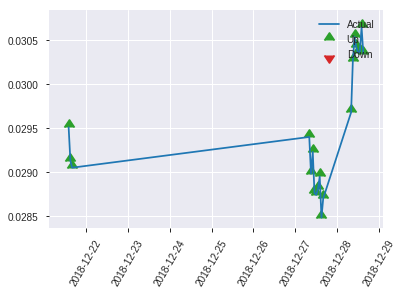


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2621154574232788
RMSE: 0.5119721256311507
LogLoss: 0.7194368923671205
Mean Per-Class Error: 0.46915177826014354
AUC: 0.5014192686592085
pr_auc: 0.49442739972203215
Gini: 0.0028385373184169893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2327072024345398: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    106  0        (0.0/106.0)
Total  1    218  0.5114   (112.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232707     0.654321  217
max f2                       0.232707     0.825545  217
max f0point5                 0.244666     0.543478  214
max accuracy                 0.662771     0.543379  11
max precision                0.662771     0.75      11
max recall                   0.232707     1         217
max specificity              0.800732     0.99115   0
max absolute_mcc             0.662771     0.128147  11
max min_per_class_accuracy   0.501097     0.490566  105
max mean_per_class_accuracy  0.519842     0.530848  85

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.717719           0.688679  0.688679           0.333333         0.74938   0.333333                    0.74938             0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.706688           1.03302   0.826415           0.5              0.710076  0.4                         0.733659            0.00943396      0.0188679                  3.30189   -17.3585
    3        0.0319635                   0.69309            2.06604   1.18059            1                0.700505  0.571429                    0.724186            0.0188679       0.0377358                  106.604   18.0593
    4        0.0410959                   0.682465           2.06604   1.37736            1                0.689546  0.666667                    0.716488            0.0188679       0.0566038                  106.604   37.7358
    5        0.0502283                   0.663426           2.06604   1.50257            1                0.67462   0.727273                    0.708876            0.0188679       0.0754717                  106.604   50.2573
    6        0.100457                    0.624902           0.563465  1.03302            0.272727         0.644991  0.5                         0.676933            0.0283019       0.103774                   -43.6535  3.30189
    7        0.150685                    0.592493           1.12693   1.06432            0.545455         0.606457  0.515152                    0.653441            0.0566038       0.160377                   12.693    6.43225
    8        0.200913                    0.573974           0.751286  0.986063           0.363636         0.585281  0.477273                    0.636401            0.0377358       0.198113                   -24.8714  -1.39365
    9        0.30137                     0.553815           0.939108  0.970412           0.454545         0.562415  0.469697                    0.611739            0.0943396       0.292453                   -6.08919  -2.95883
    10       0.401826                    0.516974           1.31475   1.0565             0.636364         0.533199  0.511364                    0.592104            0.132075        0.424528                   31.4751   5.64966
    11       0.502283                    0.495655           0.657376  0.976672           0.318182         0.506392  0.472727                    0.574962            0.0660377       0.490566                   -34.2624  -2.33276
    12       0.598174                    0.468846           0.983827  0.977819           0.47619          0.485102  0.473282                    0.560557            0.0943396       0.584906                   -1.61725  -2.21806
    13       0.69863                     0.426054           1.22084   1.01276            0.590909         0.450622  0.490196                    0.544749            0.122642        0.707547                   22.084    1.27636
    14       0.799087                    0.374298           1.12693   1.02712            0.545455         0.394368  0.497143                    0.525844            0.113208        0.820755                   12.693    2.71159
    15       0.899543                    0.327242           0.751286  0.996313           0.363636         0.35335   0.482234                    0.506581            0.0754717       0.896226                   -24.8714  -0.368739
    16       1                           0.207358           1.03302   1                  0.5              0.281288  0.484018                    0.483949 

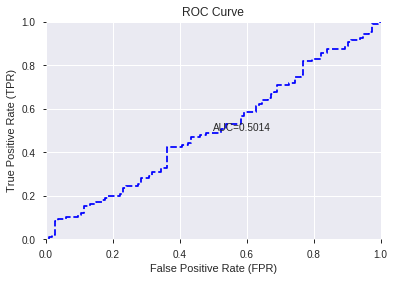

This function is available for GLM models only


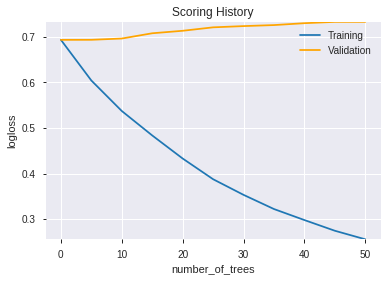

--2019-08-26 14:46:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_144556_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_144556_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'MFI_30',
 'BETA_24',
 'SAREXT',
 'AD',
 'HT_DCPERIOD',
 'hour',
 'aroondown_30',
 'STOCHRSI_fastk',
 'aroonup_12',
 'aroondown_8',
 'aroonup_14',
 'dayofweek',
 'weekday',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'is_month_end',
 'CDLMATCHINGLOW',
 'CORREL_24',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLHAMMER',
 'is_month_start',
 'CDLXSIDEGAP3METHODS',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLHANGINGMAN',
 'CDLMORNINGDOJISTAR',
 'CDLTAKURI',
 'CORREL_14',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM',
 'CDLHIKKAKEMOD',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDL2CROWS',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_12',
 'CDLSTICKSANDWICH']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_144619_model_2  0.559609  0.804122              0.491150  0.539235  0.290775
1  DeepLearning_grid_1_AutoML_20190826_144619_model_3  0.557188  1.341701              0.500000  0.638763  0.408018
2               DeepLearning_1_AutoML_20190826_144619  0.549591  2.958729              0.470195  0.715779  0.512340
3  DeepLearning_grid_1_AutoML_20190826_144619_model_7  0.509684  0.692570              0.500000  0.499711  0.249711
4  DeepLearning_grid_1_AutoML_20190826_144619_model_4  0.508265  1.518775              0.500000  0.642944  0.413377
5  DeepLearning_grid_1_AutoML_20190826_144619_model_1  0.501002  1.719363              0.478168  0.627589  0.393868
6  DeepLearning_grid_1_AutoML_20190826_144619_model_9  0.500000  0.692656              0.500000  0.499754  0.249754
7  DeepLearning_grid_1_AutoML_20190826_144619_model_8  0.493029  0.693344              0.500000  0.500098  0.250098
8  DeepLearning_grid_1_AutoML_20190826_144619_model_6  0.467774  0.699402              0.500000  0.503108  0.253118
9  DeepLearning_grid_1_AutoML_20190826_144619_model_5  0.444815  0.693007              0.495575  0.499930  0.249930

variable  relative_importance  scaled_importance  percentage
0                    dayofweek             1.000000           1.000000    0.001804
1          CDLGAPSIDESIDEWHITE             0.995099           0.995099    0.001795
2                      weekday             0.969875           0.969875    0.001750
3                    CDL2CROWS             0.902854           0.902854    0.001629
4               CDLSPINNINGTOP             0.875804           0.875804    0.001580
...                        ...                  ...                ...         ...
1031   BBANDS_lowerband_20_2_3             0.455899           0.455899    0.000822
1032                    T3_8_4             0.452968           0.452968    0.000817
1033                    MA_8_0             0.452098           0.452098    0.000816
1034  BBANDS_middleband_14_6_4             0.436550           0.436550    0.000788
1035       CDLRISEFALL3METHODS             0.426935           0.426935    0.000770

[1036 rows x 4 columns]

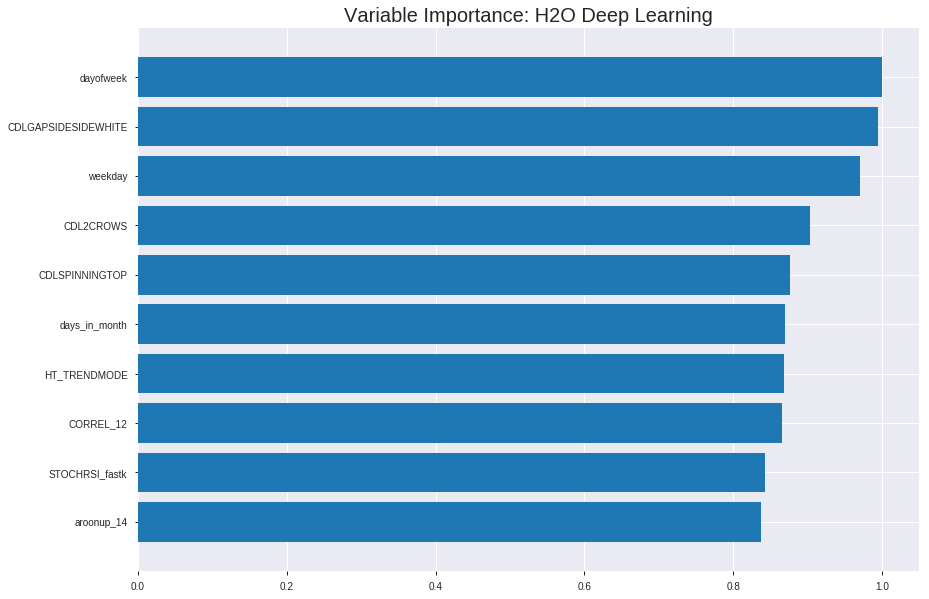

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_144619_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2588715079729806
RMSE: 0.5087941705375373
LogLoss: 0.72297608322583
Mean Per-Class Error: 0.44427174781889855
AUC: 0.5604158269056029
pr_auc: 0.5306055298104421
Gini: 0.12083165381120575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16245666941004971: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    784   0.9949   (784.0/788.0)
1      0    743   0        (0.0/743.0)
Total  4    1527  0.5121   (784.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.162457     0.654626  395
max f2                       0.162457     0.825739  395
max f0point5                 0.426129     0.554829  261
max accuracy                 0.426129     0.551927  261
max precision                0.993297     1         0
max recall                   0.162457     1         395
max specificity              0.993297     1         0
max absolute_mcc             0.426129     0.11523   261
max min_per_class_accuracy   0.465544     0.538071  232
max mean_per_class_accuracy  0.426129     0.555728  261

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 49.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.961889           1.28785   1.28785            0.625            0.980672  0.625                       0.980672            0.013459        0.013459                   28.7853   28.7853
    2        0.0202482                   0.873734           0.961597  1.12999            0.466667         0.904922  0.548387                    0.944019            0.00942127      0.0228802                  -3.84029  12.9987
    3        0.0300457                   0.840358           1.23634   1.16467            0.6              0.856887  0.565217                    0.915606            0.0121131       0.0349933                  23.6339   16.4667
    4        0.0404964                   0.821074           1.41664   1.22969            0.6875           0.832658  0.596774                    0.8942              0.0148048       0.0497981                  41.6639   22.9692
    5        0.0502939                   0.805222           0.824226  1.15071            0.4              0.814565  0.558442                    0.878687            0.00807537      0.0578735                  -17.5774  15.0705
    6        0.100588                    0.725299           1.04366   1.09718            0.506494         0.763143  0.532468                    0.820915            0.0524899       0.110363                   4.36629   9.71841
    7        0.150229                    0.644649           1.30141   1.16467            0.631579         0.68235   0.565217                    0.775128            0.064603        0.174966                   30.141    16.4667
    8        0.200523                    0.60695            1.25775   1.18801            0.61039          0.628601  0.576547                    0.738377            0.0632571       0.238223                   25.7748   18.8013
    9        0.300457                    0.550561           1.02355   1.13331            0.496732         0.576423  0.55                        0.68451             0.102288        0.340511                   2.35488   13.3311
    10       0.400392                    0.504151           1.02355   1.10592            0.496732         0.526743  0.536705                    0.645132            0.102288        0.442799                   2.35488   10.5915
    11       0.500327                    0.465178           0.983146  1.08139            0.477124         0.484304  0.524804                    0.613009            0.0982503       0.54105                    -1.68545  8.13933
    12       0.600261                    0.433739           1.13129   1.0897             0.54902          0.448735  0.528836                    0.585659            0.113055        0.654105                   13.1291   8.97005
    13       0.700196                    0.405089           0.902339  1.06296            0.437908         0.419257  0.515858                    0.56191             0.090175        0.74428                    -9.7661   6.29595
    14       0.800131                    0.373051           0.875404  1.03953            0.424837         0.389678  0.50449                     0.540398            0.0874832       0.831763                   -12.4596  3.95342
    15       0.900065                    0.318328           0.767662  1.00935            0.372549         0.349772  0.48984                     0.519233            0.076716        0.908479                   -23.2338  0.934801
    16       1                           0.139828           0.915807  1                  0.444444         0.263681  0.485304                    0.493695        



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3057664404646116
RMSE: 0.5529615180684924
LogLoss: 0.9942810901748158
Mean Per-Class Error: 0.4622222222222222
AUC: 0.5191862284820031
pr_auc: 0.5112324165795233
Gini: 0.03837245696400626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13467208436084777: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    208  0.9765   (208.0/213.0)
1      2    223  0.0089   (2.0/225.0)
Total  7    431  0.4795   (210.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.134672     0.679878   392
max f2                       0.0773196    0.840807   399
max f0point5                 0.203864     0.576377   349
max accuracy                 0.257114     0.543379   279
max precision                0.729977     0.560976   30
max recall                   0.0773196    1          399
max specificity              0.999987     0.976526   0
max absolute_mcc             0.257114     0.0828463  279
max min_per_class_accuracy   0.342258     0.502222   198
max mean_per_class_accuracy  0.257114     0.537778   279

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 40.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.999987           1.168     1.168              0.6              0.999993  0.6                         0.999993            0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   0.999925           0.486667  0.865185           0.25             0.999966  0.444444                    0.999981            0.00444444      0.0177778                  -51.3333  -13.4815
    3        0.0319635                   0.998634           0.778667  0.834286           0.4              0.999534  0.428571                    0.999821            0.00888889      0.0266667                  -22.1333  -16.5714
    4        0.0410959                   0.992453           0         0.648889           0                0.995775  0.333333                    0.998922            0               0.0266667                  -100      -35.1111
    5        0.0502283                   0.949927           1.94667   0.884848           1                0.973394  0.454545                    0.994281            0.0177778       0.0444444                  94.6667   -11.5152
    6        0.100457                    0.716737           1.1503    1.01758            0.590909         0.813516  0.522727                    0.903898            0.0577778       0.102222                   15.0303   1.75758
    7        0.150685                    0.605864           0.973333  1.00283            0.5              0.657711  0.515152                    0.821836            0.0488889       0.151111                   -2.66667  0.282828
    8        0.200913                    0.551057           1.06182   1.01758            0.545455         0.580329  0.522727                    0.761459            0.0533333       0.204444                   6.18182   1.75758
    9        0.30137                     0.455752           1.01758   1.01758            0.522727         0.502813  0.522727                    0.675244            0.102222        0.306667                   1.75758   1.75758
    10       0.399543                    0.389334           0.905426  0.990019           0.465116         0.425502  0.508571                    0.613879            0.0888889       0.395556                   -9.45736  -0.998095
    11       0.5                         0.340853           1.06182   1.00444            0.545455         0.363986  0.515982                    0.563672            0.106667        0.502222                   6.18182   0.444444
    12       0.600457                    0.29727            1.19455   1.03625            0.613636         0.316635  0.532319                    0.522342            0.12            0.622222                   19.4545   3.62484
    13       0.69863                     0.258065           1.08651   1.04331            0.55814          0.280082  0.535948                    0.488299            0.106667        0.728889                   8.65116   4.33115
    14       0.799087                    0.235781           0.840606  1.01783            0.431818         0.247681  0.522857                    0.45805             0.0844444       0.813333                   -15.9394  1.78286
    15       0.899543                    0.194354           1.06182   1.02274            0.545455         0.217119  0.525381                    0.431144            0.106667        0.92                       6.18182   2.27411
    16       1                           0.0773196          0.796364  1                  0.409091         0.159023  0.513699                    0.403808    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:49:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:49:05  2 min 44.716 sec  448 obs/sec       0.578707  1             886        0.655795         4.37464             -0.721754      0.535681        0.445522           1.15907          0.514696                         0.71538            9.42957               -1.04861         0.490788          0.488953             0.898462           0.486301
    2019-08-26 14:49:19  2 min 58.287 sec  379 obs/sec       3.54278   6             5424       0.536369         0.857039            -0.151762      0.575543        0.530051           1.03028          0.504246                         0.656658           2.07078               -0.726096        0.490308          0.512093             1.55733            0.486301
    2019-08-26 14:49:33  3 min 12.227 sec  401 obs/sec       7.06858   12            10822      0.544761         0.895168            -0.188084      0.535772        0.4951             0.643927         0.483344                         0.689444           3.2845                -0.90276         0.508659          0.507788             1.168              0.479452
    2019-08-26 14:49:46  3 min 25.392 sec  417 obs/sec       10.6088   18            16242      0.508794         0.722976            -0.0363814     0.560416        0.530606           1.28785          0.512084                         0.552962           0.994281              -0.223984        0.519186          0.511232             1.168              0.479452
    2019-08-26 14:49:59  3 min 38.094 sec  428 obs/sec       14.1019   24            21590      0.528462         0.78035             -0.118053      0.536367        0.50464            1.28785          0.499673                         0.684027           2.53972               -0.872978        0.507272          0.548098             1.55733            0.484018
    2019-08-26 14:50:11  3 min 50.655 sec  436 obs/sec       17.6068   30            26956      0.506831         0.718083            -0.028401      0.589231        0.583309           1.54542          0.504246                         0.64797            1.46629               -0.680721        0.501221          0.508506             1.168              0.477169
    2019-08-26 14:50:25  4 min  4.583 sec  446 obs/sec       21.7244   37            33260      0.533284         0.788173            -0.138551      0.566102        0.54058            1.67421          0.509471                         0.649137           1.42253               -0.686779        0.521137          0.525573             1.168              0.481735
    2019-08-26 14:50:39  4 min 18.094 sec  456 obs/sec       25.825    44            39538      0.547619         0.97781             -0.200581      0.561985        0.504338           0.643927         0.468975                         0.696271           4.89479               -0.94063         0.50578           0.482585             1.168              0.481735
    2019-08-26 14:50:52

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
dayofweek                 1.0                    1.0                  0.001803942365586014
CDLGAPSIDESIDEWHITE       0.9950993061065674     0.9950993061065674   0.0017951017962508822
weekday                   0.969874918460846      0.969874918460846    0.0017495984547308008
CDL2CROWS                 0.9028542041778564     0.9028542041778564   0.0016286969488638803
CDLSPINNINGTOP            0.8758044838905334     0.8758044838905334   0.0015799008124603268
---                       ---                    ---                  ---
BBANDS_lowerband_20_2_3   0.45589929819107056    0.45589929819107056  0.0008224160584478033
T3_8_4                    0.45296767354011536    0.45296767354011536  0.000817127576539949
MA_8_0                    0.45209801197052       0.45209801197052     0.0008155587571908339
BBANDS_middleband_14_6_4  0.4365496337413788     0.4365496337413788   0.0007875103789871308
CDLRISEFALL3METHODS       0.4269351065158844     0.4269351065158844   0.0007701663259999813


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.589041095890411)

('F1', 0.6563467492260062)

('auc', 0.5596092836867591)

('logloss', 0.8041219683133836)

('mean_per_class_error', 0.4195608615795625)

('rmse', 0.5392353880166854)

('mse', 0.2907748036895052)

deeplearning prediction progress: |███████████████████████████████████████| 100%


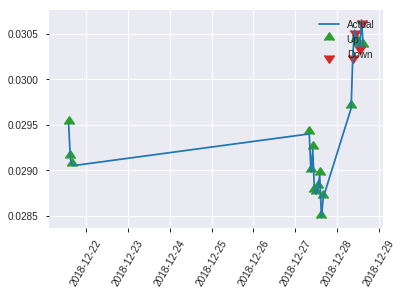


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2907748036895052
RMSE: 0.5392353880166854
LogLoss: 0.8041219683133836
Mean Per-Class Error: 0.4195608615795625
AUC: 0.5596092836867591
pr_auc: 0.542324269399226
Gini: 0.11921856737351821
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1036172896265904: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    106  0        (0.0/106.0)
Total  2    217  0.5068   (111.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.103617     0.656347  216
max f2                       0.103617     0.826833  216
max f0point5                 0.152473     0.556845  188
max accuracy                 0.410245     0.589041  49
max precision                0.902083     1         0
max recall                   0.103617     1         216
max specificity              0.902083     1         0
max absolute_mcc             0.410245     0.191541  49
max min_per_class_accuracy   0.294852     0.539823  109
max mean_per_class_accuracy  0.410245     0.580439  49

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 31.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.869899           1.37736   1.37736            0.666667         0.889747  0.666667                    0.889747            0.0188679       0.0188679                  37.7358   37.7358
    2        0.0228311                   0.835958           1.03302   1.23962            0.5              0.845206  0.6                         0.87193             0.00943396      0.0283019                  3.30189   23.9623
    3        0.0319635                   0.811619           2.06604   1.47574            1                0.824041  0.714286                    0.858248            0.0188679       0.0471698                  106.604   47.5741
    4        0.0410959                   0.781682           0         1.1478             0                0.806215  0.555556                    0.846685            0               0.0471698                  -100      14.7799
    5        0.0502283                   0.75359            1.03302   1.12693            0.5              0.769196  0.545455                    0.832596            0.00943396      0.0566038                  3.30189   12.693
    6        0.100457                    0.520233           1.50257   1.31475            0.727273         0.596773  0.636364                    0.714685            0.0754717       0.132075                   50.2573   31.4751
    7        0.150685                    0.453937           1.12693   1.25214            0.545455         0.490092  0.606061                    0.63982             0.0566038       0.188679                   12.693    25.2144
    8        0.200913                    0.420506           1.69039   1.36171            0.818182         0.4354    0.659091                    0.588715            0.0849057       0.273585                   69.0395   36.1707
    9        0.30137                     0.366947           1.03302   1.25214            0.5              0.392539  0.606061                    0.523323            0.103774        0.377358                   3.30189   25.2144
    10       0.401826                    0.334823           0.469554  1.0565             0.227273         0.345441  0.511364                    0.478852            0.0471698       0.424528                   -53.0446  5.64966
    11       0.502283                    0.294852           1.22084   1.08937            0.590909         0.30948   0.527273                    0.444978            0.122642        0.54717                    22.084    8.93654
    12       0.598174                    0.243174           0.885445  1.05668            0.428571         0.262842  0.51145                     0.415781            0.0849057       0.632075                   -11.4555  5.66758
    13       0.69863                     0.200711           0.845197  1.02627            0.409091         0.221011  0.496732                    0.387774            0.0849057       0.716981                   -15.4803  2.62671
    14       0.799087                    0.168097           0.939108  1.01531            0.454545         0.184142  0.491429                    0.362175            0.0943396       0.811321                   -6.08919  1.531
    15       0.899543                    0.141995           1.12693   1.02778            0.545455         0.155255  0.497462                    0.339067            0.113208        0.924528                   12.693    2.77751
    16       1                           0.0817942          0.751286  1                  0.363636         0.121896  0.484018                    0.317251            

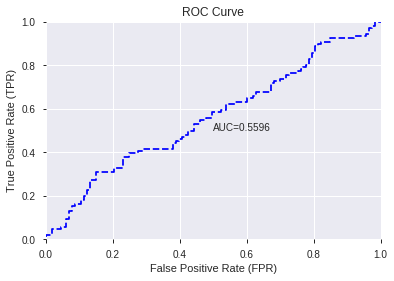

This function is available for GLM models only


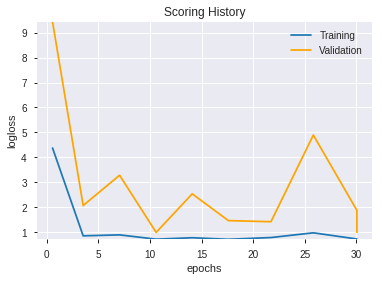

--2019-08-26 15:19:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_144619_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_144619_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['dayofweek',
 'CDLGAPSIDESIDEWHITE',
 'weekday',
 'CDL2CROWS',
 'CDLSPINNINGTOP',
 'days_in_month',
 'HT_TRENDMODE',
 'CORREL_12',
 'STOCHRSI_fastk',
 'aroonup_14',
 'weekday_name',
 'aroonup_12',
 'CDLSHOOTINGSTAR',
 'aroonup_20',
 'CDLHIKKAKEMOD',
 'hour',
 'AD',
 'CORREL_14',
 'BETA_24',
 'CDLLONGLEGGEDDOJI',
 'day',
 'HT_PHASOR_quadrature',
 'BETA_20',
 'AROONOSC_8',
 'SAREXT',
 'MFI_30',
 'aroondown_14',
 'BOP',
 'BETA_8',
 'CDLSTICKSANDWICH',
 'aroondown_8',
 'CDL3OUTSIDE',
 'STOCHRSI_fastd',
 'CDLDOJI',
 'BETA_14',
 'BETA_30',
 'HT_DCPERIOD',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'MFI_12',
 'CDLHIGHWAVE',
 'aroonup_8',
 'aroonup_30',
 'BETA_12',
 'Volume',
 'MFI_8',
 'CDLPIERCING',
 'STOCH_slowd',
 'aroondown_12',
 'CDLRICKSHAWMAN',
 'AROONOSC_20',
 'DX_8',
 'CDLDARKCLOUDCOVER',
 'MFI_14',
 'SUB',
 'CDLSHORTLINE',
 'aroondown_30',
 'ULTOSC',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'aroondown_20',
 'aroonup_24',
 'CDLMORNINGSTAR',
 'month',
 'DX_20',
 'DX_12',
 'CDLBELTHOLD',
 '

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_151908_model_1  0.544415  0.691557              0.433002  0.499204  0.249204

variable  relative_importance  scaled_importance    percentage
0               CDLMORNINGSTAR         7.733173e-03           1.000000  1.229907e-02
1                         DX_8         6.982275e-03           0.902899  1.110482e-02
2               CDLSPINNINGTOP         6.817615e-03           0.881606  1.084294e-02
3                           AD         6.791099e-03           0.878178  1.080076e-02
4                  CDL3OUTSIDE         6.438814e-03           0.832623  1.024048e-02
...                        ...                  ...                ...           ...
1031                    TRANGE         1.430673e-06           0.000185  2.275385e-06
1032   BBANDS_lowerband_30_0_2         1.192655e-06           0.000154  1.896833e-06
1033   BBANDS_lowerband_24_3_2         8.077570e-07           0.000104  1.284680e-06
1034  BBANDS_middleband_12_5_2         5.219642e-07           0.000067  8.301472e-07
1035    BBANDS_upperband_8_4_5         3.939189e-07           0.000051  6.265002e-07

[1036 rows x 4 columns]

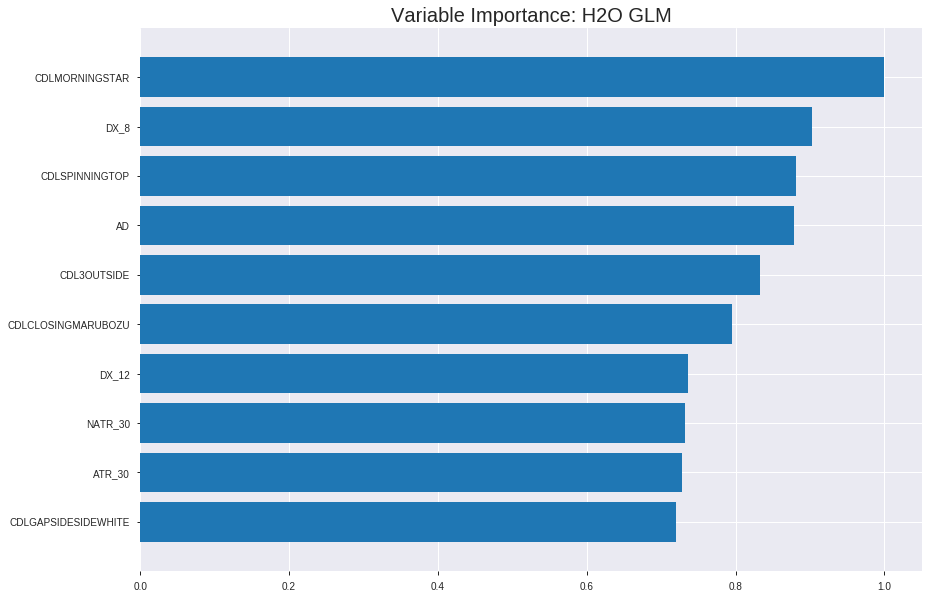

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_151908_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24589404065166098
RMSE: 0.49587704186790194
LogLoss: 0.6849084067405206
Null degrees of freedom: 1530
Residual degrees of freedom: 494
Null deviance: 2121.0938114372193
Residual deviance: 2097.189541439474
AIC: 4171.189541439474
AUC: 0.5975483531573877
pr_auc: 0.5774312614373639
Gini: 0.1950967063147755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43920226372179877: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   759   0.9632   (759.0/788.0)
1      8    735   0.0108   (8.0/743.0)
Total  37   1494  0.501    (767.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439202     0.65713   376
max f2                       0.42988      0.825739  395
max f0point5                 0.476384     0.569204  248
max accuracy                 0.483699     0.570869  214
max precision                0.618125     1         0
max recall                   0.42988      1         395
max specificity              0.618125     1         0
max absolute_mcc             0.476384     0.151078  248
max min_per_class_accuracy   0.483699     0.569314  214
max mean_per_class_accuracy  0.476384     0.573245  248

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104507                   0.562014           1.54542   1.54542            0.75             0.582612  0.75                        0.582612            0.0161507       0.0161507                  54.5424    54.5424
    2        0.0202482                   0.549959           1.37371   1.46234            0.666667         0.555628  0.709677                    0.569555            0.013459        0.0296097                  37.371     46.2337
    3        0.0300457                   0.54043            1.64845   1.52303            0.8              0.545061  0.73913                     0.561568            0.0161507       0.0457604                  64.8452    52.3027
    4        0.0404964                   0.533861           1.80299   1.59528            0.875            0.53754   0.774194                    0.555367            0.0188425       0.064603                   80.2995    59.5276
    5        0.0502939                   0.528672           1.23634   1.52535            0.6              0.530934  0.74026                     0.550607            0.0121131       0.076716                   23.6339    52.5354
    6        0.100588                    0.516292           1.23099   1.37817            0.597403         0.522132  0.668831                    0.53637             0.0619112       0.138627                   23.0987    37.817
    7        0.150229                    0.509285           1.11162   1.29009            0.539474         0.512502  0.626087                    0.528483            0.0551817       0.193809                   11.1621    29.0093
    8        0.200523                    0.504245           1.07042   1.235              0.519481         0.50653   0.599349                    0.522977            0.0538358       0.247645                   7.04235    23.4997
    9        0.300457                    0.495913           1.14476   1.20498            0.555556         0.500012  0.584783                    0.515339            0.114401        0.362046                   14.4758    20.4983
    10       0.400392                    0.488815           1.05048   1.16642            0.509804         0.492295  0.566069                    0.509587            0.10498         0.467026                   5.04843    16.6421
    11       0.500327                    0.483402           1.05048   1.14326            0.509804         0.486069  0.55483                     0.50489             0.10498         0.572005                   5.04843    14.3264
    12       0.600261                    0.477722           0.996613  1.11885            0.48366          0.480559  0.542982                    0.500839            0.0995962       0.671602                   -0.338673  11.8849
    13       0.700196                    0.471371           0.875404  1.0841             0.424837         0.474557  0.526119                    0.497088            0.0874832       0.759085                   -12.4596   8.41034
    14       0.800131                    0.464711           0.969678  1.06981            0.470588         0.467808  0.519184                    0.493431            0.0969044       0.855989                   -3.03222   6.98118
    15       0.900065                    0.454964           0.754194  1.03477            0.366013         0.460152  0.502177                    0.489736            0.0753701       0.931359                   -24.5806   3.47686
    16       1                           0.419632           0.686855  1                  0.333333         0.445384  0.485304                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2518120562398155
RMSE: 0.5018087845383095
LogLoss: 0.6968016400163507
Null degrees of freedom: 437
Residual degrees of freedom: -599
Null deviance: 608.2811161936828
Residual deviance: 610.3982366543233
AIC: 2684.3982366543232
AUC: 0.48881585811163275
pr_auc: 0.5106048899293845
Gini: -0.0223682837767345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43922876366510516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    225  0        (0.0/225.0)
Total  1    437  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.439229     0.679758   398
max f2                       0.439229     0.841436   398
max f0point5                 0.445051     0.570917   393
max accuracy                 0.473341     0.520548   299
max precision                0.673206     1          0
max recall                   0.439229     1          398
max specificity              0.673206     1          0
max absolute_mcc             0.65422      0.0808006  2
max min_per_class_accuracy   0.492191     0.483568   200
max mean_per_class_accuracy  0.535032     0.515524   43

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.641405           1.168     1.168              0.6              0.657781  0.6                         0.657781            0.0133333       0.0133333                  16.8       16.8
    2        0.0205479                   0.609925           0.486667  0.865185           0.25             0.632101  0.444444                    0.646368            0.00444444      0.0177778                  -51.3333   -13.4815
    3        0.0319635                   0.562341           1.168     0.973333           0.6              0.58884   0.5                         0.625822            0.0133333       0.0311111                  16.8       -2.66667
    4        0.0410959                   0.55456            0.486667  0.865185           0.25             0.556796  0.444444                    0.610483            0.00444444      0.0355556                  -51.3333   -13.4815
    5        0.0502283                   0.54922            1.46      0.973333           0.75             0.551482  0.5                         0.599756            0.0133333       0.0488889                  46         -2.66667
    6        0.100457                    0.5348             1.32727   1.1503             0.681818         0.541081  0.590909                    0.570418            0.0666667       0.115556                   32.7273    15.0303
    7        0.150685                    0.526255           0.796364  1.03232            0.409091         0.530717  0.530303                    0.557184            0.04            0.155556                   -20.3636   3.23232
    8        0.200913                    0.521443           1.06182   1.0397             0.545455         0.524092  0.534091                    0.548911            0.0533333       0.208889                   6.18182    3.9697
    9        0.30137                     0.511356           0.796364  0.958586           0.409091         0.515941  0.492424                    0.537921            0.08            0.288889                   -20.3636   -4.14141
    10       0.399543                    0.499355           0.995969  0.967771           0.511628         0.504487  0.497143                    0.529706            0.0977778       0.386667                   -0.403101  -3.22286
    11       0.5                         0.492138           0.973333  0.968889           0.5              0.495402  0.497717                    0.522814            0.0977778       0.484444                   -2.66667   -3.11111
    12       0.600457                    0.483059           0.929091  0.962231           0.477273         0.488091  0.494297                    0.517005            0.0933333       0.577778                   -7.09091   -3.77693
    13       0.69863                     0.476593           1.22233   0.99878            0.627907         0.479066  0.513072                    0.511673            0.12            0.697778                   22.2326    -0.122004
    14       0.799087                    0.469781           0.973333  0.995581           0.5              0.473375  0.511429                    0.506859            0.0977778       0.795556                   -2.66667   -0.441905
    15       0.899543                    0.459538           0.973333  0.993096           0.5              0.465463  0.510152                    0.502236            0.0977778       0.893333                   -2.66667   -0.690355
    16       1                           0.435478           1.06182   1                  0.545455         0.451327  0.513699          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 15:19:11  0.000 sec   2            3.7       1037          1.36982           1.3936
    2019-08-26 15:19:13  1.717 sec   4            2.7       1037          1.36635           1.39468
    2019-08-26 15:19:14  3.476 sec   6            2         1037          1.36235           1.39669
    2019-08-26 15:19:16  5.208 sec   8            1.4       1037          1.35784           1.39926
    2019-08-26 15:19:18  6.930 sec   10           1         1037          1.35277           1.40274

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5570776255707762)

('F1', 0.6572438162544171)

('auc', 0.5444147603940558)

('logloss', 0.6915571228249207)

('mean_per_class_error', 0.4330021706461846)

('rmse', 0.4992035665387303)

('mse', 0.24920420084498854)

glm prediction progress: |████████████████████████████████████████████████| 100%


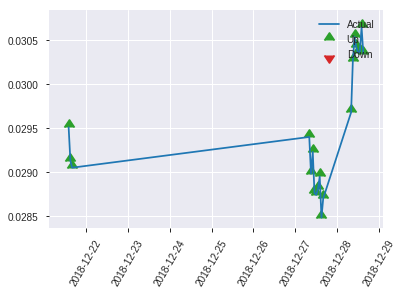


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24920420084498854
RMSE: 0.4992035665387303
LogLoss: 0.6915571228249207
Null degrees of freedom: 218
Residual degrees of freedom: -818
Null deviance: 303.37613151001983
Residual deviance: 302.90201979731523
AIC: 2376.902019797315
AUC: 0.5444147603940558
pr_auc: 0.5152079416389065
Gini: 0.08882952078811157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4887182315392386: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   84   0.7434   (84.0/113.0)
1      13   93   0.1226   (13.0/106.0)
Total  42   177  0.4429   (97.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488718     0.657244  176
max f2                       0.451977     0.824261  218
max f0point5                 0.488718     0.571253  176
max accuracy                 0.488718     0.557078  176
max precision                0.540048     0.666667  2
max recall                   0.451977     1         218
max specificity              0.55434      0.99115   0
max absolute_mcc             0.488718     0.170087  176
max min_per_class_accuracy   0.50477      0.513274  109
max mean_per_class_accuracy  0.488718     0.566998  176

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.539519           1.37736   1.37736            0.666667         0.544985  0.666667                    0.544985            0.0188679       0.0188679                  37.7358   37.7358
    2        0.0228311                   0.537004           0         0.826415           0                0.537091  0.4                         0.541828            0               0.0188679                  -100      -17.3585
    3        0.0319635                   0.533655           0         0.590296           0                0.535927  0.285714                    0.540142            0               0.0188679                  -100      -40.9704
    4        0.0410959                   0.530834           2.06604   0.918239           1                0.532167  0.444444                    0.53837             0.0188679       0.0377358                  106.604   -8.1761
    5        0.0502283                   0.529855           2.06604   1.12693            1                0.530383  0.545455                    0.536918            0.0188679       0.0566038                  106.604   12.693
    6        0.100457                    0.523235           1.50257   1.31475            0.727273         0.52604   0.636364                    0.531479            0.0754717       0.132075                   50.2573   31.4751
    7        0.150685                    0.521167           0.751286  1.12693            0.363636         0.522159  0.545455                    0.528372            0.0377358       0.169811                   -24.8714  12.693
    8        0.200913                    0.518659           1.31475   1.17389            0.636364         0.519866  0.568182                    0.526246            0.0660377       0.235849                   31.4751   17.3885
    9        0.30137                     0.51387            1.03302   1.12693            0.5              0.516054  0.545455                    0.522849            0.103774        0.339623                   3.30189   12.693
    10       0.401826                    0.508855           0.751286  1.03302            0.363636         0.510943  0.5                         0.519872            0.0754717       0.415094                   -24.8714  3.30189
    11       0.502283                    0.50477            1.03302   1.03302            0.5              0.506662  0.5                         0.51723             0.103774        0.518868                   3.30189   3.30189
    12       0.598174                    0.501019           1.08221   1.0409             0.52381          0.503083  0.503817                    0.514962            0.103774        0.622642                   8.22102   4.09045
    13       0.69863                     0.494818           1.12693   1.05327            0.545455         0.498237  0.509804                    0.512557            0.113208        0.735849                   12.693    5.32741
    14       0.799087                    0.489351           1.22084   1.07434            0.590909         0.49188   0.52                        0.509958            0.122642        0.858491                   22.084    7.43396
    15       0.899543                    0.480987           0.469554  1.0068             0.227273         0.485256  0.48731                     0.507199            0.0471698       0.90566                    -53.0446  0.680011
    16       1                           0.451977           0.939108  1                  0.454545         0.472955  0.484018                    0.503759         

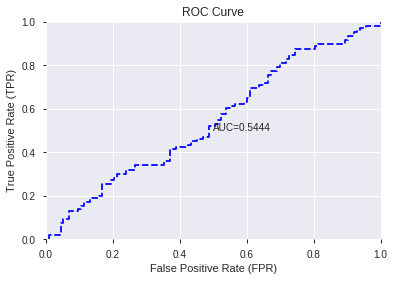

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


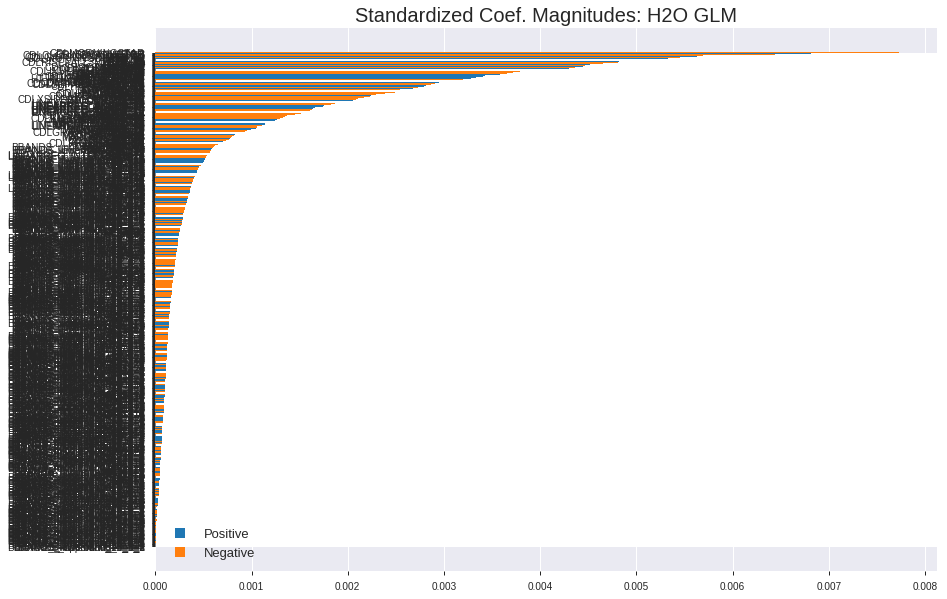

'log_likelihood'
--2019-08-26 15:19:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.135.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.135.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_151908_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_151908_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLMORNINGSTAR',
 'DX_8',
 'CDLSPINNINGTOP',
 'AD',
 'CDL3OUTSIDE',
 'CDLCLOSINGMARUBOZU',
 'DX_12',
 'NATR_30',
 'ATR_30',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'DX_14',
 'ATR_24',
 'NATR_24',
 'BETA_24',
 'ATR_20',
 'DX_20',
 'DX_24',
 'NATR_20',
 'CDLRISEFALL3METHODS',
 'month',
 'ADX_8',
 'DX_30',
 'BETA_20',
 'ATR_14',
 'is_month_end',
 'dayofyear',
 'week',
 'weekofyear',
 'CDLSHOOTINGSTAR',
 'NATR_14',
 'CDL3LINESTRIKE',
 'BETA_8',
 'ATR_12',
 'CDL2CROWS',
 'ADXR_8',
 'CDLEVENINGSTAR',
 'NATR_12',
 'CDLINVERTEDHAMMER',
 'days_in_month',
 'BETA_30',
 'CDLBELTHOLD',
 'ADX_12',
 'ATR_8',
 'CDLPIERCING',
 'CDLHIGHWAVE',
 'PLUS_DM_30',
 'NATR_8',
 'MINUS_DM_30',
 'CDLHOMINGPIGEON',
 'CDLLADDERBOTTOM',
 'MINUS_DM_24',
 'CDLUNIQUE3RIVER',
 'day',
 'MINUS_DM_20',
 'HT_PHASOR_quadrature',
 'CDLHARAMI',
 'MINUS_DM_14',
 'CDLLONGLINE',
 'CDLTHRUSTING',
 'PLUS_DM_24',
 'CDLSTICKSANDWICH',
 'MINUS_DM_12',
 'CDLDARKCLOUDCOVER',
 'CDLSEPARATINGLINES',
 'ADX_14',
 'quarter',
 'MOM_1

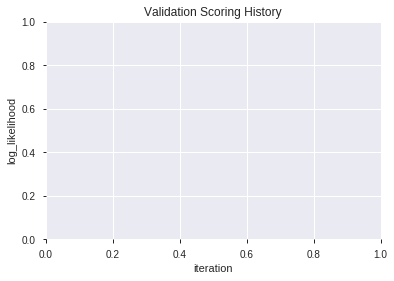

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_151943  0.533729  0.694340              0.500000  0.500481  0.250482
1  XGBoost_grid_1_AutoML_20190826_151943_model_7  0.523961  0.702455              0.436258  0.504325  0.254344
2  XGBoost_grid_1_AutoML_20190826_151943_model_1  0.520538  0.696723              0.495575  0.501614  0.251617
3  XGBoost_grid_1_AutoML_20190826_151943_model_6  0.516864  0.698388              0.500000  0.502445  0.252451
4  XGBoost_grid_1_AutoML_20190826_151943_model_5  0.515111  0.713182              0.500000  0.509315  0.259401
5               XGBoost_1_AutoML_20190826_151943  0.498915  0.706709              0.486726  0.506599  0.256642
6  XGBoost_grid_1_AutoML_20190826_151943_model_3  0.496327  0.702952              0.500000  0.504692  0.254714
7  XGBoost_grid_1_AutoML_20190826_151943_model_4  0.493238  0.698905              0.500000  0.502752  0.252759
8               XGBoost_2_AutoML_20190826_151943  0.484555  0.708279              0.491150  0.507179  0.257230
9  XGBoost_grid_1_AutoML_20190826_151943_model_2  0.471281  0.703511              0.491443  0.505019  0.255044

variable  relative_importance  scaled_importance  percentage
0                      DX_14           144.949783           1.000000    0.026203
1                    BETA_30           135.301590           0.933438    0.024459
2                        BOP           127.532219           0.879837    0.023054
3                     CCI_20           113.672874           0.784222    0.020549
4                     ULTOSC           109.007294           0.752035    0.019705
..                       ...                  ...                ...         ...
296                      Low             0.867115           0.005982    0.000157
297                   ROCP_8             0.499344           0.003445    0.000090
298                   ROCR_8             0.108827           0.000751    0.000020
299             HT_TRENDMODE             0.056166           0.000387    0.000010
300  BBANDS_upperband_24_1_2             0.050107           0.000346    0.000009

[301 rows x 4 columns]

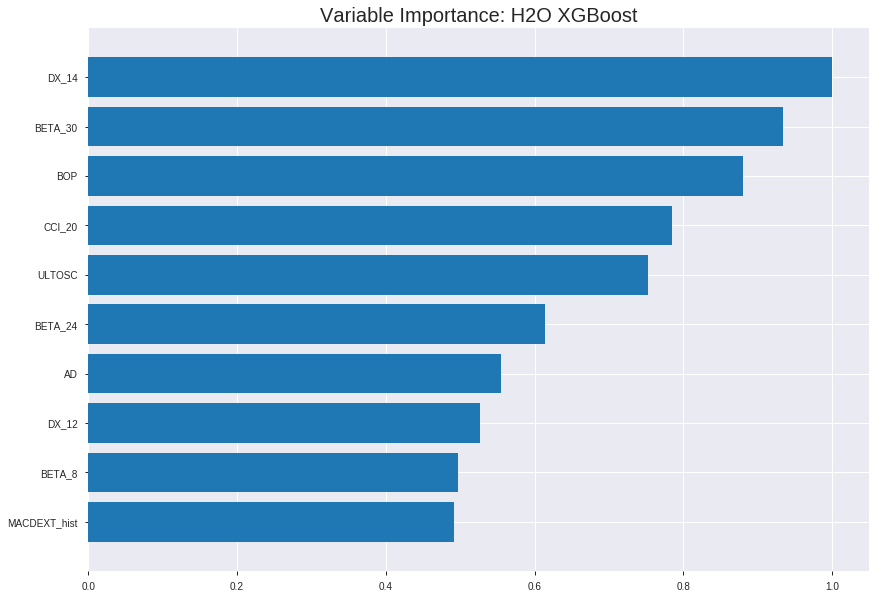

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_151943


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16827355952133752
RMSE: 0.4102116033480008
LogLoss: 0.5236439298097123
Mean Per-Class Error: 0.12311352658655061
AUC: 0.9504316087203066
pr_auc: 0.9492551651997417
Gini: 0.9008632174406133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47179600099722546: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      658  130  0.165    (130.0/788.0)
1      63   680  0.0848   (63.0/743.0)
Total  721  810  0.1261   (193.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471796     0.875724  214
max f2                       0.443755     0.916217  240
max f0point5                 0.522374     0.88647   170
max accuracy                 0.4855       0.876551  203
max precision                0.793877     1         0
max recall                   0.337209     1         331
max specificity              0.793877     1         0
max absolute_mcc             0.4855       0.753447  203
max min_per_class_accuracy   0.49003      0.871827  199
max mean_per_class_accuracy  0.4855       0.876886  203

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.743513           2.06057    2.06057            1                0.762347  1                           0.762347            0.0215343       0.0215343                  106.057   106.057
    2        0.0202482                   0.726175           2.06057    2.06057            1                0.733588  1                           0.748431            0.0201884       0.0417227                  106.057   106.057
    3        0.0300457                   0.717735           2.06057    2.06057            1                0.721939  1                           0.739792            0.0201884       0.0619112                  106.057   106.057
    4        0.0404964                   0.705557           2.06057    2.06057            1                0.710829  1                           0.732318            0.0215343       0.0834455                  106.057   106.057
    5        0.0502939                   0.698957           2.06057    2.06057            1                0.70259   1                           0.726527            0.0201884       0.103634                   106.057   106.057
    6        0.100588                    0.656872           2.06057    2.06057            1                0.675825  1                           0.701176            0.103634        0.207268                   106.057   106.057
    7        0.150229                    0.633091           2.06057    2.06057            1                0.644359  1                           0.682402            0.102288        0.309556                   106.057   106.057
    8        0.200523                    0.609976           2.06057    2.06057            1                0.621493  1                           0.667125            0.103634        0.41319                    106.057   106.057
    9        0.300457                    0.564311           1.88548    2.00233            0.915033         0.587354  0.971739                    0.640593            0.188425        0.601615                   88.5485   100.233
    10       0.400392                    0.523086           1.58919    1.89922            0.771242         0.543955  0.921697                    0.616473            0.158816        0.760431                   58.9194   89.9216
    11       0.500327                    0.485342           1.27944    1.77542            0.620915         0.505348  0.861619                    0.594277            0.12786         0.888291                   27.9436   77.5422
    12       0.600261                    0.443569           0.713791   1.59868            0.346405         0.462433  0.775843                    0.572327            0.0713324       0.959623                   -28.6209  59.8676
    13       0.700196                    0.402458           0.228952   1.40318            0.111111         0.423055  0.68097                     0.551022            0.0228802       0.982503                   -77.1048  40.3183
    14       0.800131                    0.368465           0.134677   1.24475            0.0653595        0.386474  0.604082                    0.53047             0.013459        0.995962                   -86.5323  24.475
    15       0.900065                    0.318623           0.0404032  1.11103            0.0196078        0.343476  0.539187                    0.509708            0.00403769      1                          -95.9597  11.103
    16       1                           0.203607           0          1                  0                0.274216  0.485304                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2586105243150556
RMSE: 0.5085376331354993
LogLoss: 0.7111305952755178
Mean Per-Class Error: 0.48184663536776207
AUC: 0.4959207094418362
pr_auc: 0.5162475520550737
Gini: -0.008158581116327612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27272963523864746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    225  0        (0.0/225.0)
Total  1    437  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.27273      0.679758   398
max f2                       0.27273      0.841436   398
max f0point5                 0.27273      0.570198   398
max accuracy                 0.349053     0.515982   368
max precision                0.688936     0.75       3
max recall                   0.27273      1          398
max specificity              0.722229     0.995305   0
max absolute_mcc             0.657284     0.0644867  7
max min_per_class_accuracy   0.484446     0.507042   195
max mean_per_class_accuracy  0.514613     0.518153   133

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.671292           1.168     1.168              0.6              0.695255  0.6                         0.695255            0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   0.649429           1.46      1.29778            0.75             0.657431  0.666667                    0.678444            0.0133333       0.0266667                  46        29.7778
    3        0.0319635                   0.633242           0.778667  1.11238            0.4              0.640287  0.571429                    0.664817            0.00888889      0.0355556                  -22.1333  11.2381
    4        0.0410959                   0.62272            0.973333  1.08148            0.5              0.629572  0.555556                    0.656984            0.00888889      0.0444444                  -2.66667  8.14815
    5        0.0502283                   0.611392           0.486667  0.973333           0.25             0.614803  0.5                         0.649315            0.00444444      0.0488889                  -51.3333  -2.66667
    6        0.100457                    0.585624           0.973333  0.973333           0.5              0.596572  0.5                         0.622944            0.0488889       0.0977778                  -2.66667  -2.66667
    7        0.150685                    0.564856           0.973333  0.973333           0.5              0.575735  0.5                         0.607207            0.0488889       0.146667                   -2.66667  -2.66667
    8        0.200913                    0.546559           0.884848  0.951212           0.454545         0.556112  0.488636                    0.594433            0.0444444       0.191111                   -11.5152  -4.87879
    9        0.30137                     0.519762           1.10606   1.00283            0.568182         0.534644  0.515152                    0.574504            0.111111        0.302222                   10.6061   0.282828
    10       0.399543                    0.504855           1.13178   1.03451            0.581395         0.512171  0.531429                    0.559188            0.111111        0.413333                   13.1783   3.45143
    11       0.5                         0.485016           0.929091  1.01333            0.477273         0.494164  0.520548                    0.546123            0.0933333       0.506667                   -7.09091  1.33333
    12       0.600457                    0.462764           0.884848  0.991838           0.454545         0.473691  0.509506                    0.534005            0.0888889       0.595556                   -11.5152  -0.816223
    13       0.69863                     0.443751           0.860155  0.973333           0.44186          0.453562  0.5                         0.522701            0.0844444       0.68                       -13.9845  -2.66667
    14       0.799087                    0.41317            1.01758   0.978895           0.522727         0.43148   0.502857                    0.511234            0.102222        0.782222                   1.75758   -2.11048
    15       0.899543                    0.365403           1.10606   0.993096           0.568182         0.393778  0.510152                    0.498117            0.111111        0.893333                   10.6061   -0.690355
    16       1                           0.233894           1.06182   1                  0.545455         0.326305  0.513699                    0.480857 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:19:54  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.514696                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-26 15:19:54  0.599 sec   5                  0.487537         0.668473            0.78685         0.767489           2.06057          0.322012                         0.500123           0.693401              0.516234          0.55563              1.94667            0.486301
    2019-08-26 15:19:55  0.825 sec   10                 0.475514         0.645101            0.843402        0.831646           2.06057          0.242978                         0.501876           0.69696               0.504778          0.518671             1.168              0.484018
    2019-08-26 15:19:55  1.011 sec   15                 0.466016         0.626846            0.867293        0.858174           2.06057          0.22469                          0.503742           0.700808              0.495764          0.505381             1.168              0.484018
    2019-08-26 15:19:55  1.207 sec   20                 0.455613         0.607073            0.884537        0.878429           2.06057          0.200523                         0.505517           0.70456               0.503495          0.50886              0.389333           0.484018
    2019-08-26 15:19:55  1.404 sec   25                 0.44576          0.588655            0.905581        0.902008           2.06057          0.181581                         0.50747            0.70878               0.498508          0.510529             0.778667           0.484018
    2019-08-26 15:19:55  1.595 sec   30                 0.437528         0.573368            0.917287        0.913792           2.06057          0.158067                         0.507165           0.708197              0.500939          0.514105             0.778667           0.484018
    2019-08-26 15:19:55  1.786 sec   35                 0.430007         0.559482            0.927712        0.925592           2.06057          0.151535                         0.507585           0.709261              0.505832          0.522727             1.168              0.484018
    2019-08-26 15:19:56  1.977 sec   40                 0.423707         0.547975            0.934923        0.93321            2.06057          0.137165                         0.508549           0.711311              0.498519          0.515941             1.168              0.484018
    2019-08-26 15:19:56  2.182 sec   45                 0.416196         0.534499            0.94609         0.944227           2.06057          0.12998                          0.5089             0.711952              0.49373           0.511474             1.168              0.484018
    2019-08-26 15:19:56  2.395 sec   50                 0.410212         0.523644            0.950432        0.949255           2.06057          0.126061                         0.508538           0.711131              0.495921          0.516248             1.168              0.484018

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
DX_14                    144.9497833251953      1.0                     0.026202699813876514
BETA_30                  135.3015899658203      0.9334376834649746      0.024458587414793013
BOP                      127.53221893310547     0.8798372512705763      0.023054111380109155
CCI_20                   113.6728744506836      0.7842224516863067      0.02054874548883857
ULTOSC                   109.00729370117188     0.7520348854652211      0.019705344353408195
---                      ---                    ---                     ---
Low                      0.8671150207519531     0.005982175349697335    0.000156749144922091
ROCP_8                   0.4993438720703125     0.003444943901365019    9.026683092311221e-05
ROCR_8                   0.10882711410522461    0.0007507918370672595   1.9672773129382286e-05
HT_TRENDMODE             0.05616569519042969    0.00038748381613252754  1.0153122116855942e-05
BBANDS_upperband_24_1_2  0.050107479095458984   0.00034568854085861373  9.057973065215242e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5570776255707762)

('F1', 0.6523076923076924)

('auc', 0.5337285022541326)

('logloss', 0.6943402006939793)

('mean_per_class_error', 0.4514109200200367)

('rmse', 0.5004813760883773)

('mse', 0.2504816078113158)

xgboost prediction progress: |████████████████████████████████████████████| 100%


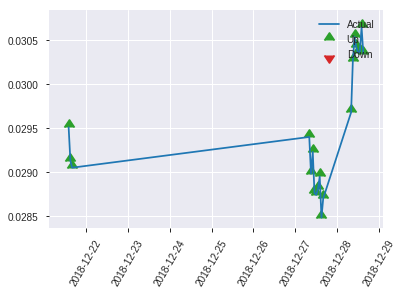


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2504816078113158
RMSE: 0.5004813760883773
LogLoss: 0.6943402006939793
Mean Per-Class Error: 0.4514109200200367
AUC: 0.5337285022541326
pr_auc: 0.5266887557802747
Gini: 0.0674570045082652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30119988322257996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    106  0        (0.0/106.0)
Total  0    219  0.516    (113.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3012       0.652308  218
max f2                       0.3012       0.824261  218
max f0point5                 0.436715     0.549872  168
max accuracy                 0.573292     0.557078  18
max precision                0.660213     1         0
max recall                   0.3012       1         218
max specificity              0.660213     1         0
max absolute_mcc             0.573292     0.155931  18
max min_per_class_accuracy   0.480509     0.537736  108
max mean_per_class_accuracy  0.530248     0.548589  50

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.635224           0.688679  0.688679           0.333333         0.651048  0.333333                    0.651048            0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.624149           2.06604   1.23962            1                0.629894  0.6                         0.642586            0.0188679       0.0283019                  106.604   23.9623
    3        0.0319635                   0.613757           2.06604   1.47574            1                0.61894   0.714286                    0.63583             0.0188679       0.0471698                  106.604   47.5741
    4        0.0410959                   0.600823           2.06604   1.60692            1                0.608567  0.777778                    0.629772            0.0188679       0.0660377                  106.604   60.6918
    5        0.0502283                   0.588816           1.03302   1.50257            0.5              0.594605  0.727273                    0.623378            0.00943396      0.0754717                  3.30189   50.2573
    6        0.100457                    0.565183           1.12693   1.31475            0.545455         0.576652  0.636364                    0.600015            0.0566038       0.132075                   12.693    31.4751
    7        0.150685                    0.545463           1.12693   1.25214            0.545455         0.556656  0.606061                    0.585562            0.0566038       0.188679                   12.693    25.2144
    8        0.200913                    0.535232           1.12693   1.22084            0.545455         0.540374  0.590909                    0.574265            0.0566038       0.245283                   12.693    22.084
    9        0.30137                     0.521113           0.563465  1.00172            0.272727         0.528249  0.484848                    0.558926            0.0566038       0.301887                   -43.6535  0.171527
    10       0.401826                    0.497001           0.939108  0.986063           0.454545         0.509496  0.477273                    0.546569            0.0943396       0.396226                   -6.08919  -1.39365
    11       0.502283                    0.48038            1.40866   1.07058            0.681818         0.487609  0.518182                    0.534777            0.141509        0.537736                   40.8662   7.05832
    12       0.598174                    0.470479           0.885445  1.0409             0.428571         0.475126  0.503817                    0.525215            0.0849057       0.622642                   -11.4555  4.09045
    13       0.69863                     0.449894           1.12693   1.05327            0.545455         0.458521  0.509804                    0.515625            0.113208        0.735849                   12.693    5.32741
    14       0.799087                    0.428702           0.845197  1.02712            0.409091         0.441255  0.497143                    0.506275            0.0849057       0.820755                   -15.4803  2.71159
    15       0.899543                    0.383535           0.751286  0.996313           0.363636         0.40998   0.482234                    0.495522            0.0754717       0.896226                   -24.8714  -0.368739
    16       1                           0.3012             1.03302   1                  0.5              0.358123  0.484018                    0.481719     

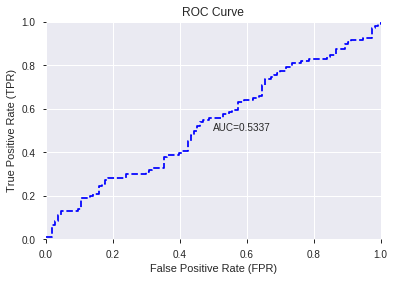

This function is available for GLM models only


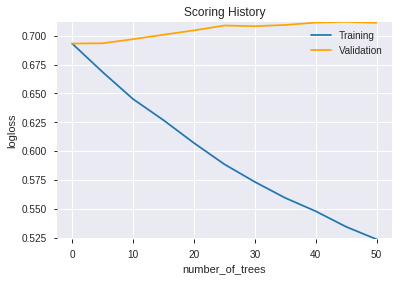

--2019-08-26 15:20:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_151943',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_151943',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_9efa',
   'type

['DX_14',
 'BETA_30',
 'BOP',
 'CCI_20',
 'ULTOSC',
 'BETA_24',
 'AD',
 'DX_12',
 'BETA_8',
 'MACDEXT_hist',
 'MOM_14',
 'BETA_12',
 'Volume',
 'MFI_30',
 'PLUS_DI_12',
 'HT_PHASOR_quadrature',
 'BETA_20',
 'TRANGE',
 'CCI_8',
 'MFI_20',
 'STDDEV_8',
 'PLUS_DM_8',
 'WILLR_8',
 'STDDEV_12',
 'SUB',
 'WILLR_20',
 'DX_24',
 'AROONOSC_30',
 'STOCH_slowk',
 'STDDEV_20',
 'BETA_14',
 'MINUS_DM_30',
 'STOCHRSI_fastd',
 'LINEARREG_ANGLE_14',
 'ATR_8',
 'aroonup_24',
 'ADOSC',
 'PLUS_DM_30',
 'MINUS_DI_14',
 'PLUS_DM_24',
 'HT_PHASOR_inphase',
 'NATR_24',
 'MINUS_DM_14',
 'STOCH_slowd',
 'dayofyear',
 'MFI_8',
 'ROC_20',
 'ADXR_12',
 'aroonup_30',
 'MACDFIX_hist_24',
 'aroondown_14',
 'HT_DCPERIOD',
 'NATR_12',
 'CCI_24',
 'NATR_30',
 'WILLR_14',
 'ADXR_8',
 'MOM_30',
 'DX_8',
 'APO',
 'MFI_24',
 'LINEARREG_INTERCEPT_14',
 'ROC_24',
 'VAR_8',
 'MINUS_DI_24',
 'WILLR_30',
 'CCI_14',
 'STDDEV_24',
 'weekday_name',
 'MFI_12',
 'STOCHF_fastk',
 'WILLR_12',
 'DX_20',
 'ATR_30',
 'STDDEV_30',
 'MINUS

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

83

['BBANDS_upperband_14_4_4',
 'BBANDS_middleband_14_4_4',
 'BBANDS_upperband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_lowerband_24_2_4',
 'BBANDS_middleband_24_3_3',
 'aroonup_8',
 'CCI_8',
 'DX_8',
 'MACDFIX_hist_8',
 'RSI_8',
 'WILLR_8',
 'aroondown_12',
 'aroonup_12',
 'CMO_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'ROCR100_12',
 'RSI_12',
 'CCI_14',
 'MFI_14',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'aroondown_20',
 'AROONOSC_20',
 'CCI_20',
 'DX_20',
 'PLUS_DI_20',
 'ROC_20',
 'WILLR_20',
 'ADX_24',
 'CMO_24',
 'DX_24',
 'MACDFIX_signal_24',
 'MFI_24',
 'MINUS_DI_24',
 'ROC_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'MINUS_DM_30',
 'ROC_30',
 'ROCP_30',
 'WILLR_30',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'AD',
 'ADOSC'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_152130_model_2  0.541994  1.836882              0.495575  0.650533  0.423193
1  DeepLearning_grid_1_AutoML_20190826_152130_model_5  0.534313  0.701452              0.491150  0.503845  0.253860
2               DeepLearning_1_AutoML_20190826_152130  0.523877  0.724771              0.443939  0.514489  0.264699
3  DeepLearning_grid_1_AutoML_20190826_152130_model_3  0.523293  1.848548              0.491150  0.656687  0.431238
4  DeepLearning_grid_1_AutoML_20190826_152130_model_8  0.500000  0.695897              0.500000  0.501361  0.251362
5  DeepLearning_grid_1_AutoML_20190826_152130_model_9  0.500000  0.692968              0.500000  0.499910  0.249910
6  DeepLearning_grid_1_AutoML_20190826_152130_model_1  0.495826  2.769556              0.487018  0.704618  0.496487
7  DeepLearning_grid_1_AutoML_20190826_152130_model_7  0.493321  0.863570              0.500000  0.553562  0.306431
8  DeepLearning_grid_1_AutoML_20190826_152130_model_6  0.476039  0.699826              0.500000  0.503308  0.253319
9  DeepLearning_grid_1_AutoML_20190826_152130_model_4  0.438471  0.954835              0.482885  0.579995  0.336394

variable  relative_importance  scaled_importance  percentage
0                         AD             1.000000           1.000000    0.021263
1             STOCHRSI_fastk             0.888128           0.888128    0.018884
2                 aroonup_12             0.875375           0.875375    0.018613
3               aroondown_20             0.871514           0.871514    0.018531
4               aroondown_12             0.860935           0.860935    0.018306
..                       ...                  ...                ...         ...
78   BBANDS_lowerband_20_6_2             0.405926           0.405926    0.008631
79  BBANDS_middleband_24_3_3             0.403087           0.403087    0.008571
80                PLUS_DM_14             0.402225           0.402225    0.008553
81        LINEARREG_ANGLE_12             0.400809           0.400809    0.008522
82                PLUS_DM_12             0.395046           0.395046    0.008400

[83 rows x 4 columns]

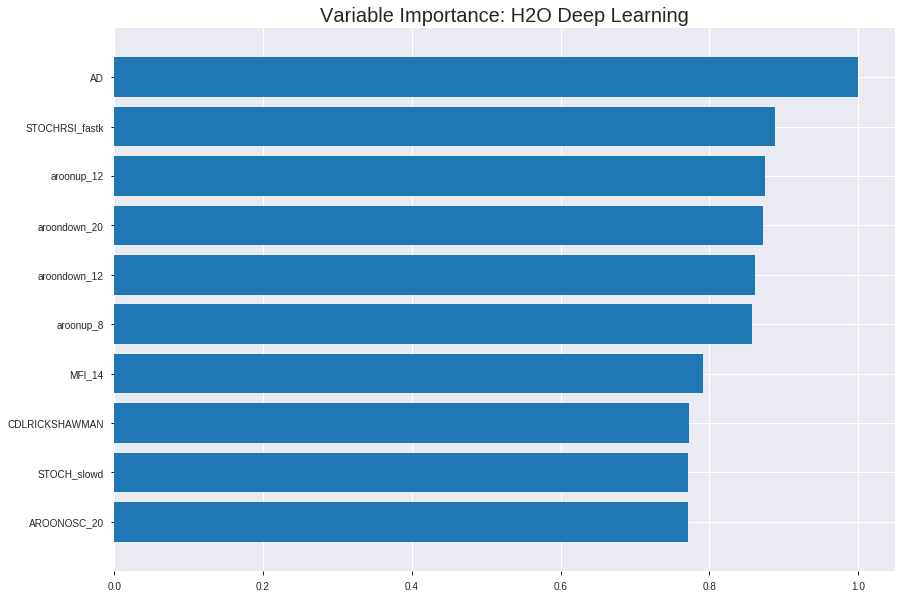

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_152130_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2885788943083122
RMSE: 0.5371953967676121
LogLoss: 0.9380932031300429
Mean Per-Class Error: 0.41137247132287136
AUC: 0.6056425111531656
pr_auc: 0.5412911281196235
Gini: 0.21128502230633117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16575040291627072: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      126  662   0.8401   (662.0/788.0)
1      43   700   0.0579   (43.0/743.0)
Total  169  1362  0.4605   (705.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.16575      0.665083  346
max f2                       0.00240175   0.825006  399
max f0point5                 0.337511     0.584081  276
max accuracy                 0.523436     0.586545  208
max precision                0.915672     0.595238  44
max recall                   0.00240175   1         399
max specificity              0.99959      0.988579  0
max absolute_mcc             0.337511     0.19678   276
max min_per_class_accuracy   0.608809     0.578735  175
max mean_per_class_accuracy  0.523436     0.588628  208

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 57.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.999171           0.901497  0.901497           0.4375           0.999609   0.4375                      0.999609            0.00942127      0.00942127                 -9.85027  -9.85027
    2        0.0202482                   0.996644           0.961597  0.930578           0.466667         0.998217   0.451613                    0.998935            0.00942127      0.0188425                  -3.84029  -6.94221
    3        0.0300457                   0.994741           0.961597  0.940693           0.466667         0.995936   0.456522                    0.997957            0.00942127      0.0282638                  -3.84029  -5.93072
    4        0.0404964                   0.990141           1.03028   0.963813           0.5              0.992661   0.467742                    0.99659             0.0107672       0.039031                   3.02826   -3.61872
    5        0.0502939                   0.985736           0.961597  0.963381           0.466667         0.98751    0.467532                    0.994821            0.00942127      0.0484522                  -3.84029  -3.66188
    6        0.100588                    0.95838            1.17747   1.07042            0.571429         0.972474   0.519481                    0.983648            0.0592194       0.107672                   17.7466   7.04235
    7        0.150229                    0.926457           1.43697   1.19154            0.697368         0.94442    0.578261                    0.970686            0.0713324       0.179004                   43.6973   19.1544
    8        0.200523                    0.885869           1.12394   1.17459            0.545455         0.904945   0.570033                    0.954197            0.0565276       0.235532                   12.3945   17.4589
    9        0.300457                    0.800819           1.18516   1.17811            0.575163         0.842464   0.571739                    0.917034            0.118439        0.35397                    18.5162   17.8106
    10       0.400392                    0.705671           1.22556   1.18995            0.594771         0.753708   0.577488                    0.876269            0.122476        0.476447                   22.5565   18.9951
    11       0.500327                    0.605543           1.03702   1.1594             0.503268         0.653653   0.562663                    0.831804            0.103634        0.580081                   3.70165   15.9404
    12       0.600261                    0.485493           1.09089   1.148              0.529412         0.54594    0.557127                    0.784212            0.109017        0.689098                   9.08875   14.7997
    13       0.700196                    0.369276           0.902339  1.11294            0.437908         0.429937   0.540112                    0.733648            0.090175        0.779273                   -9.7661   11.2936
    14       0.800131                    0.265316           0.929275  1.09               0.45098          0.318283   0.52898                     0.68177             0.0928668       0.87214                    -7.07255  8.9997
    15       0.900065                    0.152128           0.740726  1.05122            0.359477         0.212055   0.51016                     0.629617            0.0740242       0.946164                   -25.9274  5.12173
    16       1                           0.00240175         0.53871   1                  0.261438         0.0880966  0.485304               



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3997670715051966
RMSE: 0.6322713590739316
LogLoss: 2.2164756409042856
Mean Per-Class Error: 0.47236306729264477
AUC: 0.5133333333333333
pr_auc: 0.4969075866909359
Gini: 0.026666666666666616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.3824686633971656e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    211  0.9906   (211.0/213.0)
1      1    224  0.0044   (1.0/225.0)
Total  3    435  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.38247e-05  0.678788   398
max f2                       1.13044e-05  0.840807   399
max f0point5                 0.101066     0.571429   354
max accuracy                 0.667209     0.527397   260
max precision                0.950714     0.547486   144
max recall                   1.13044e-05  1          399
max specificity              1            0.938967   0
max absolute_mcc             0.950714     0.0561985  144
max min_per_class_accuracy   0.906295     0.516432   184
max mean_per_class_accuracy  0.950714     0.527637   144

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 71.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   1                  1.168     1.168              0.6              1          0.6                         1                   0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   1                  0.973333  1.08148            0.5              1          0.555556                    1                   0.00888889      0.0222222                  -2.66667  8.14815
    3        0.0319635                   1                  0.389333  0.834286           0.2              1          0.428571                    1                   0.00444444      0.0266667                  -61.0667  -16.5714
    4        0.0410959                   0.999999           0.486667  0.757037           0.25             1          0.388889                    1                   0.00444444      0.0311111                  -51.3333  -24.2963
    5        0.0502283                   0.999992           0.973333  0.796364           0.5              0.999998   0.409091                    1                   0.00888889      0.04                       -2.66667  -20.3636
    6        0.100457                    0.999518           1.1503    0.973333           0.590909         0.999825   0.5                         0.999912            0.0577778       0.0977778                  15.0303   -2.66667
    7        0.150685                    0.997968           0.973333  0.973333           0.5              0.998814   0.5                         0.999546            0.0488889       0.146667                   -2.66667  -2.66667
    8        0.200913                    0.995508           0.973333  0.973333           0.5              0.996759   0.5                         0.998849            0.0488889       0.195556                   -2.66667  -2.66667
    9        0.30137                     0.98554            1.10606   1.01758            0.568182         0.991585   0.522727                    0.996428            0.111111        0.306667                   10.6061   1.75758
    10       0.399543                    0.952698           1.17705   1.05676            0.604651         0.972683   0.542857                    0.990593            0.115556        0.422222                   17.7054   5.67619
    11       0.5                         0.906609           0.929091  1.03111            0.477273         0.931462   0.52968                     0.978713            0.0933333       0.515556                   -7.09091  3.11111
    12       0.600457                    0.769021           1.01758   1.02885            0.522727         0.847851   0.528517                    0.95682             0.102222        0.617778                   1.75758   2.88466
    13       0.69863                     0.606621           0.950698  1.01786            0.488372         0.69804    0.522876                    0.920455            0.0933333       0.711111                   -4.93023  1.78649
    14       0.799087                    0.331168           0.973333  1.01227            0.5              0.473933   0.52                        0.864321            0.0977778       0.808889                   -2.66667  1.22667
    15       0.899543                    0.0775019          0.973333  1.00792            0.5              0.196523   0.517766                    0.789745            0.0977778       0.906667                   -2.66667  0.791878
    16       1                           9.22909e-06        0.929091  1                  0.477273         0.0179102  0.513699               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:22:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 15:22:15  43.117 sec        4018 obs/sec      9.28217   1             14211      0.563968         1.0357              -0.273338      0.562136        0.531552           1.54542          0.514696                         0.65384            2.52146               -0.711314        0.509609          0.489717             0.389333           0.481735
    2019-08-26 15:22:20  48.288 sec        4968 obs/sec      27.8779   3             42681      0.537195         0.938093            -0.155314      0.605643        0.541291           0.901497         0.460483                         0.632271           2.21648               -0.600269        0.513333          0.496908             1.168              0.484018
    2019-08-26 15:22:25  53.772 sec        6115 obs/sec      55.7394   6             85337      0.512198         0.896353            -0.0502937     0.688266        0.621013           1.15907          0.367734                         0.647115           2.79443               -0.676288        0.508931          0.501378             1.55733            0.486301
    2019-08-26 15:22:31  59.801 sec        7170 obs/sec      92.9902   10            142368     0.463343         0.767004            0.14051        0.768258        0.710281           1.93178          0.287394                         0.678159           3.42523               -0.840981        0.490923          0.493703             1.168              0.486301
    2019-08-26 15:22:37  1 min  5.276 sec  7907 obs/sec      130.178   14            199303     0.38528          0.483133            0.405725       0.872416        0.833857           2.06057          0.201176                         0.674379           2.89938               -0.820514        0.485957          0.491293             1.168              0.481735
    2019-08-26 15:22:42  1 min 10.321 sec  8507 obs/sec      167.379   18            256258     0.340186         0.375123            0.536695       0.92107         0.857939           2.06057          0.150882                         0.685353           3.99442               -0.880244        0.50482           0.508739             0.778667           0.486301
    2019-08-26 15:22:42  1 min 10.452 sec  8505 obs/sec      167.379   18            256258     0.537195         0.938093            -0.155314      0.605643        0.541291           0.901497         0.460483                         0.632271           2.21648               -0.600269        0.513333          0.496908             1.168              0.484018

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
AD                        1.0                    1.0                  0.021263174701182212
STOCHRSI_fastk            0.8881283402442932     0.8881283402442932   0.018884428055685402
aroonup_12                0.8753745555877686     0.8753745555877686   0.01861324210443246
aroondown_20              0.8715136051177979     0.8715136051177979   0.018531146040076864
aroondown_12              0.8609352111816406     0.8609352111816406   0.018306215801754424
---                       ---                    ---                  ---
BBANDS_lowerband_20_6_2   0.40592557191848755    0.40592557191848755  0.008631266351380104
BBANDS_middleband_24_3_3  0.40308719873428345    0.40308719873428345  0.008570913526497222
PLUS_DM_14                0.402224600315094      0.402224600315094    0.008552571945613032
LINEARREG_ANGLE_12        0.4008089005947113     0.4008089005947113   0.008522469675134122
PLUS_DM_12                0.39504605531692505    0.39504605531692505  0.008399933289216668


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5753424657534246)

('F1', 0.654320987654321)

('auc', 0.5419936550342294)

('logloss', 1.8368816122032037)

('mean_per_class_error', 0.4325429954917348)

('rmse', 0.6505325661420855)

('mse', 0.4231926196114069)

deeplearning prediction progress: |███████████████████████████████████████| 100%


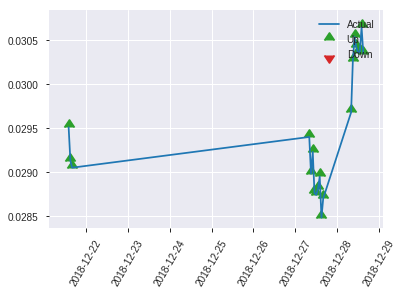


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4231926196114069
RMSE: 0.6505325661420855
LogLoss: 1.8368816122032037
Mean Per-Class Error: 0.4325429954917348
AUC: 0.5419936550342294
pr_auc: 0.5315502450950317
Gini: 0.08398731006845872
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04391982365172847: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    106  0        (0.0/106.0)
Total  1    218  0.5114   (112.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0439198    0.654321  217
max f2                       0.0439198    0.825545  217
max f0point5                 0.397974     0.548098  196
max accuracy                 0.992721     0.575342  54
max precision                0.99909      0.727273  21
max recall                   0.0439198    1         217
max specificity              0.999998     0.99115   0
max absolute_mcc             0.99909      0.162664  21
max min_per_class_accuracy   0.961851     0.518868  108
max mean_per_class_accuracy  0.992721     0.567457  54

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 82.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.999993           0.688679  0.688679           0.333333         0.999996  0.333333                    0.999996            0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.999981           1.03302   0.826415           0.5              0.999988  0.4                         0.999993            0.00943396      0.0188679                  3.30189   -17.3585
    3        0.0319635                   0.999963           1.03302   0.885445           0.5              0.999975  0.428571                    0.999988            0.00943396      0.0283019                  3.30189   -11.4555
    4        0.0410959                   0.999952           1.03302   0.918239           0.5              0.999953  0.444444                    0.99998             0.00943396      0.0377358                  3.30189   -8.1761
    5        0.0502283                   0.999865           2.06604   1.12693            1                0.999919  0.545455                    0.999969            0.0188679       0.0566038                  106.604   12.693
    6        0.100457                    0.999035           1.87822   1.50257            0.909091         0.999576  0.727273                    0.999773            0.0943396       0.150943                   87.8216   50.2573
    7        0.150685                    0.997262           0.939108  1.31475            0.454545         0.99821   0.636364                    0.999252            0.0471698       0.198113                   -6.08919  31.4751
    8        0.200913                    0.994828           0.939108  1.22084            0.454545         0.996196  0.590909                    0.998488            0.0471698       0.245283                   -6.08919  22.084
    9        0.30137                     0.989304           1.03302   1.15823            0.5              0.992433  0.560606                    0.996469            0.103774        0.349057                   3.30189   15.8233
    10       0.401826                    0.974825           0.751286  1.0565             0.363636         0.981846  0.511364                    0.992814            0.0754717       0.424528                   -24.8714  5.64966
    11       0.502283                    0.961007           0.939108  1.03302            0.454545         0.96805   0.5                         0.987861            0.0943396       0.518868                   -6.08919  3.30189
    12       0.598174                    0.912764           1.18059   1.05668            0.571429         0.939661  0.51145                     0.980134            0.113208        0.632075                   18.0593   5.66758
    13       0.69863                     0.834287           0.751286  1.01276            0.363636         0.877164  0.490196                    0.965328            0.0754717       0.707547                   -24.8714  1.27636
    14       0.799087                    0.688221           0.751286  0.979892           0.363636         0.768413  0.474286                    0.940573            0.0754717       0.783019                   -24.8714  -2.01078
    15       0.899543                    0.396984           1.40866   1.02778            0.681818         0.547527  0.497462                    0.89668             0.141509        0.924528                   40.8662   2.77751
    16       1                           0.0185364          0.751286  1                  0.363636         0.214216  0.484018                    0.828122       

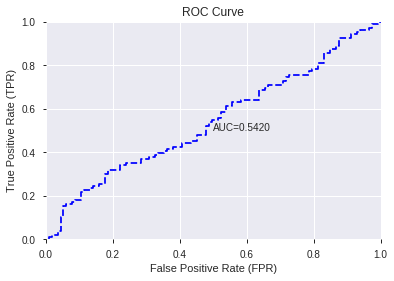

This function is available for GLM models only


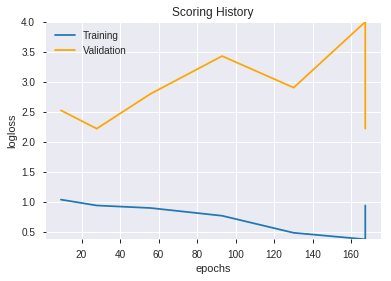

--2019-08-26 15:31:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_152130_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_152130_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['AD',
 'STOCHRSI_fastk',
 'aroonup_12',
 'aroondown_20',
 'aroondown_12',
 'aroonup_8',
 'MFI_14',
 'CDLRICKSHAWMAN',
 'STOCH_slowd',
 'AROONOSC_20',
 'DX_8',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'MFI_24',
 'OBV',
 'BETA_12',
 'ADX_24',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'HT_PHASOR_inphase',
 'CDLLONGLINE',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ADOSC',
 'ROC_24',
 'MACDEXT_hist',
 'ROCR100_24',
 'CDLHIKKAKE',
 'WILLR_8',
 'DX_20',
 'DX_24',
 'PPO',
 'WILLR_24',
 'MINUS_DI_24',
 'MACDFIX_signal_24',
 'WILLR_20',
 'CCI_20',
 'WILLR_30',
 'CCI_8',
 'ROCP_30',
 'PLUS_DI_20',
 'MINUS_DM_30',
 'PLUS_DI_14',
 'MINUS_DI_12',
 'CCI_14',
 'BBANDS_upperband_14_4_4',
 'PLUS_DI_12',
 'RSI_24',
 'ROC_30',
 'STDDEV_8',
 'BBANDS_upperband_14_5_3',
 'MACDFIX_hist_8',
 'BBANDS_upperband_14_5_5',
 'MINUS_DI_14',
 'ROC_20',
 'ATR_12',
 'ROCR100_14',
 'ROCR_14',
 'BBANDS_lowerband_20_5_4',
 'STDDEV_12',
 'CMO_24',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_24_2_4',
 'BBANDS_l

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_153142_model_1  0.527968  0.691799              0.473451  0.499327  0.249327

variable  relative_importance  scaled_importance  percentage
0                       DX_8             0.008839           1.000000    0.049891
1                         AD             0.008491           0.960579    0.047924
2             CDLSPINNINGTOP             0.007770           0.879075    0.043858
3                      DX_20             0.007176           0.811897    0.040506
4                    NATR_14             0.007138           0.807528    0.040288
..                       ...                  ...                ...         ...
78               MINUS_DI_14             0.000103           0.011599    0.000579
79   BBANDS_upperband_14_4_4             0.000082           0.009256    0.000462
80   BBANDS_lowerband_20_1_4             0.000078           0.008826    0.000440
81               MINUS_DI_12             0.000070           0.007900    0.000394
82  BBANDS_middleband_14_4_4             0.000017           0.001911    0.000095

[83 rows x 4 columns]

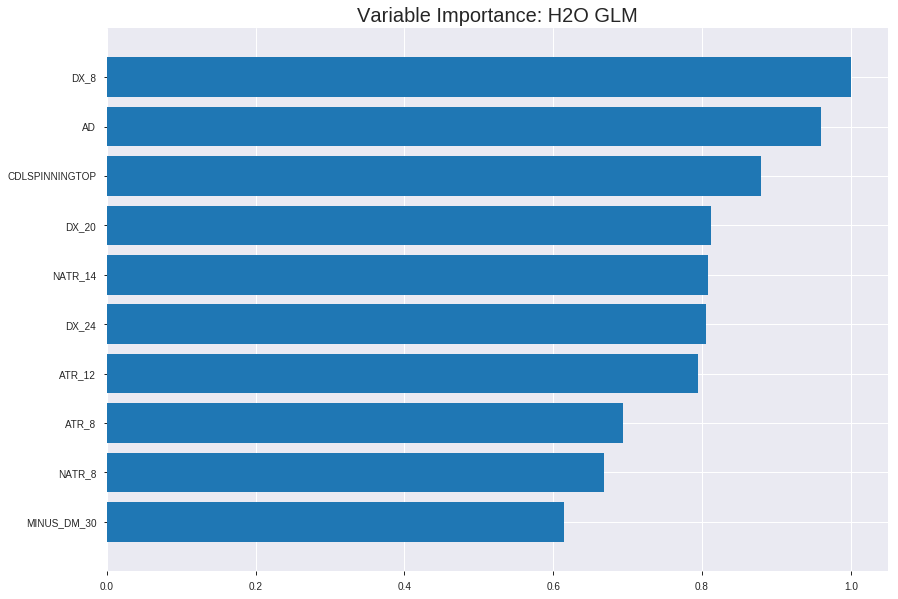

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_153142_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24833851245355526
RMSE: 0.4983357427011986
LogLoss: 0.6898205531974246
Null degrees of freedom: 1530
Residual degrees of freedom: 1447
Null deviance: 2121.0938114372193
Residual deviance: 2112.230533890514
AIC: 2280.230533890514
AUC: 0.5705817750783967
pr_auc: 0.5535061558740576
Gini: 0.14116355015679338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4634798457304202: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      28   760   0.9645   (760.0/788.0)
1      9    734   0.0121   (9.0/743.0)
Total  37   1494  0.5023   (769.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46348      0.656236  376
max f2                       0.458        0.825739  395
max f0point5                 0.482377     0.557328  238
max accuracy                 0.485956     0.559112  201
max precision                0.546035     1         0
max recall                   0.458        1         395
max specificity              0.546035     1         0
max absolute_mcc             0.482377     0.124832  238
max min_per_class_accuracy   0.484933     0.557201  212
max mean_per_class_accuracy  0.482377     0.561305  238

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104507                   0.528355           1.54542   1.54542            0.75             0.536063  0.75                        0.536063            0.0161507       0.0161507                  54.5424    54.5424
    2        0.0202482                   0.516851           1.23634   1.39587            0.6              0.521944  0.677419                    0.529231            0.0121131       0.0282638                  23.6339    39.5867
    3        0.0300457                   0.510877           1.23634   1.34385            0.6              0.513228  0.652174                    0.524013            0.0121131       0.0403769                  23.6339    34.3847
    4        0.0404964                   0.507626           1.54542   1.39587            0.75             0.509155  0.677419                    0.520178            0.0161507       0.0565276                  54.5424    39.5867
    5        0.0502939                   0.505435           1.09897   1.33803            0.533333         0.506474  0.649351                    0.517509            0.0107672       0.0672948                  9.89681    33.8029
    6        0.100588                    0.499913           1.20423   1.27113            0.584416         0.502191  0.616883                    0.50985             0.0605653       0.12786                    20.4226    27.1128
    7        0.150229                    0.49666            1.2743    1.27218            0.618421         0.498207  0.617391                    0.506003            0.0632571       0.191117                   27.4297    27.2175
    8        0.200523                    0.494479           1.0169    1.20815            0.493506         0.49548   0.586319                    0.503363            0.051144        0.242261                   1.69023    20.8149
    9        0.300457                    0.490261           0.996613  1.13779            0.48366          0.492336  0.552174                    0.499696            0.0995962       0.341857                   -0.338673  13.779
    10       0.400392                    0.487421           1.07742   1.12272            0.522876         0.488784  0.544861                    0.496972            0.107672        0.449529                   7.74198    12.2722
    11       0.500327                    0.484761           1.11782   1.12174            0.542484         0.486101  0.544386                    0.494801            0.111709        0.561238                   11.7823    12.1744
    12       0.600261                    0.482236           0.983146  1.09867            0.477124         0.483474  0.533188                    0.492915            0.0982503       0.659489                   -1.68545   9.86692
    13       0.700196                    0.478783           0.781129  1.05335            0.379085         0.480417  0.511194                    0.491131            0.0780619       0.73755                    -21.8871   5.33487
    14       0.800131                    0.475066           0.875404  1.03112            0.424837         0.476799  0.500408                    0.489341            0.0874832       0.825034                   -12.4596   3.11237
    15       0.900065                    0.470196           0.915807  1.01832            0.444444         0.472745  0.494194                    0.487499            0.0915209       0.916555                   -8.41932   1.832
    16       1                           0.455432           0.835     1                  0.405229         0.465536  0.485304                    0.4



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25111908330643906
RMSE: 0.5011178337541372
LogLoss: 0.6953877522817786
Null degrees of freedom: 437
Residual degrees of freedom: 354
Null deviance: 608.2811161936828
Residual deviance: 609.1596709988381
AIC: 777.1596709988381
AUC: 0.4928638497652582
pr_auc: 0.5050557260347929
Gini: -0.014272300469483579
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46077249353561095: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    211  0.9906   (211.0/213.0)
1      0    225  0        (0.0/225.0)
Total  2    436  0.4817   (211.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.460772     0.680787   397
max f2                       0.460772     0.842066   397
max f0point5                 0.470858     0.572712   353
max accuracy                 0.471495     0.52968    349
max precision                0.571754     1          0
max recall                   0.460772     1          397
max specificity              0.571754     1          0
max absolute_mcc             0.483384     0.0715861  193
max min_per_class_accuracy   0.48249      0.478873   205
max mean_per_class_accuracy  0.471495     0.519311   349

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.567077           0.778667  0.778667           0.4              0.570001  0.4                         0.570001            0.00888889      0.00888889                 -22.1333  -22.1333
    2        0.0205479                   0.558169           1.46      1.08148            0.75             0.562888  0.555556                    0.566839            0.0133333       0.0222222                  46        8.14815
    3        0.0319635                   0.520914           0.389333  0.834286           0.2              0.539641  0.428571                    0.557126            0.00444444      0.0266667                  -61.0667  -16.5714
    4        0.0410959                   0.511839           0.486667  0.757037           0.25             0.515522  0.388889                    0.54788             0.00444444      0.0311111                  -51.3333  -24.2963
    5        0.0502283                   0.506353           0.973333  0.796364           0.5              0.508616  0.409091                    0.540741            0.00888889      0.04                       -2.66667  -20.3636
    6        0.100457                    0.496764           1.1503    0.973333           0.590909         0.500621  0.5                         0.520681            0.0577778       0.0977778                  15.0303   -2.66667
    7        0.150685                    0.493767           1.23879   1.06182            0.636364         0.495379  0.545455                    0.512247            0.0622222       0.16                       23.8788   6.18182
    8        0.200913                    0.492259           0.796364  0.995455           0.409091         0.492878  0.511364                    0.507405            0.04            0.2                        -20.3636  -0.454545
    9        0.30137                     0.487739           1.01758   1.00283            0.522727         0.490035  0.515152                    0.501615            0.102222        0.302222                   1.75758   0.282828
    10       0.399543                    0.485233           0.860155  0.967771           0.44186          0.486355  0.497143                    0.497865            0.0844444       0.386667                   -13.9845  -3.22286
    11       0.5                         0.482401           0.929091  0.96               0.477273         0.483972  0.493151                    0.495074            0.0933333       0.48                       -7.09091  -4
    12       0.600457                    0.480317           1.10606   0.984436           0.568182         0.481091  0.505703                    0.492735            0.111111        0.591111                   10.6061   -1.5564
    13       0.69863                     0.477813           1.13178   1.00514            0.581395         0.478925  0.51634                     0.490794            0.111111        0.702222                   13.1783   0.514161
    14       0.799087                    0.475168           0.929091  0.995581           0.477273         0.476424  0.511429                    0.488988            0.0933333       0.795556                   -7.09091  -0.441905
    15       0.899543                    0.470496           1.10606   1.00792            0.568182         0.472725  0.517766                    0.487171            0.111111        0.906667                   10.6061   0.791878
    16       1                           0.457678           0.929091  1                  0.477273         0.466122  0.513699                    0.485057 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 15:31:42  0.000 sec   2            3.4       84            1.37964           1.39078
    2019-08-26 15:31:42  0.028 sec   4            2.1       84            1.37739           1.39152
    2019-08-26 15:31:42  0.052 sec   6            1.3       84            1.37468           1.39249
    2019-08-26 15:31:42  0.075 sec   8            0.8       84            1.37162           1.39374
    2019-08-26 15:31:42  0.110 sec   10           0.5       84            1.36836           1.39527

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5570776255707762)

('F1', 0.664576802507837)

('auc', 0.5279679412255802)

('logloss', 0.6917992854414543)

('mean_per_class_error', 0.44861412589747873)

('rmse', 0.49932685792772413)

('mse', 0.2493273110479736)

glm prediction progress: |████████████████████████████████████████████████| 100%


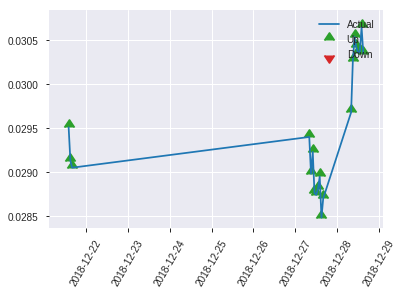


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2493273110479736
RMSE: 0.49932685792772413
LogLoss: 0.6917992854414543
Null degrees of freedom: 218
Residual degrees of freedom: 135
Null deviance: 303.37613151001983
Residual deviance: 303.008087023357
AIC: 471.008087023357
AUC: 0.5279679412255802
pr_auc: 0.5042299767151249
Gini: 0.055935882451160435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668869922227918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    107  0.9469   (107.0/113.0)
1      0    106  0        (0.0/106.0)
Total  6    213  0.4886   (107.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466887     0.664577  212
max f2                       0.466887     0.832025  212
max f0point5                 0.475613     0.557743  163
max accuracy                 0.491075     0.557078  26
max precision                0.491075     0.666667  26
max recall                   0.466887     1         212
max specificity              0.503328     0.99115   0
max absolute_mcc             0.466887     0.162555  212
max min_per_class_accuracy   0.482143     0.471698  108
max mean_per_class_accuracy  0.475613     0.551386  163

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.501902           0.688679  0.688679           0.333333         0.502994  0.333333                    0.502994            0.00943396      0.00943396                 -31.1321  -31.1321
    2        0.0228311                   0.499262           0         0.413208           0                0.49951   0.2                         0.5016              0               0.00943396                 -100      -58.6792
    3        0.0319635                   0.496824           1.03302   0.590296           0.5              0.498299  0.285714                    0.500657            0.00943396      0.0188679                  3.30189   -40.9704
    4        0.0410959                   0.495041           2.06604   0.918239           1                0.495669  0.444444                    0.499549            0.0188679       0.0377358                  106.604   -8.1761
    5        0.0502283                   0.493708           2.06604   1.12693            1                0.494887  0.545455                    0.498701            0.0188679       0.0566038                  106.604   12.693
    6        0.100457                    0.491395           1.31475   1.22084            0.636364         0.492719  0.590909                    0.49571             0.0660377       0.122642                   31.4751   22.084
    7        0.150685                    0.490149           1.12693   1.18954            0.545455         0.490871  0.575758                    0.494097            0.0566038       0.179245                   12.693    18.9537
    8        0.200913                    0.488167           0.939108  1.12693            0.454545         0.489278  0.545455                    0.492892            0.0471698       0.226415                   -6.08919  12.693
    9        0.30137                     0.485914           1.03302   1.09563            0.5              0.486943  0.530303                    0.490909            0.103774        0.330189                   3.30189   9.56261
    10       0.401826                    0.483716           0.657376  0.986063           0.318182         0.48497   0.477273                    0.489424            0.0660377       0.396226                   -34.2624  -1.39365
    11       0.502283                    0.482119           0.751286  0.939108           0.363636         0.482895  0.454545                    0.488119            0.0754717       0.471698                   -24.8714  -6.08919
    12       0.598174                    0.480298           1.27898   0.993591           0.619048         0.481064  0.480916                    0.486988            0.122642        0.59434                    27.8976   -0.640933
    13       0.69863                     0.476901           1.50257   1.06678            0.727273         0.478435  0.51634                     0.485758            0.150943        0.745283                   50.2573   6.67777
    14       0.799087                    0.474246           0.845197  1.03892            0.409091         0.475557  0.502857                    0.484476            0.0849057       0.830189                   -15.4803  3.89218
    15       0.899543                    0.470188           0.939108  1.02778            0.454545         0.472662  0.497462                    0.483156            0.0943396       0.924528                   -6.08919  2.77751
    16       1                           0.461367           0.751286  1                  0.363636         0.467305  0.484018                    0.481564     

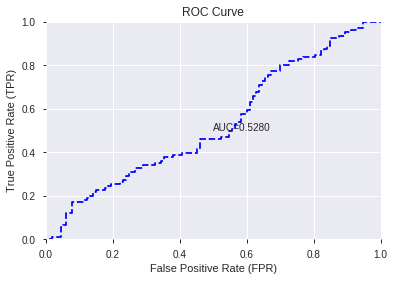

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


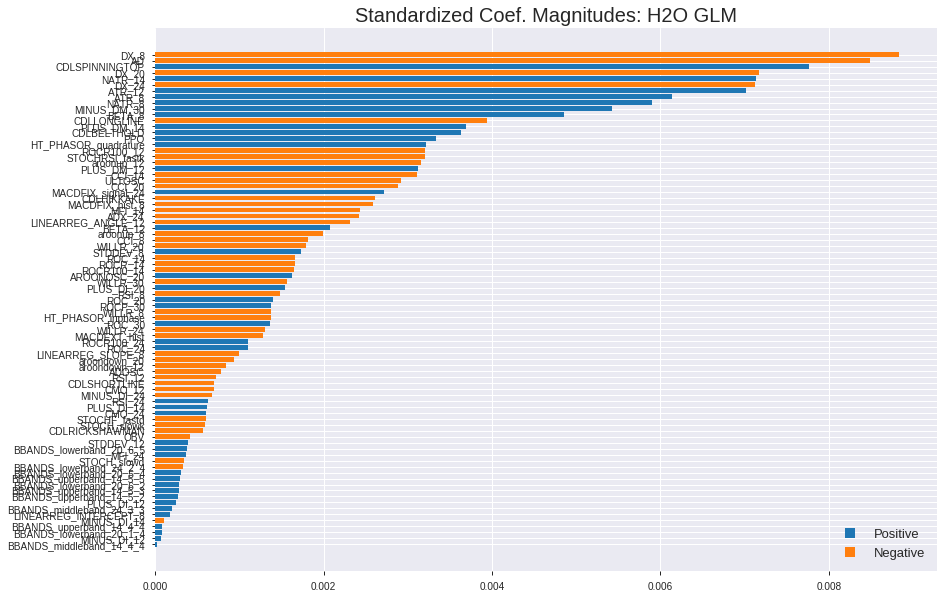

'log_likelihood'
--2019-08-26 15:31:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_153142_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_153142_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['DX_8',
 'AD',
 'CDLSPINNINGTOP',
 'DX_20',
 'NATR_14',
 'DX_24',
 'ATR_12',
 'ATR_8',
 'NATR_8',
 'MINUS_DM_30',
 'BETA_8',
 'CDLLONGLINE',
 'PLUS_DM_14',
 'CDLBELTHOLD',
 'PPO',
 'HT_PHASOR_quadrature',
 'ROCR100_12',
 'STOCHRSI_fastk',
 'aroonup_12',
 'PLUS_DM_12',
 'CCI_14',
 'ULTOSC',
 'CCI_20',
 'MACDFIX_signal_24',
 'CDLHIKKAKE',
 'MACDFIX_hist_8',
 'MFI_14',
 'ADX_24',
 'LINEARREG_ANGLE_12',
 'BETA_12',
 'aroonup_8',
 'CCI_8',
 'WILLR_20',
 'STDDEV_8',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'AROONOSC_20',
 'WILLR_30',
 'PLUS_DI_20',
 'RSI_8',
 'ROC_20',
 'ROCP_30',
 'WILLR_8',
 'HT_PHASOR_inphase',
 'ROC_30',
 'WILLR_24',
 'MACDEXT_hist',
 'ROCR100_24',
 'ROC_24',
 'LINEARREG_SLOPE_8',
 'aroondown_20',
 'aroondown_12',
 'ADOSC',
 'RSI_12',
 'CDLSHORTLINE',
 'CMO_12',
 'MINUS_DI_24',
 'RSI_24',
 'PLUS_DI_14',
 'CMO_24',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLRICKSHAWMAN',
 'OBV',
 'STDDEV_12',
 'BBANDS_lowerband_20_6_5',
 'MFI_24',
 'STOCH_slowd',
 'BBANDS_lowerband_24_2_4',
 'B

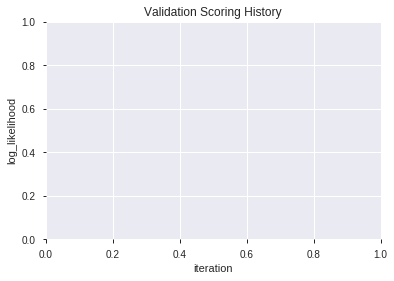

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_153153  0.530723  0.695434              0.495575  0.501098  0.251099
1               XGBoost_1_AutoML_20190826_153153  0.503006  0.708672              0.500000  0.507322  0.257376
2  XGBoost_grid_1_AutoML_20190826_153153_model_1  0.492904  0.709325              0.500000  0.507615  0.257673
3  XGBoost_grid_1_AutoML_20190826_153153_model_4  0.484263  0.700575              0.500000  0.503654  0.253667
4  XGBoost_grid_1_AutoML_20190826_153153_model_3  0.478544  0.707463              0.482885  0.506898  0.256946
5               XGBoost_2_AutoML_20190826_153153  0.477876  0.712059              0.500000  0.509018  0.259100
6  XGBoost_grid_1_AutoML_20190826_153153_model_6  0.470112  0.709765              0.500000  0.508034  0.258099
7  XGBoost_grid_1_AutoML_20190826_153153_model_7  0.451995  0.723508              0.500000  0.514441  0.264650
8  XGBoost_grid_1_AutoML_20190826_153153_model_2  0.434964  0.710227              0.491150  0.508369  0.258439
9  XGBoost_grid_1_AutoML_20190826_153153_model_5  0.432126  0.743067              0.461638  0.523749  0.274313

variable  relative_importance  scaled_importance  percentage
0             DX_8           187.565109           1.000000    0.040063
1               AD           169.612518           0.904286    0.036228
2           CCI_14           162.828812           0.868119    0.034779
3              OBV           155.017441           0.826473    0.033111
4           ULTOSC           121.717407           0.648934    0.025998
..             ...                  ...                ...         ...
76  CDLSPINNINGTOP            14.326561           0.076382    0.003060
77  CDLRICKSHAWMAN            11.359142           0.060561    0.002426
78      ROCR100_24            10.872785           0.057968    0.002322
79         ROCP_30             7.373950           0.039314    0.001575
80      ROCR100_14             3.642248           0.019419    0.000778

[81 rows x 4 columns]

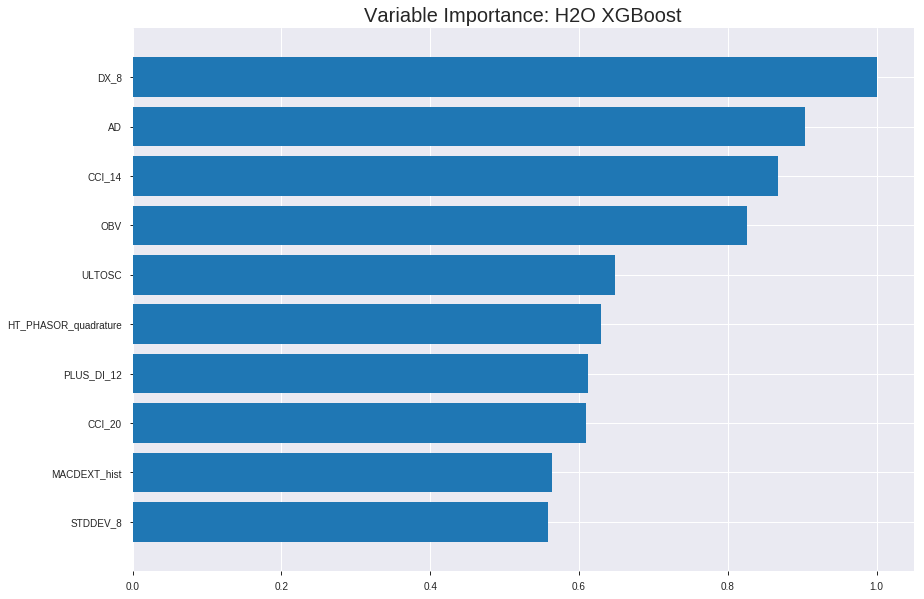

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_153153


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17879268380776522
RMSE: 0.4228388390483604
LogLoss: 0.5463757766335019
Mean Per-Class Error: 0.1210178245690745
AUC: 0.9431111695622767
pr_auc: 0.9405388914928201
Gini: 0.8862223391245534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4884585638840993: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      680  108  0.1371   (108.0/788.0)
1      78   665  0.105    (78.0/743.0)
Total  758  773  0.1215   (186.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488459     0.877309  203
max f2                       0.467935     0.907552  221
max f0point5                 0.522352     0.889371  170
max accuracy                 0.488459     0.878511  203
max precision                0.828991     1         0
max recall                   0.334481     1         339
max specificity              0.828991     1         0
max absolute_mcc             0.488459     0.757673  203
max min_per_class_accuracy   0.493272     0.870794  198
max mean_per_class_accuracy  0.488459     0.878982  203

Gains/Lift Table: Avg response rate: 48.53 %, avg score: 48.92 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.735048           2.06057    2.06057            1                0.764449  1                           0.764449            0.0215343       0.0215343                  106.057   106.057
    2        0.0202482                   0.708052           2.06057    2.06057            1                0.720465  1                           0.743166            0.0201884       0.0417227                  106.057   106.057
    3        0.0300457                   0.6963             2.06057    2.06057            1                0.701697  1                           0.729644            0.0201884       0.0619112                  106.057   106.057
    4        0.0404964                   0.683498           2.06057    2.06057            1                0.69036   1                           0.719506            0.0215343       0.0834455                  106.057   106.057
    5        0.0502939                   0.673565           2.06057    2.06057            1                0.678349  1                           0.711488            0.0201884       0.103634                   106.057   106.057
    6        0.100588                    0.635229           2.0338     2.04718            0.987013         0.651397  0.993506                    0.681443            0.102288        0.205922                   103.38    104.718
    7        0.150229                    0.610808           2.00634    2.03369            0.973684         0.621618  0.986957                    0.661675            0.0995962       0.305518                   100.634   103.369
    8        0.200523                    0.591271           1.98028    2.02029            0.961039         0.60114   0.980456                    0.646492            0.0995962       0.405114                   98.0284   102.029
    9        0.300457                    0.55772            1.92589    1.98889            0.934641         0.574441  0.965217                    0.622527            0.192463        0.597577                   92.5888   98.8893
    10       0.400392                    0.523242           1.65653    1.90594            0.803922         0.540143  0.924959                    0.601964            0.165545        0.763122                   65.6533   90.5939
    11       0.500327                    0.489282           1.23903    1.77273            0.601307         0.505565  0.860313                    0.58271             0.123822        0.886945                   23.9033   77.2732
    12       0.600261                    0.451952           0.592581   1.57625            0.287582         0.472121  0.764962                    0.564298            0.0592194       0.946164                   -40.7419  57.6254
    13       0.700196                    0.422547           0.282823   1.39165            0.137255         0.438229  0.675373                    0.546305            0.0282638       0.974428                   -71.7177  39.165
    14       0.800131                    0.387259           0.175081   1.2397             0.0849673        0.404987  0.601633                    0.528655            0.0174966       0.991925                   -82.4919  23.9703
    15       0.900065                    0.337542           0.0673387  1.10954            0.0326797        0.366123  0.538462                    0.510609            0.00672948      0.998654                   -93.2661  10.9535
    16       1                           0.173505           0.0134677  1                  0.00653595       0.296461  0.485304                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26039908236146514
RMSE: 0.5102931337588869
LogLoss: 0.7152998496447351
Mean Per-Class Error: 0.4821283255086072
AUC: 0.48056338028169016
pr_auc: 0.5030519105072848
Gini: -0.03887323943661969
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23378980159759521: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    225  0        (0.0/225.0)
Total  1    437  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.23379      0.679758   398
max f2                       0.23379      0.841436   398
max f0point5                 0.23379      0.570198   398
max accuracy                 0.23379      0.515982   398
max precision                0.589306     0.604651   42
max recall                   0.23379      1          398
max specificity              0.686476     0.995305   0
max absolute_mcc             0.664351     0.0853527  2
max min_per_class_accuracy   0.50986      0.483568   194
max mean_per_class_accuracy  0.589306     0.517872   42

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.653189           0.389333  0.389333           0.2              0.665225  0.2                         0.665225            0.00444444      0.00444444                 -61.0667  -61.0667
    2        0.0205479                   0.640824           1.46      0.865185           0.75             0.644696  0.444444                    0.656101            0.0133333       0.0177778                  46        -13.4815
    3        0.0319635                   0.627165           0.778667  0.834286           0.4              0.63338   0.428571                    0.647986            0.00888889      0.0266667                  -22.1333  -16.5714
    4        0.0410959                   0.616097           0.486667  0.757037           0.25             0.620819  0.388889                    0.641949            0.00444444      0.0311111                  -51.3333  -24.2963
    5        0.0502283                   0.61012            1.46      0.884848           0.75             0.613896  0.454545                    0.636849            0.0133333       0.0444444                  46        -11.5152
    6        0.100457                    0.587272           1.41576   1.1503             0.727273         0.599463  0.590909                    0.618156            0.0711111       0.115556                   41.5758   15.0303
    7        0.150685                    0.576804           0.973333  1.09131            0.5              0.581061  0.560606                    0.605791            0.0488889       0.164444                   -2.66667  9.13131
    8        0.200913                    0.562544           0.973333  1.06182            0.5              0.56929   0.545455                    0.596666            0.0488889       0.213333                   -2.66667  6.18182
    9        0.30137                     0.545747           0.884848  1.00283            0.454545         0.553614  0.515152                    0.582315            0.0888889       0.302222                   -11.5152  0.282828
    10       0.399543                    0.526268           0.905426  0.978895           0.465116         0.535673  0.502857                    0.570855            0.0888889       0.391111                   -9.45736  -2.11048
    11       0.5                         0.509698           0.929091  0.968889           0.477273         0.518566  0.497717                    0.560349            0.0933333       0.484444                   -7.09091  -3.11111
    12       0.600457                    0.488155           0.840606  0.947427           0.431818         0.498803  0.486692                    0.550053            0.0844444       0.568889                   -15.9394  -5.25729
    13       0.69863                     0.468362           1.08651   0.966972           0.55814          0.477823  0.496732                    0.539903            0.106667        0.675556                   8.65116   -3.30283
    14       0.799087                    0.438063           1.01758   0.973333           0.522727         0.456563  0.5                         0.529426            0.102222        0.777778                   1.75758   -2.66667
    15       0.899543                    0.396633           1.1503    0.993096           0.590909         0.420762  0.510152                    0.517291            0.115556        0.893333                   15.0303   -0.690355
    16       1                           0.23007            1.06182   1                  0.545455         0.313819  0.513699                    0.49


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:31:55  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.514696                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-26 15:31:55  0.111 sec   5                  0.490535         0.674358            0.753096        0.730257           1.93178          0.334422                         0.50186            0.696885              0.475493          0.491009             0.778667           0.486301
    2019-08-26 15:31:55  0.178 sec   10                 0.479649         0.653064            0.828564        0.81918            2.06057          0.254735                         0.503285           0.699809              0.478727          0.498924             0.389333           0.486301
    2019-08-26 15:31:55  0.228 sec   15                 0.474038         0.642129            0.840431        0.835541           2.06057          0.269758                         0.503362           0.700023              0.49735           0.515799             0.778667           0.484018
    2019-08-26 15:31:55  0.303 sec   20                 0.466015         0.626696            0.867071        0.862038           2.06057          0.219464                         0.505456           0.70451               0.494032          0.505081             0.389333           0.486301
    2019-08-26 15:31:55  0.366 sec   25                 0.458232         0.611805            0.882793        0.876852           2.06057          0.19595                          0.505834           0.705408              0.491111          0.505599             0.778667           0.486301
    2019-08-26 15:31:55  0.431 sec   30                 0.450283         0.596849            0.903799        0.896406           2.06057          0.173089                         0.505892           0.705551              0.493688          0.515203             0.778667           0.486301
    2019-08-26 15:31:56  0.503 sec   35                 0.443059         0.583357            0.916596        0.910932           2.06057          0.15872                          0.507856           0.709703              0.479697          0.505308             0.389333           0.486301
    2019-08-26 15:31:56  0.583 sec   40                 0.436814         0.571807            0.925595        0.920974           2.06057          0.150229                         0.508738           0.711705              0.479468          0.508982             0.389333           0.484018
    2019-08-26 15:31:56  0.666 sec   45                 0.429926         0.559148            0.935198        0.931734           2.06057          0.14435                          0.508851           0.712112              0.485352          0.514317             0.778667           0.484018
    2019-08-26 15:31:56  0.729 sec   50                 0.422839         0.546376            0.943111        0.940539           2.06057          0.121489                         0.510293           0.7153                0.480563          0.503052             0.389333           0.484018

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
DX_8            187.5651092529297      1.0                   0.04006299378235229
AD              169.61251831054688     0.9042860849019957    0.03622840779689635
CCI_14          162.8288116455078      0.868118875061858     0.03477944109394588
OBV             155.01744079589844     0.826472692140514     0.03311097032650937
ULTOSC          121.7174072265625      0.6489341632426305    0.025998245347145493
---             ---                    ---                   ---
CDLSPINNINGTOP  14.326560974121094     0.07638180166441227   0.0030600836451662146
CDLRICKSHAWMAN  11.359142303466797     0.060561062495632416  0.00242625747021517
ROCR100_24      10.872784614562988     0.05796805524155959   0.002322373836717656
ROCP_30         7.373950481414795      0.03931408411076655   0.0015750399072885152
ROCR100_14      3.6422481536865234     0.019418580396927596  0.0007779664657042184


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.547945205479452)

('F1', 0.654320987654321)

('auc', 0.5307229921522791)

('logloss', 0.695434111877163)

('mean_per_class_error', 0.45091000166972783)

('rmse', 0.5010979141980687)

('mse', 0.251099119613655)

xgboost prediction progress: |████████████████████████████████████████████| 100%


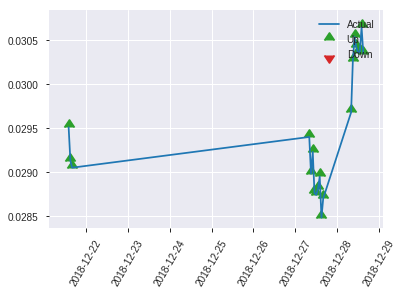


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.251099119613655
RMSE: 0.5010979141980687
LogLoss: 0.695434111877163
Mean Per-Class Error: 0.45091000166972783
AUC: 0.5307229921522791
pr_auc: 0.5107831160441961
Gini: 0.06144598430455828
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32321298122406006: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    106  0        (0.0/106.0)
Total  1    218  0.5114   (112.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323213     0.654321  217
max f2                       0.323213     0.825545  217
max f0point5                 0.351915     0.543478  214
max accuracy                 0.50169      0.547945  116
max precision                0.602484     0.727273  10
max recall                   0.323213     1         217
max specificity              0.664135     0.99115   0
max absolute_mcc             0.602484     0.111938  10
max min_per_class_accuracy   0.506879     0.539823  109
max mean_per_class_accuracy  0.50169      0.54909   116

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 50.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.641206           1.37736   1.37736            0.666667         0.651998  0.666667                    0.651998            0.0188679       0.0188679                  37.7358   37.7358
    2        0.0228311                   0.633055           1.03302   1.23962            0.5              0.63446   0.6                         0.644983            0.00943396      0.0283019                  3.30189   23.9623
    3        0.0319635                   0.620263           1.03302   1.18059            0.5              0.629656  0.571429                    0.640604            0.00943396      0.0377358                  3.30189   18.0593
    4        0.0410959                   0.608852           2.06604   1.37736            1                0.613559  0.666667                    0.634594            0.0188679       0.0566038                  106.604   37.7358
    5        0.0502283                   0.596904           2.06604   1.50257            1                0.604838  0.727273                    0.629184            0.0188679       0.0754717                  106.604   50.2573
    6        0.100457                    0.585882           0.751286  1.12693            0.363636         0.590995  0.545455                    0.610089            0.0377358       0.113208                   -24.8714  12.693
    7        0.150685                    0.571474           0.751286  1.00172            0.363636         0.578903  0.484848                    0.599694            0.0377358       0.150943                   -24.8714  0.171527
    8        0.200913                    0.556238           1.31475   1.07997            0.636364         0.564156  0.522727                    0.590809            0.0660377       0.216981                   31.4751   7.99743
    9        0.30137                     0.537466           0.845197  1.00172            0.409091         0.547492  0.484848                    0.57637             0.0849057       0.301887                   -15.4803  0.171527
    10       0.401826                    0.518792           1.12693   1.03302            0.545455         0.528836  0.5                         0.564487            0.113208        0.415094                   12.693    3.30189
    11       0.502283                    0.506879           1.31475   1.08937            0.636364         0.511949  0.527273                    0.553979            0.132075        0.54717                    31.4751   8.93654
    12       0.598174                    0.491191           0.885445  1.05668            0.428571         0.499126  0.51145                     0.545186            0.0849057       0.632075                   -11.4555  5.66758
    13       0.69863                     0.477995           0.939108  1.03977            0.454545         0.484812  0.503268                    0.536505            0.0943396       0.726415                   -6.08919  3.97706
    14       0.799087                    0.459618           0.845197  1.01531            0.409091         0.469863  0.491429                    0.528127            0.0849057       0.811321                   -15.4803  1.531
    15       0.899543                    0.430407           0.845197  0.996313           0.409091         0.4445    0.482234                    0.518788            0.0849057       0.896226                   -15.4803  -0.368739
    16       1                           0.307714           1.03302   1                  0.5              0.378693  0.484018                    0.504714        

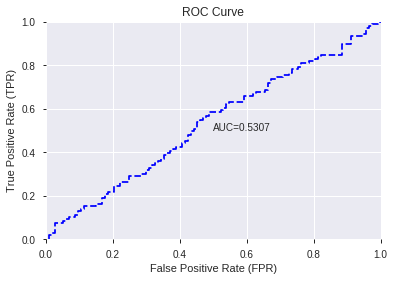

This function is available for GLM models only


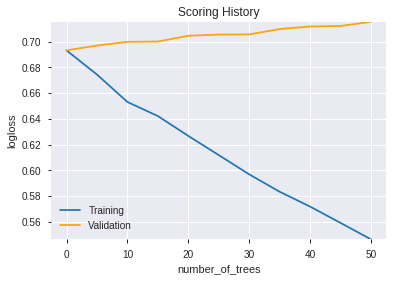

--2019-08-26 15:32:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_153153',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_153153',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9efa',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_9efa',
   'ty

['DX_8',
 'AD',
 'CCI_14',
 'OBV',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'PLUS_DI_12',
 'CCI_20',
 'MACDEXT_hist',
 'STDDEV_8',
 'PPO',
 'ATR_12',
 'MFI_14',
 'HT_PHASOR_inphase',
 'LINEARREG_SLOPE_8',
 'MFI_24',
 'CCI_8',
 'WILLR_8',
 'ATR_8',
 'ROC_24',
 'DX_20',
 'STOCH_slowk',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'MINUS_DI_14',
 'BETA_8',
 'STDDEV_12',
 'PLUS_DI_20',
 'ROC_30',
 'BETA_12',
 'BBANDS_lowerband_20_6_2',
 'ADOSC',
 'aroonup_12',
 'ROC_14',
 'WILLR_20',
 'ROCR100_12',
 'PLUS_DM_12',
 'MINUS_DM_30',
 'MACDFIX_signal_24',
 'MINUS_DI_12',
 'NATR_14',
 'DX_24',
 'STOCH_slowd',
 'AROONOSC_20',
 'ROC_20',
 'CMO_12',
 'STOCHRSI_fastk',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_20_1_4',
 'WILLR_30',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_12',
 'BBANDS_upperband_14_5_5',
 'MACDFIX_hist_8',
 'ROCR_14',
 'BBANDS_middleband_24_3_3',
 'BBANDS_lowerband_20_5_4',
 'RSI_24',
 'aroondown_12',
 'RSI_8',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_upperband_14_4_4',
 'MINUS_DI_24',
 'NATR_8',
 'aroond

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.603
GLM             0.562
XGBoost         0.557
dtype: float64

DeepLearning    GLM  XGBoost
All          0.603  0.557    0.557
DLF          0.598  0.562    0.543
Fwe          0.589  0.557    0.557
RFE          0.575  0.557    0.548
XGBF         0.598  0.562    0.543





F1


DeepLearning    0.669
GLM             0.665
XGBoost         0.654
dtype: float64

DeepLearning    GLM  XGBoost
All          0.660  0.657    0.652
DLF          0.669  0.658    0.654
Fwe          0.656  0.657    0.652
RFE          0.654  0.665    0.654
XGBF         0.656  0.658    0.654





auc


DeepLearning    0.598
GLM             0.561
XGBoost         0.534
dtype: float64

DeepLearning    GLM  XGBoost
All          0.569  0.544    0.534
DLF          0.592  0.561    0.501
Fwe          0.560  0.544    0.534
RFE          0.542  0.528    0.531
XGBF         0.598  0.561    0.501





logloss


DeepLearning    1.837
GLM             0.693
XGBoost         0.719
dtype: float64

DeepLearning    GLM  XGBoost
All          0.763  0.692    0.694
DLF          0.787  0.693    0.719
Fwe          0.804  0.692    0.694
RFE          1.837  0.692    0.695
XGBF         0.771  0.693    0.719





mean_per_class_error


DeepLearning    0.433
GLM             0.449
XGBoost         0.469
dtype: float64

DeepLearning    GLM  XGBoost
All          0.396  0.433    0.451
DLF          0.402  0.437    0.469
Fwe          0.420  0.433    0.451
RFE          0.433  0.449    0.451
XGBF         0.404  0.437    0.469





rmse


DeepLearning    0.651
GLM             0.500
XGBoost         0.512
dtype: float64

DeepLearning    GLM  XGBoost
All          0.520  0.499    0.500
DLF          0.522  0.500    0.512
Fwe          0.539  0.499    0.500
RFE          0.651  0.499    0.501
XGBF         0.503  0.500    0.512





mse


DeepLearning    0.423
GLM             0.250
XGBoost         0.262
dtype: float64

DeepLearning    GLM  XGBoost
All          0.271  0.249    0.250
DLF          0.272  0.250    0.262
Fwe          0.291  0.249    0.250
RFE          0.423  0.249    0.251
XGBF         0.253  0.250    0.262

{'F1':       DeepLearning    GLM  XGBoost
 All          0.660    NaN      NaN
 DLF          0.669    NaN      NaN
 DLF            NaN  0.658      NaN
 DLF            NaN    NaN    0.654
 All            NaN  0.657      NaN
 All            NaN    NaN    0.652
 XGBF         0.656    NaN      NaN
 XGBF           NaN  0.658      NaN
 XGBF           NaN    NaN    0.654
 Fwe          0.656    NaN      NaN
 Fwe            NaN  0.657      NaN
 Fwe            NaN    NaN    0.652
 RFE          0.654    NaN      NaN
 RFE            NaN  0.665      NaN
 RFE            NaN    NaN    0.654,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.603    NaN      NaN
 DLF          0.598    NaN      NaN
 DLF            NaN  0.562      NaN
 DLF            NaN    NaN    0.543
 All            NaN  0.557      NaN
 All            NaN    NaN    0.557
 XGBF         0.598    NaN      NaN
 XGBF           NaN  0.562      NaN
 XGBF           NaN    NaN    0.543
 Fwe          0.589    NaN      NaN
 Fwe     